# Homework 3

<b>Haris Memic and Rob Johnston</b>

In this assignment we were asked to produce a model for a dataset of unknown origin. We will describe the steps we took in order to produce our final model, including:
* Preprocessing data
* Shape of data (assumptions, etc.)
* Feature selection
* Model selection
* Results

Note: throughout this notebook there are a number of code snippets that take a long time to run. We have disabled them by default and displayed the data from a previous run. For example:

```python
runLongRunningProcess = False

if runLongRunningProcess:
    # Do the real processing
    print('Do something')
else:
    # Display the results from a previous build
    print('Results: ...')
```

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


def readFiles():
    """ Read the Training data and truth from file
    """
    X = pd.read_csv("trainingData.txt",sep='\t',header=None)
    Y = pd.read_csv("trainingTruth.txt",sep='\t',header=None)
    Y = np.array(Y).ravel()
    
    return (X,Y)

# Read the files
XOrig,YOrig = readFiles()

/Users/rob/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rob/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Dealing with NAs

We looked at a number of strategies of dealing with NAs:
* Replacing with 0
* Replacing with mean of column
* Removing the row

Replacing with the mean seems an intuitively better idea as the value that you're inserting shouldn't change the distribution too much whereas a 0 may well skew the data. We did run a Random Forest classifier with the two strategies and found that replacing the NAs with the mean produced better results.

We also looked into whether there were some rows or columns with excessive amounts of NAs that they became useless.

In [2]:
from scipy.stats import itemfreq


sums = {}

total = XOrig.shape[0]

for col in XOrig.columns:
    # Count the NAs
    sums[col] = total - XOrig[col].count()
    
# Do something more clever here? Plot a distribution?
#print(sums)
max_cols = max(sums.values())
min_cols = min(sums.values())
print('Maximum number of NAs in one column: {} ({}%)'.format(max_cols, ((max_cols/XOrig.shape[0])*100).round(2)))
print('Minimum number of NAs in one column: {} ({}%)'.format(min_cols, ((min_cols/XOrig.shape[0])*100).round(2)))

# Check the rows to see if there are any rows with excessive NAs
rowSums = XOrig.isnull().sum(axis=1).tolist()

max_rows = max(rowSums)
min_rows = min(rowSums)
print('Maximum number of NAs in one row: {} ({}%)'.format(max_rows, ((max_rows/XOrig.shape[1])*100).round(2)))
print('Minimum number of NAs in one row: {} ({}%)'.format(max_rows, ((max_rows/XOrig.shape[1])*100).round(2)))

Maximum number of NAs in one column: 81 (0.47%)
Minimum number of NAs in one column: 40 (0.23%)
Maximum number of NAs in one row: 7 (2.1%)
Minimum number of NAs in one row: 7 (2.1%)


In [3]:
def preprocessFeatures3( X ):
    """ Preprocess the data. 
        Replace any NaN in X with the mean of the column
        Replacing with the mean gives a better score
    """
    xMean = []
    for col in X.columns:
        xMean = X[col].mean()
        #print(col, ' ', xMean)
        X.loc[X[col].isnull(), col] = xMean

    return (X)


# Deal with NAs
X = preprocessFeatures3(XOrig)

# Split the results into 4 binary classifications
Y = label_binarize(YOrig, classes=[1, 2, 3, 4])


## Check Distribution of Features

Plot a histogram of the distribution of each feature. From this we see that all features are normally distributed and therefore will meet the normality assumptions for models that require it. We also decided that transforming data wasn't necessary.

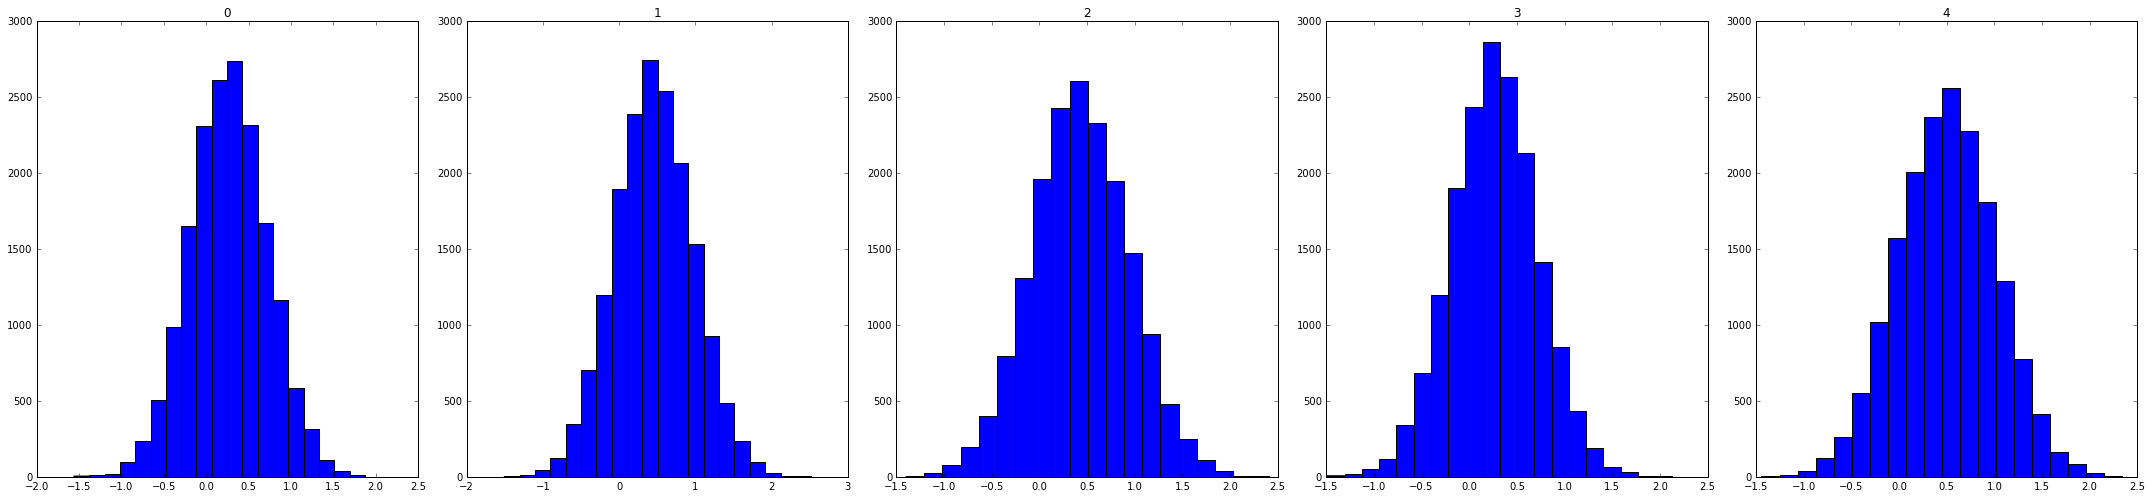

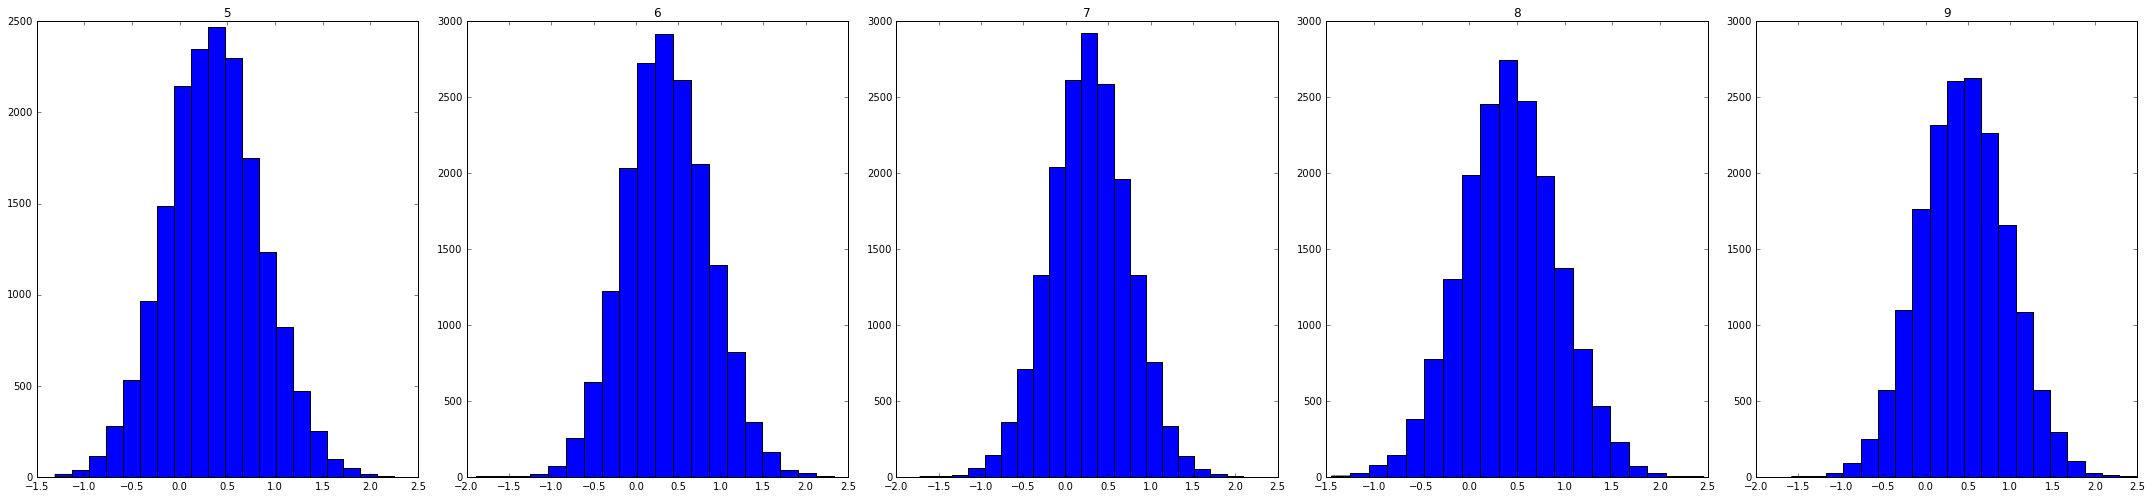

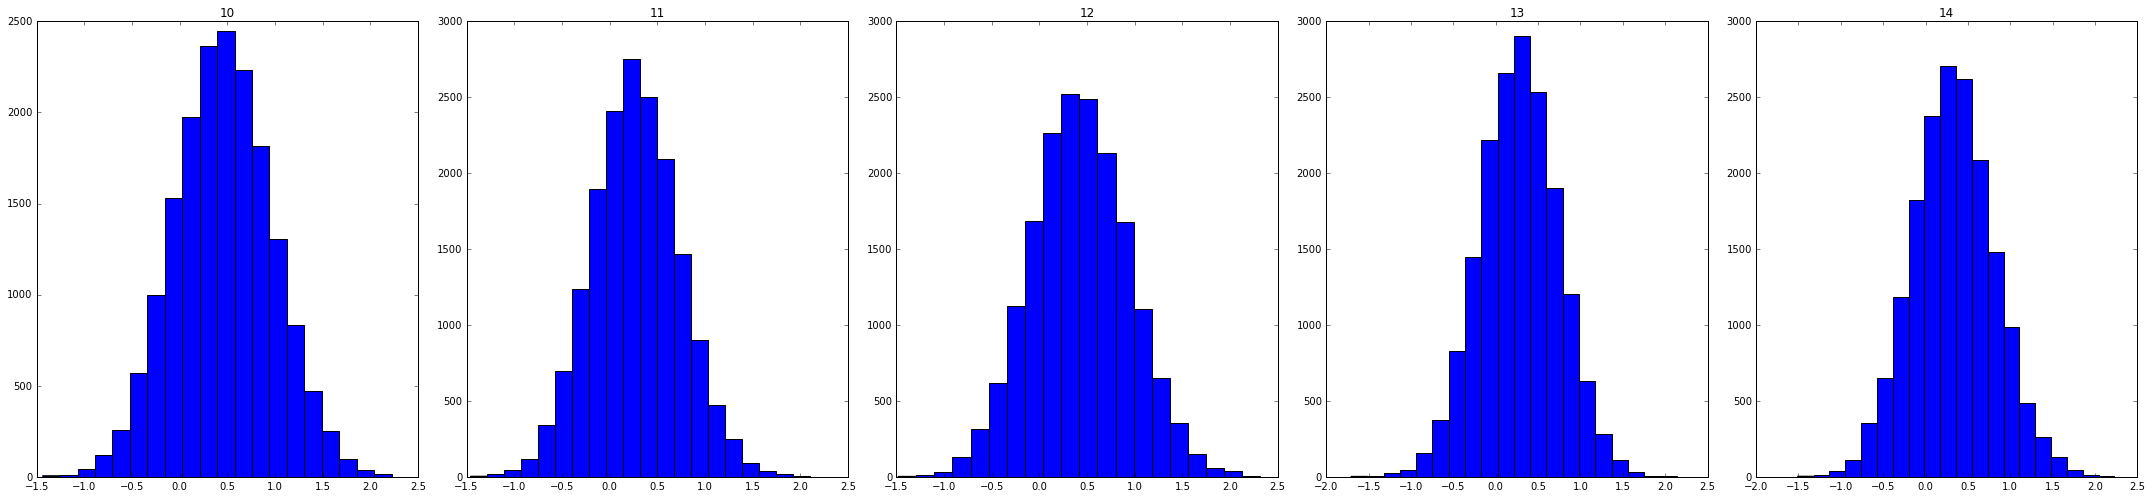

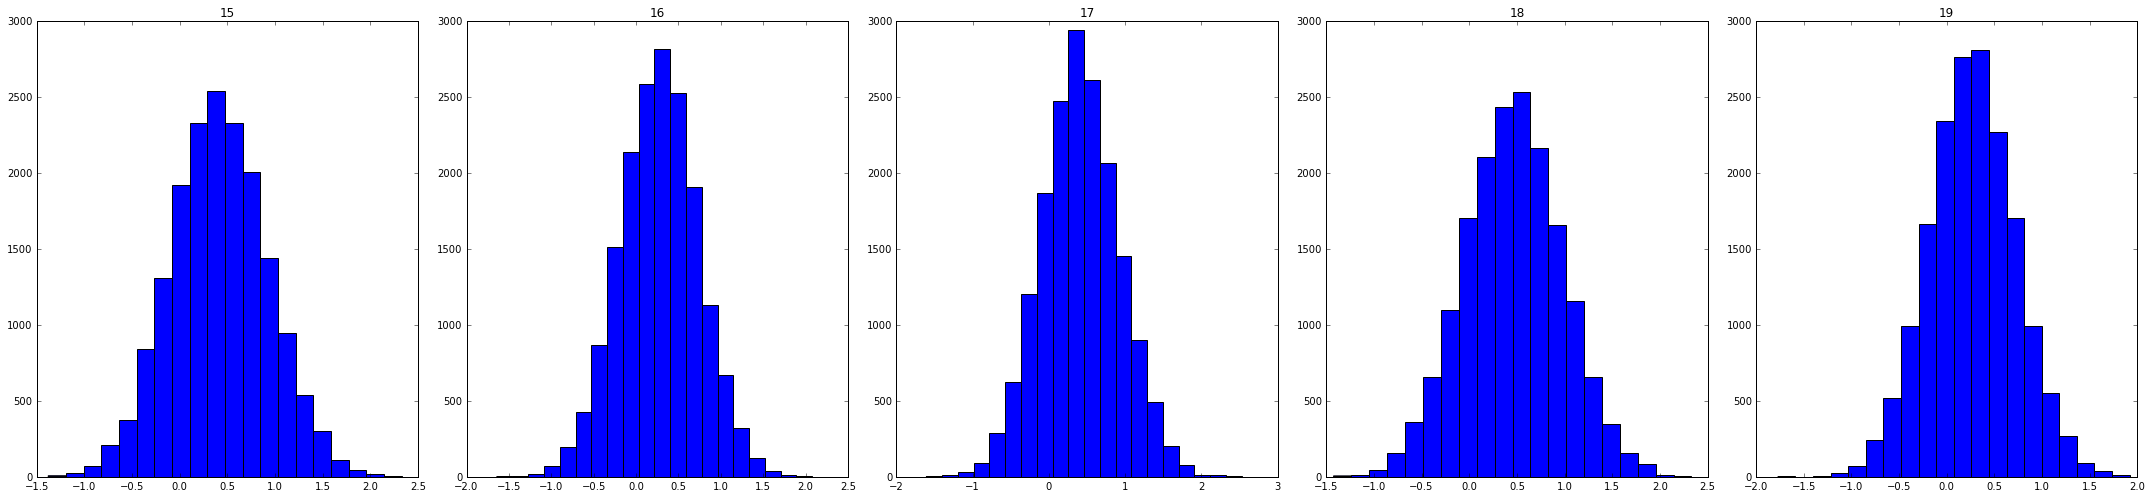

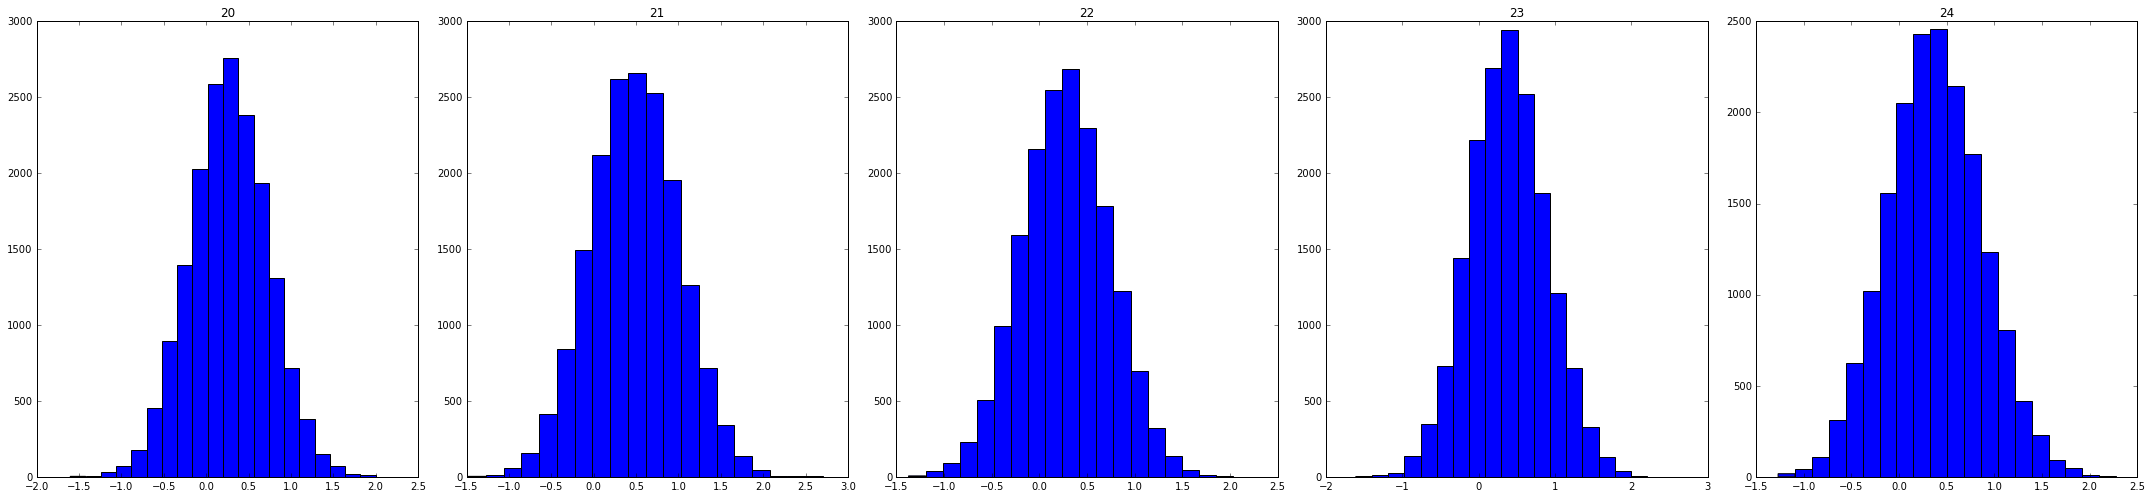

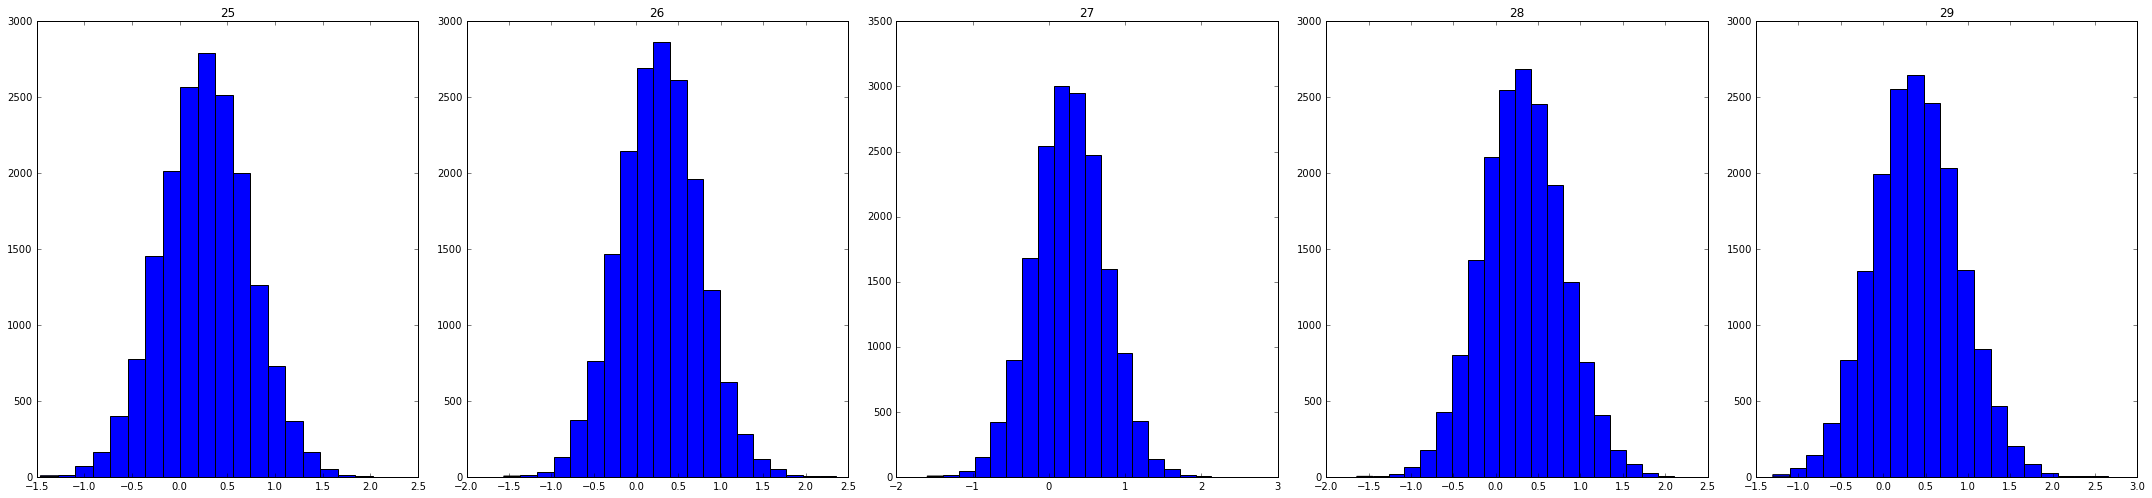

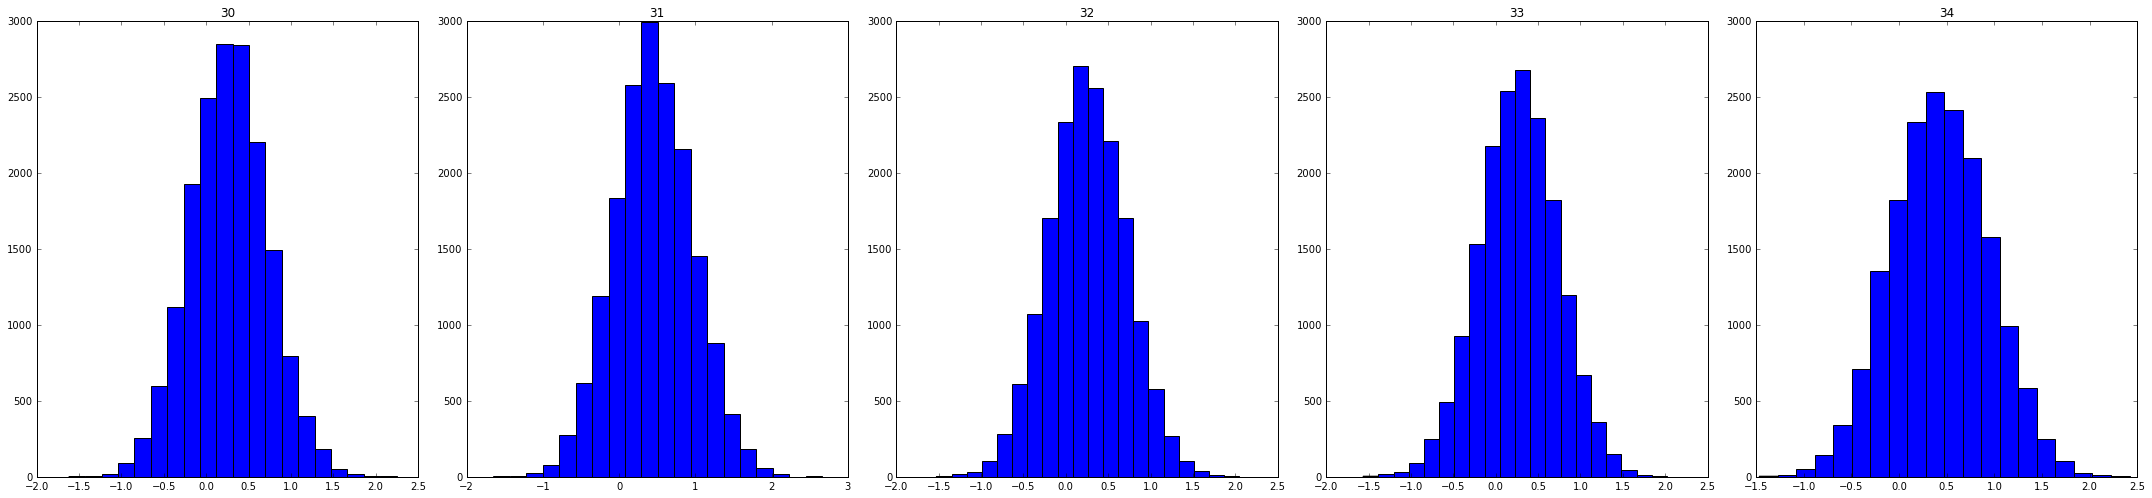

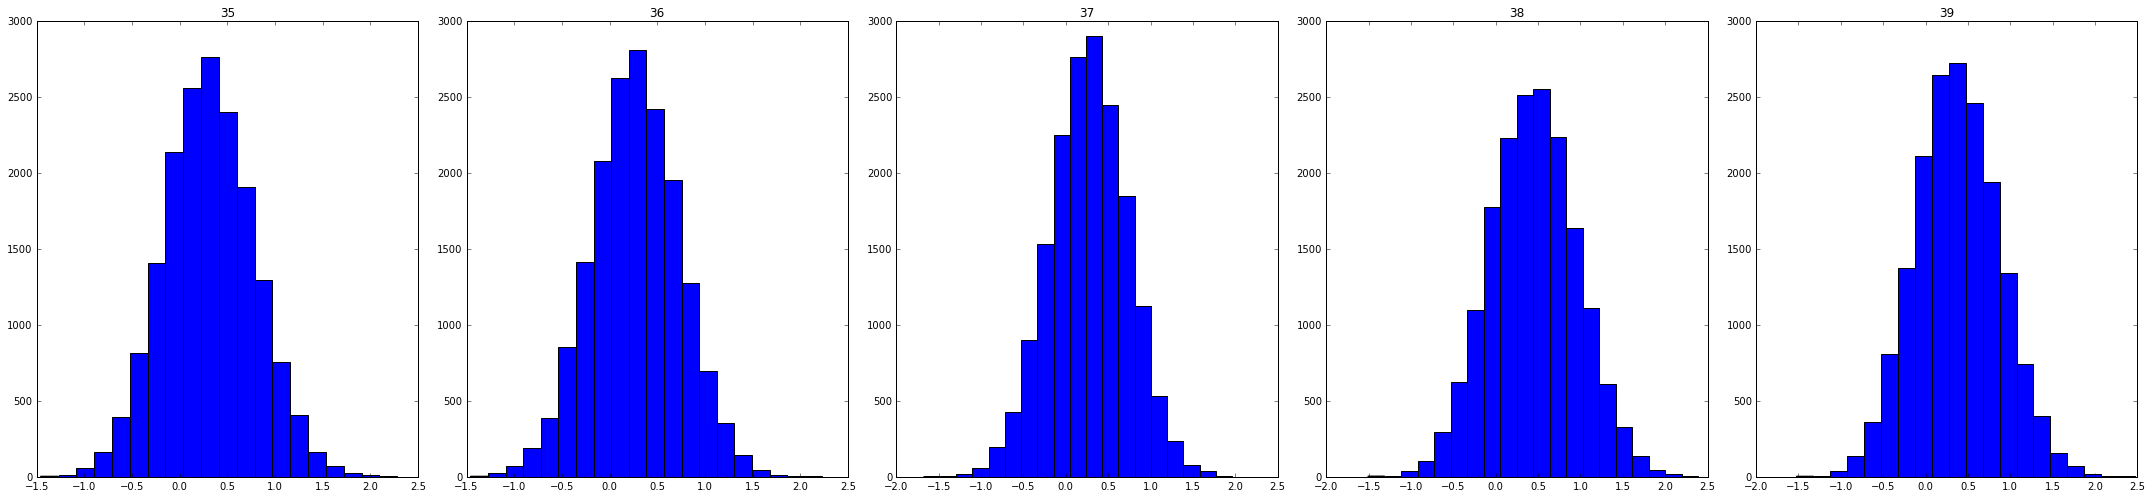

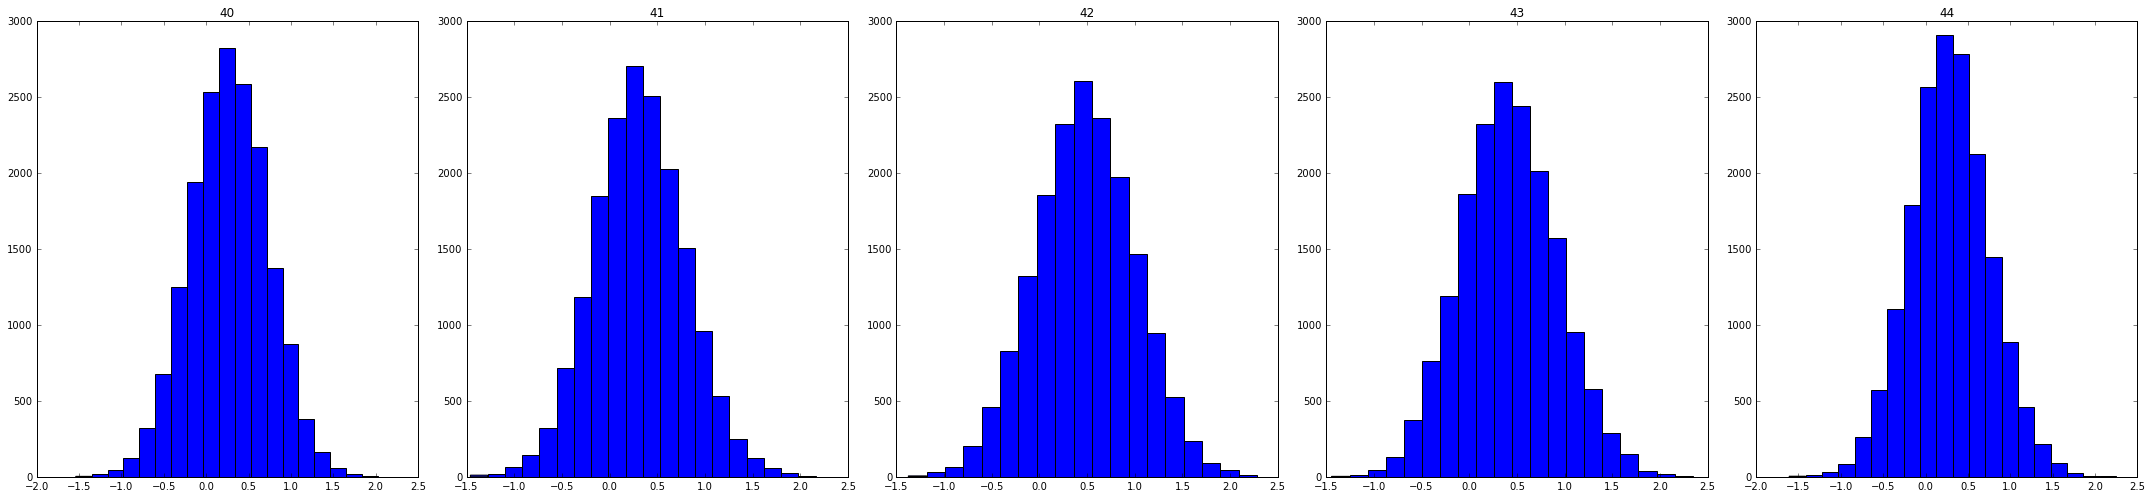

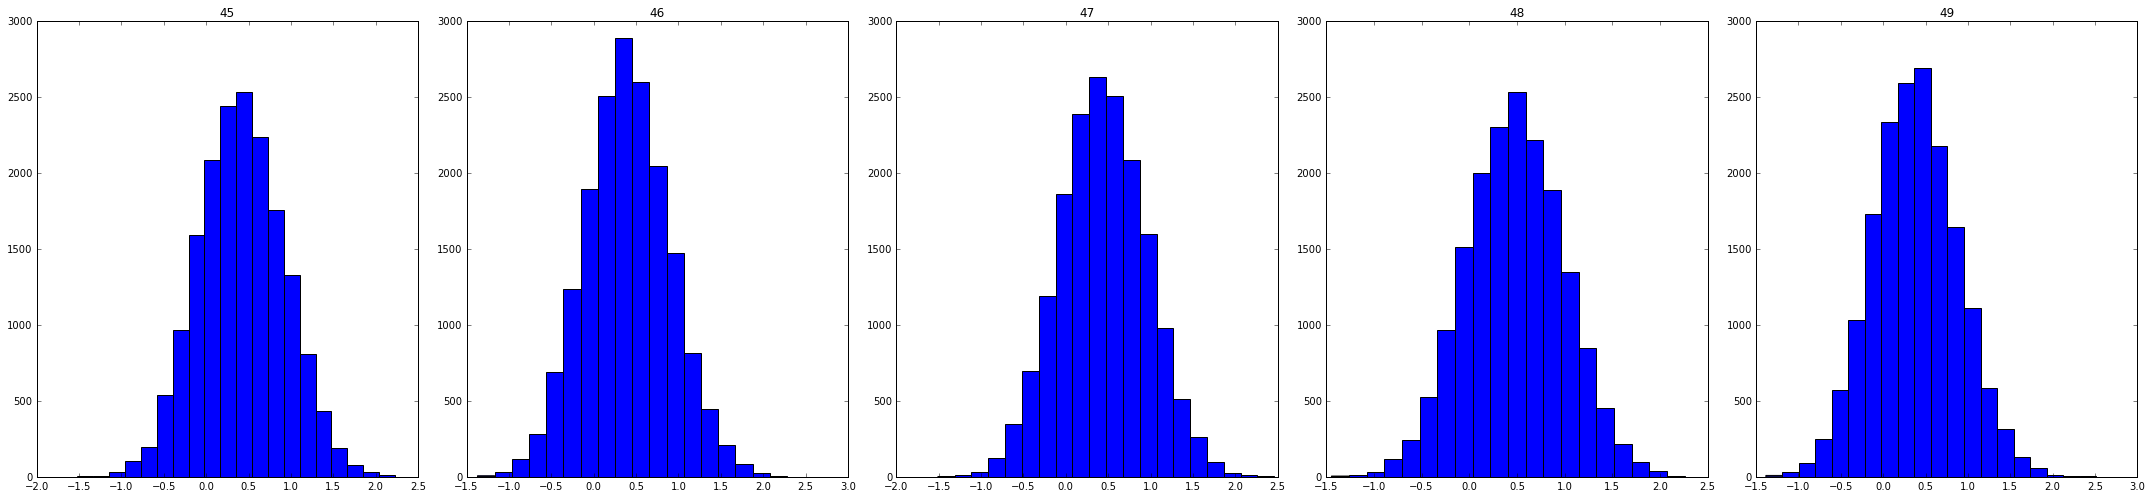

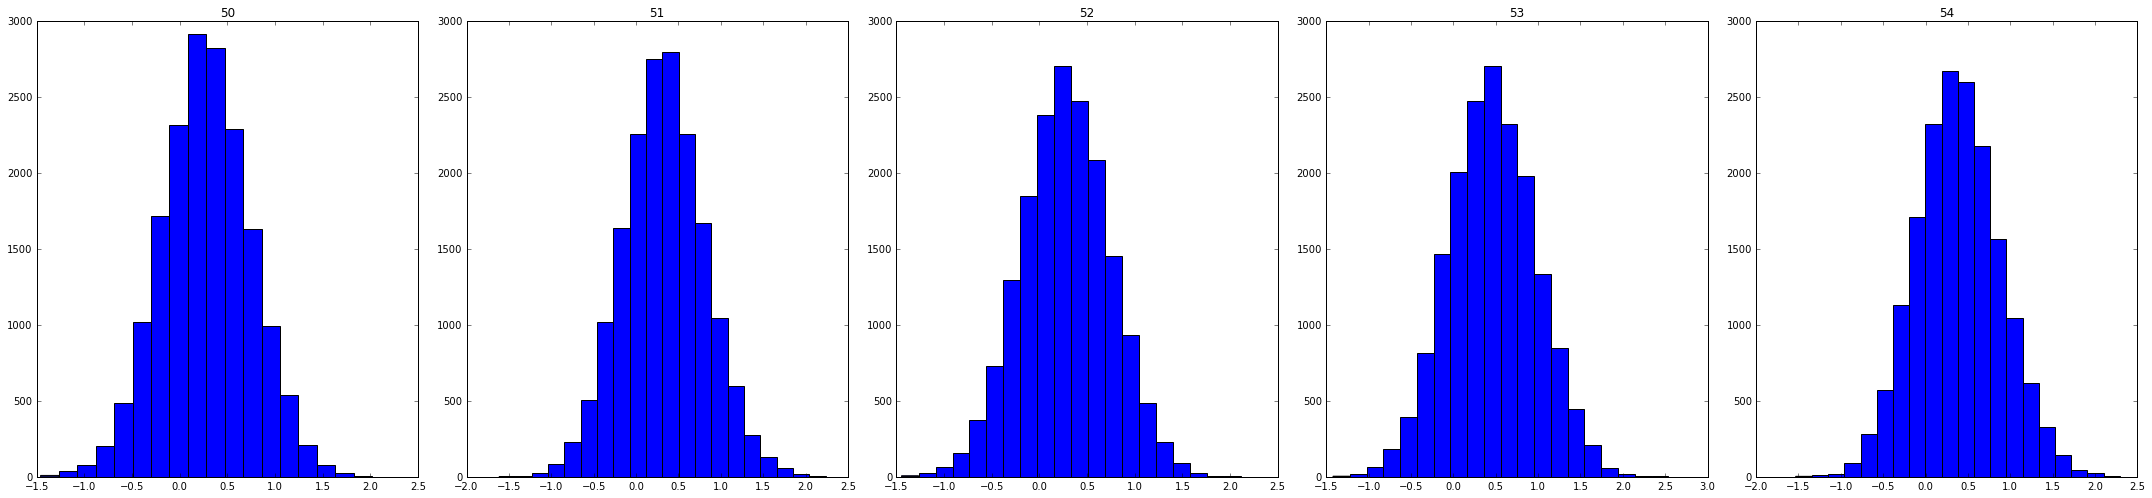

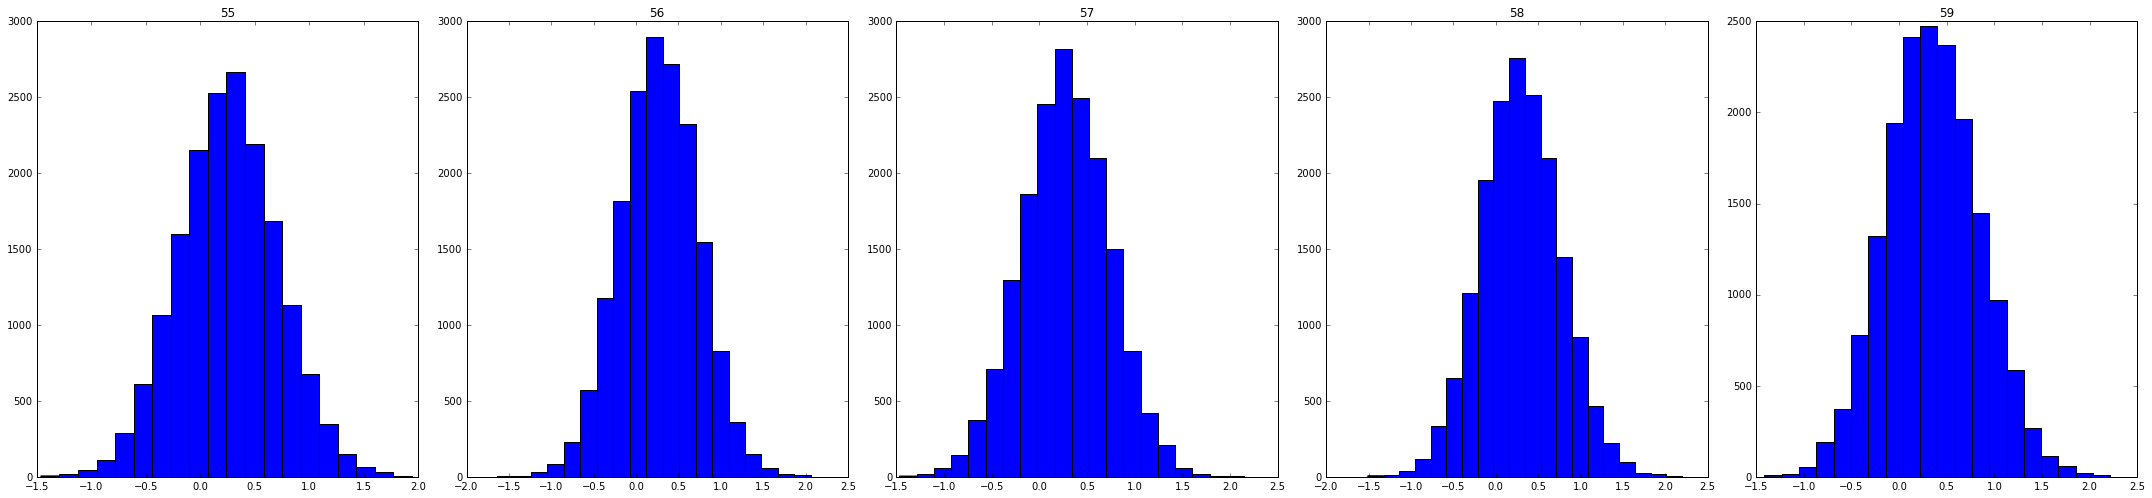

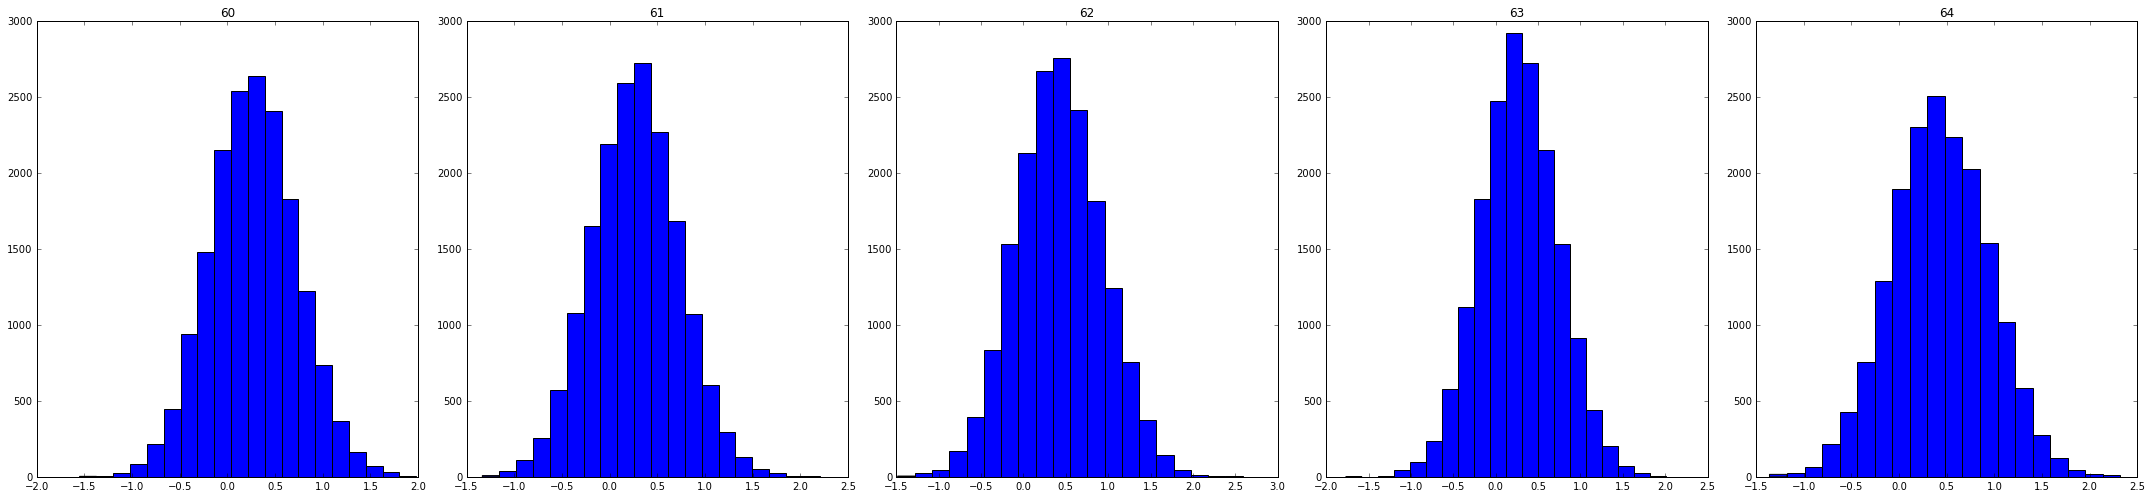

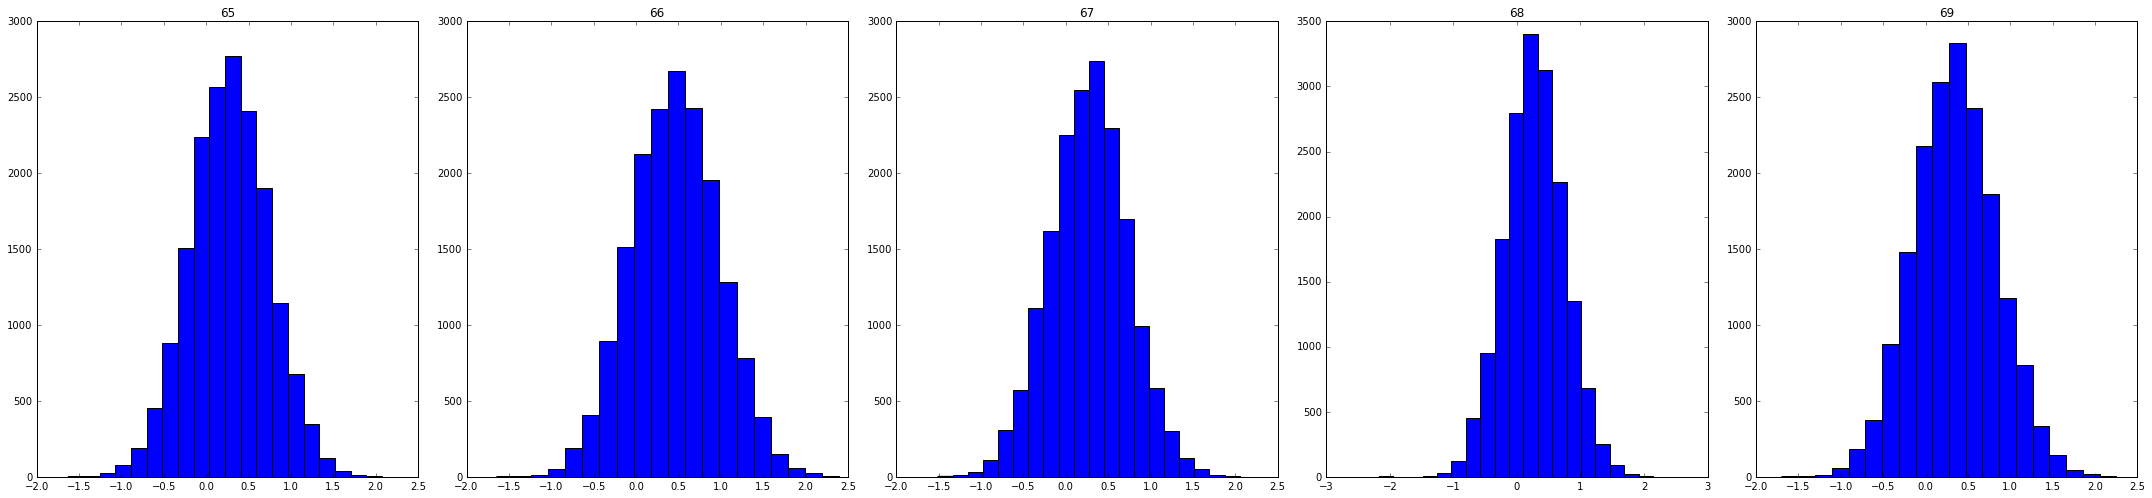

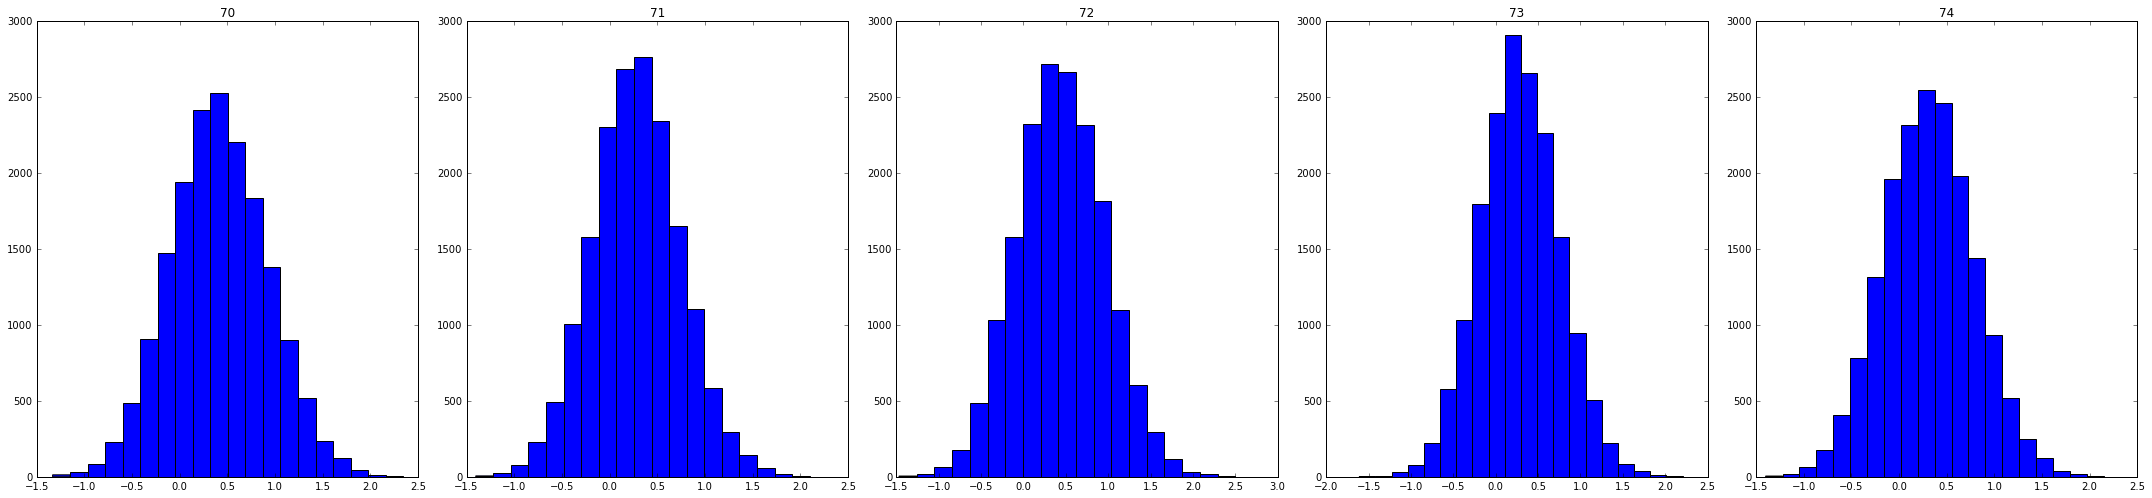

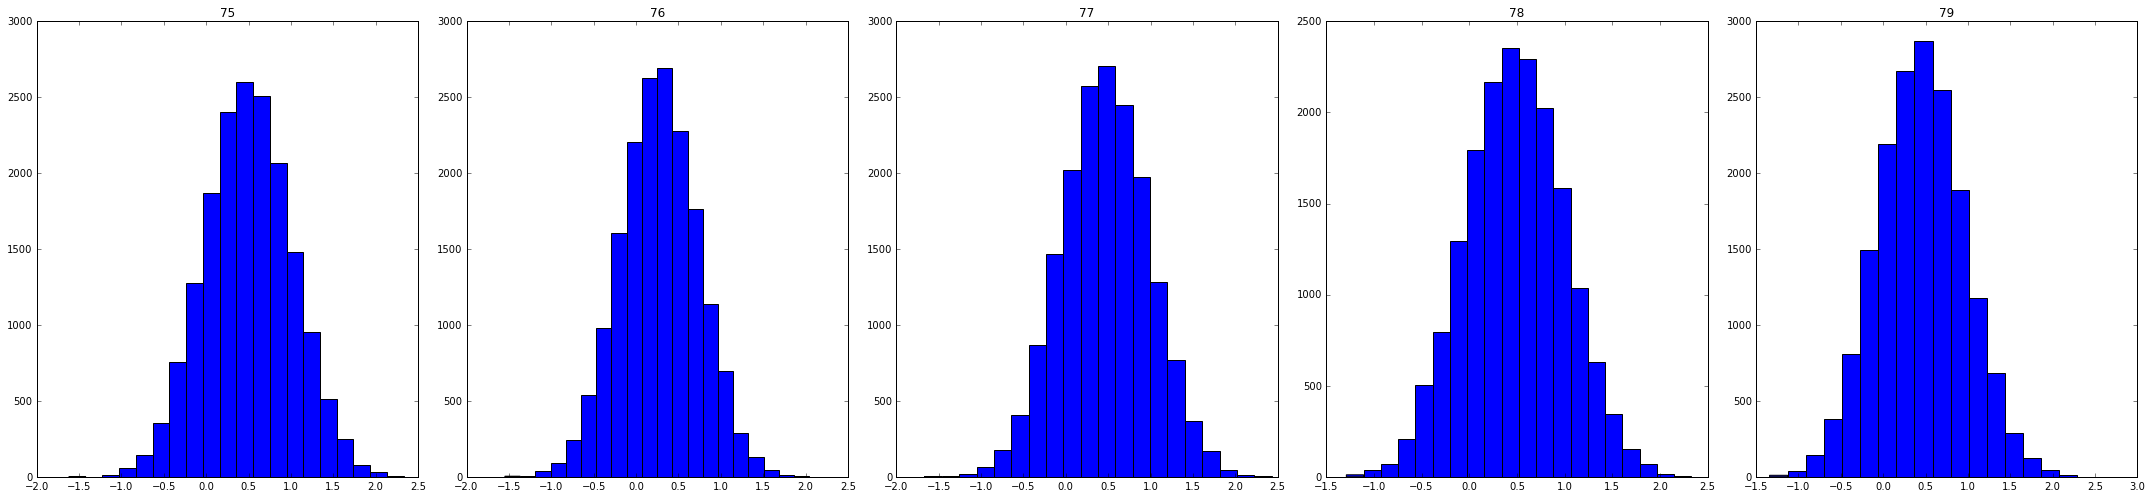

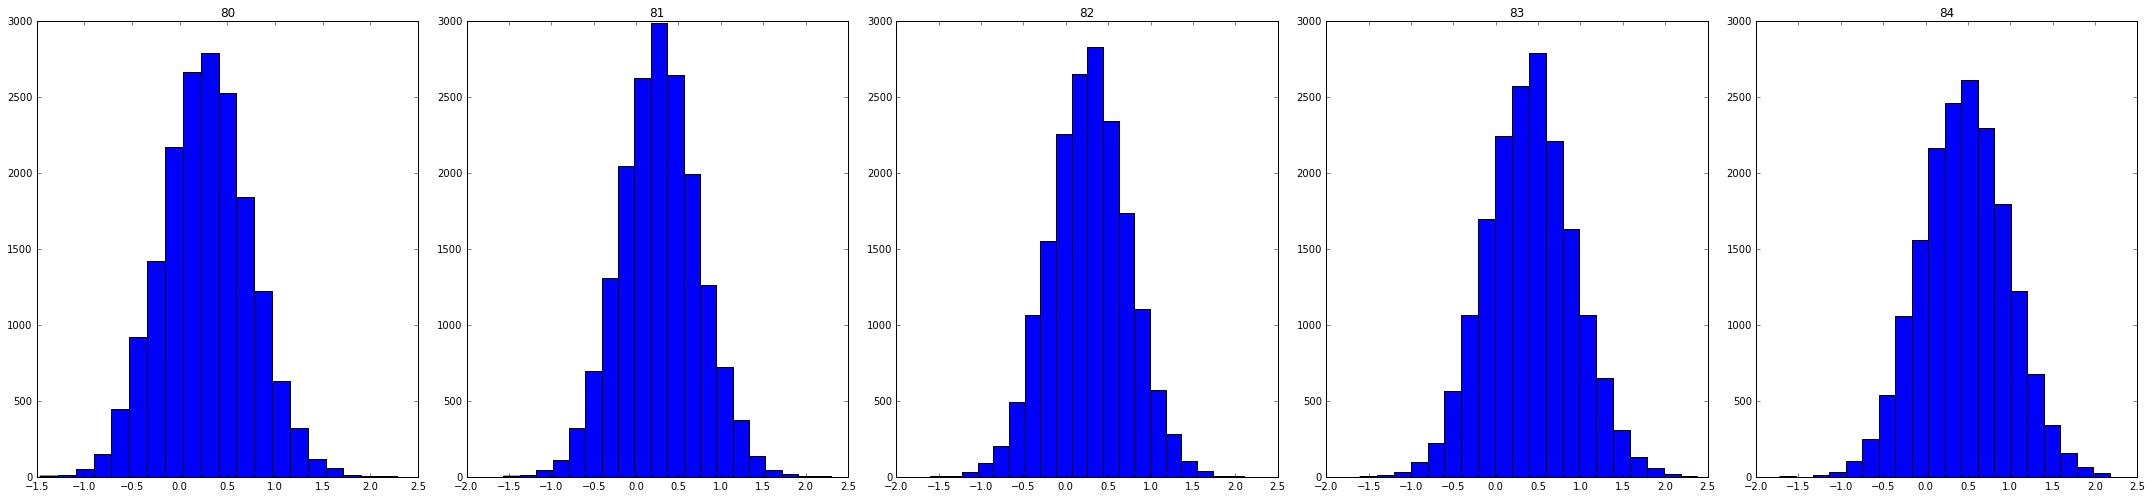

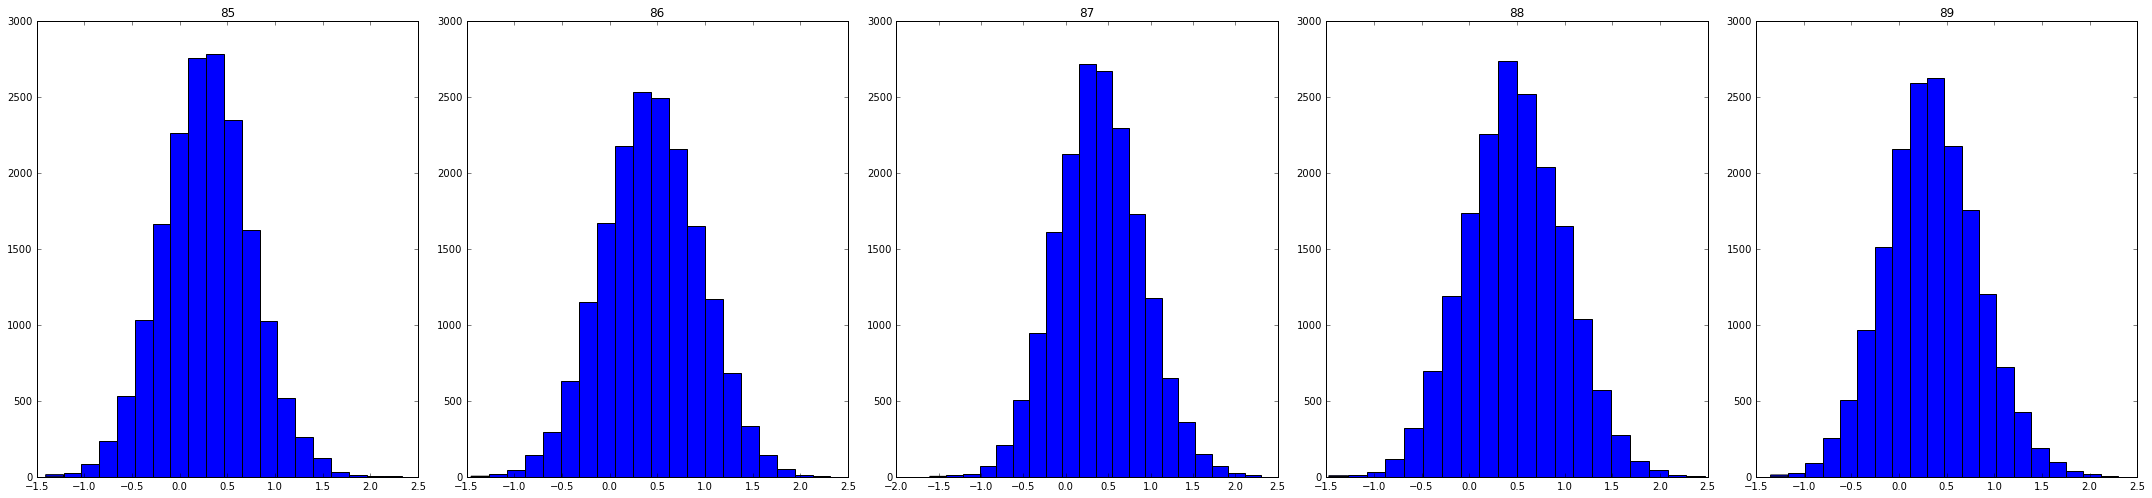

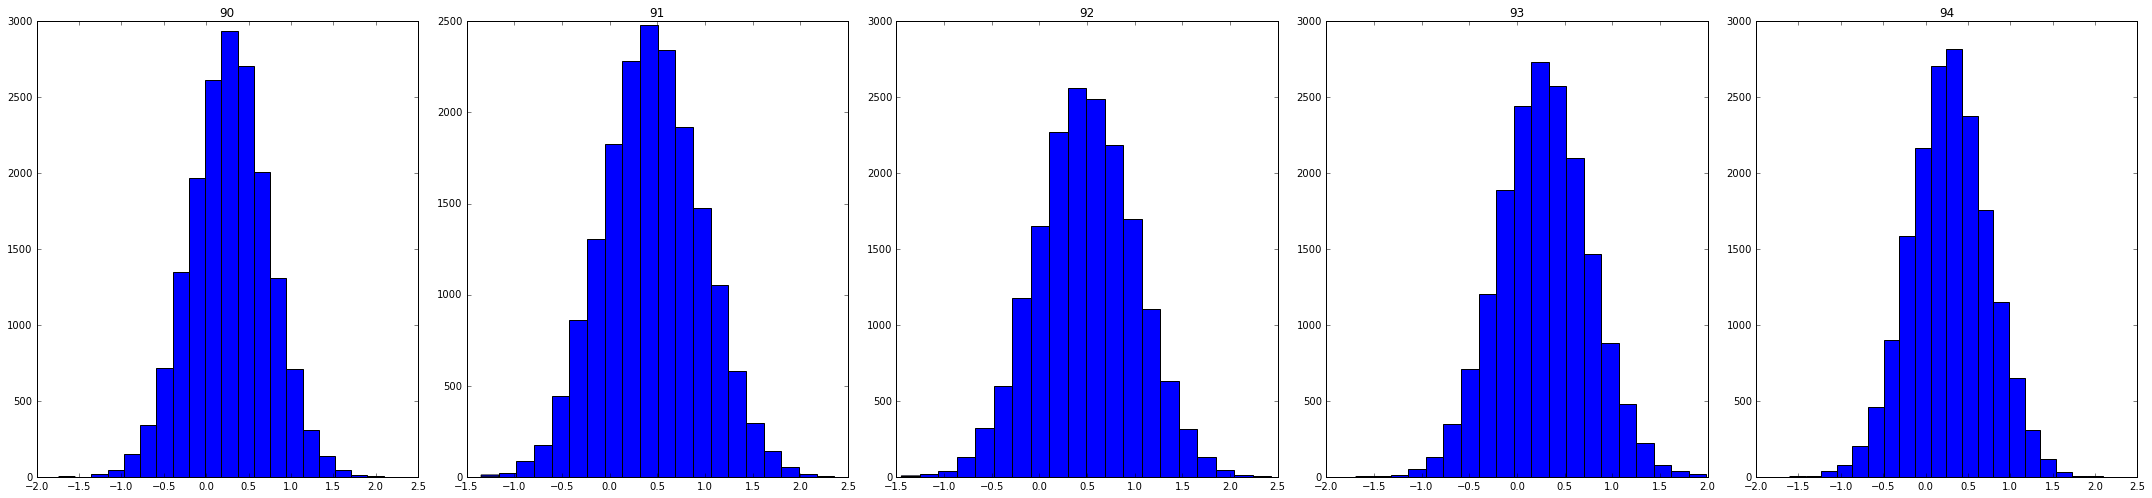

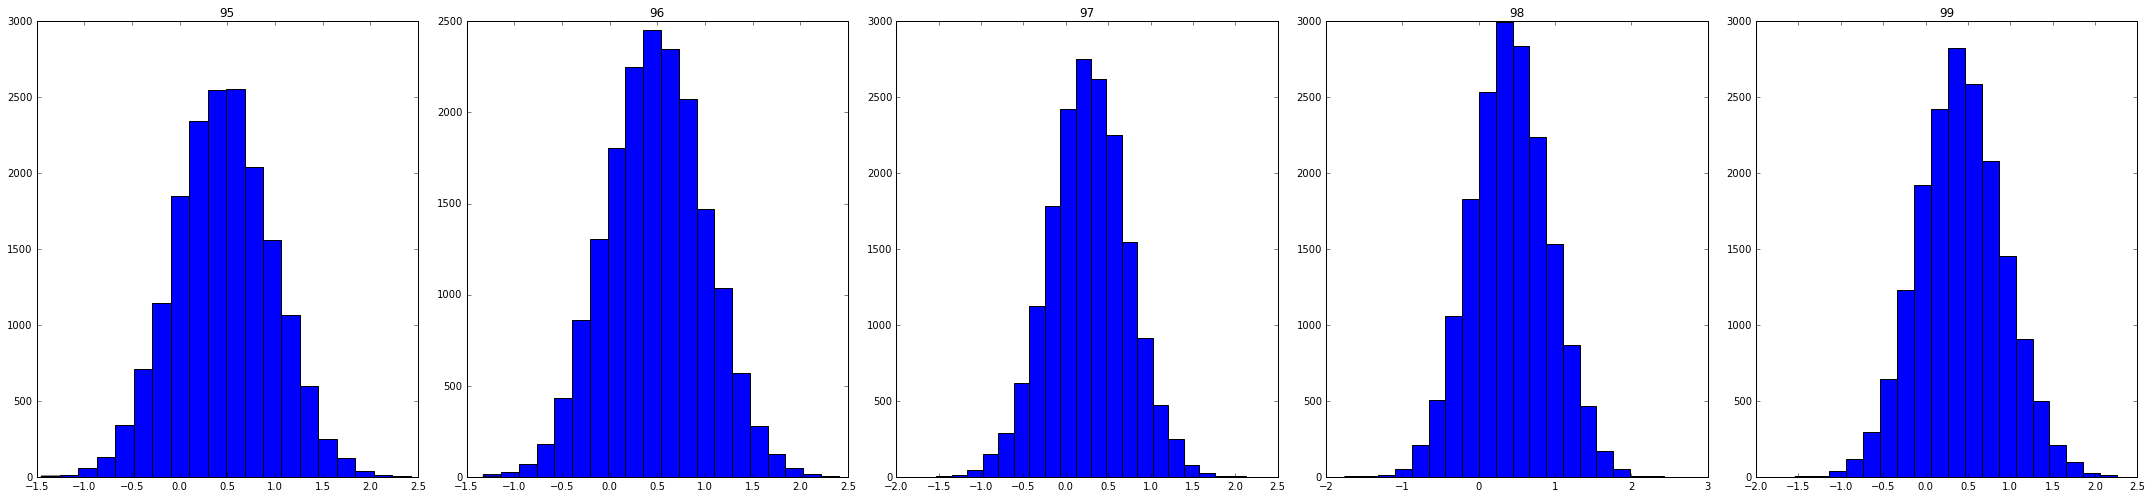

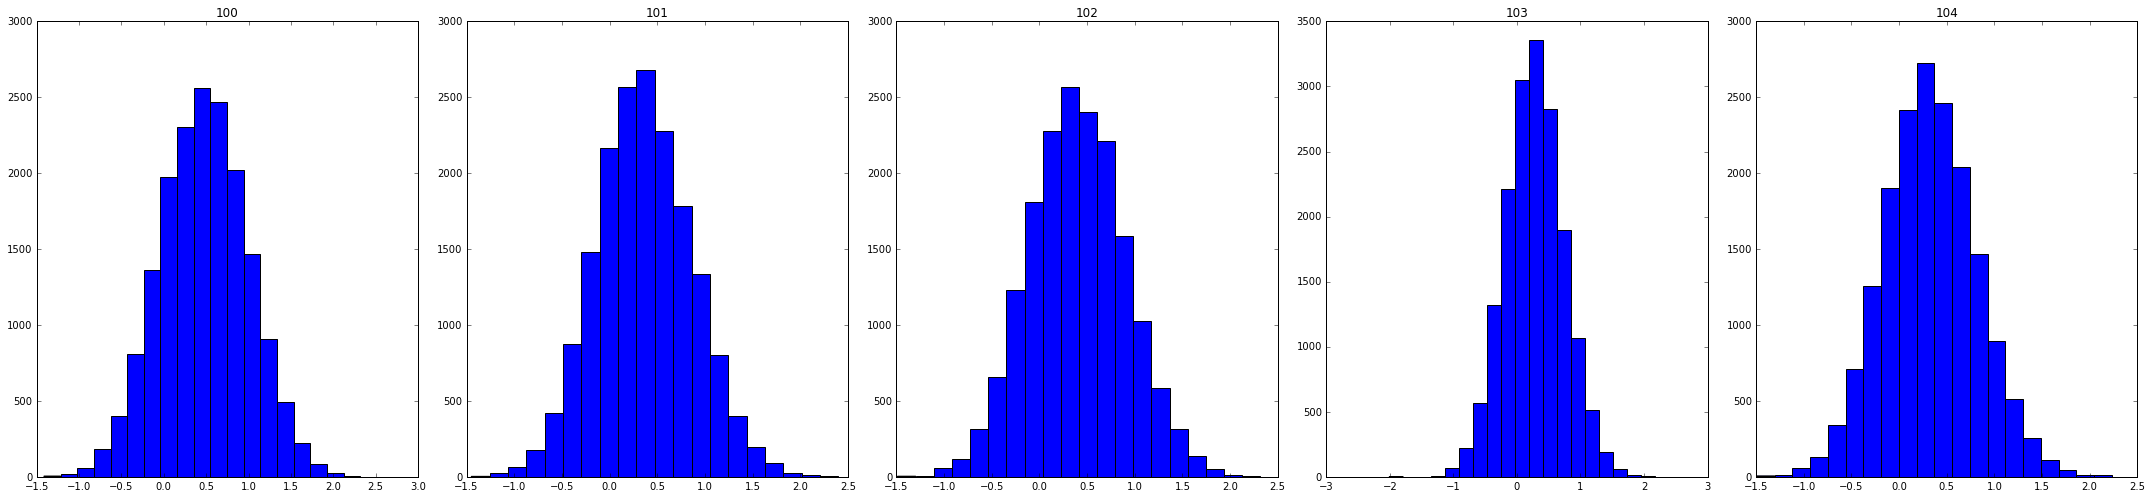

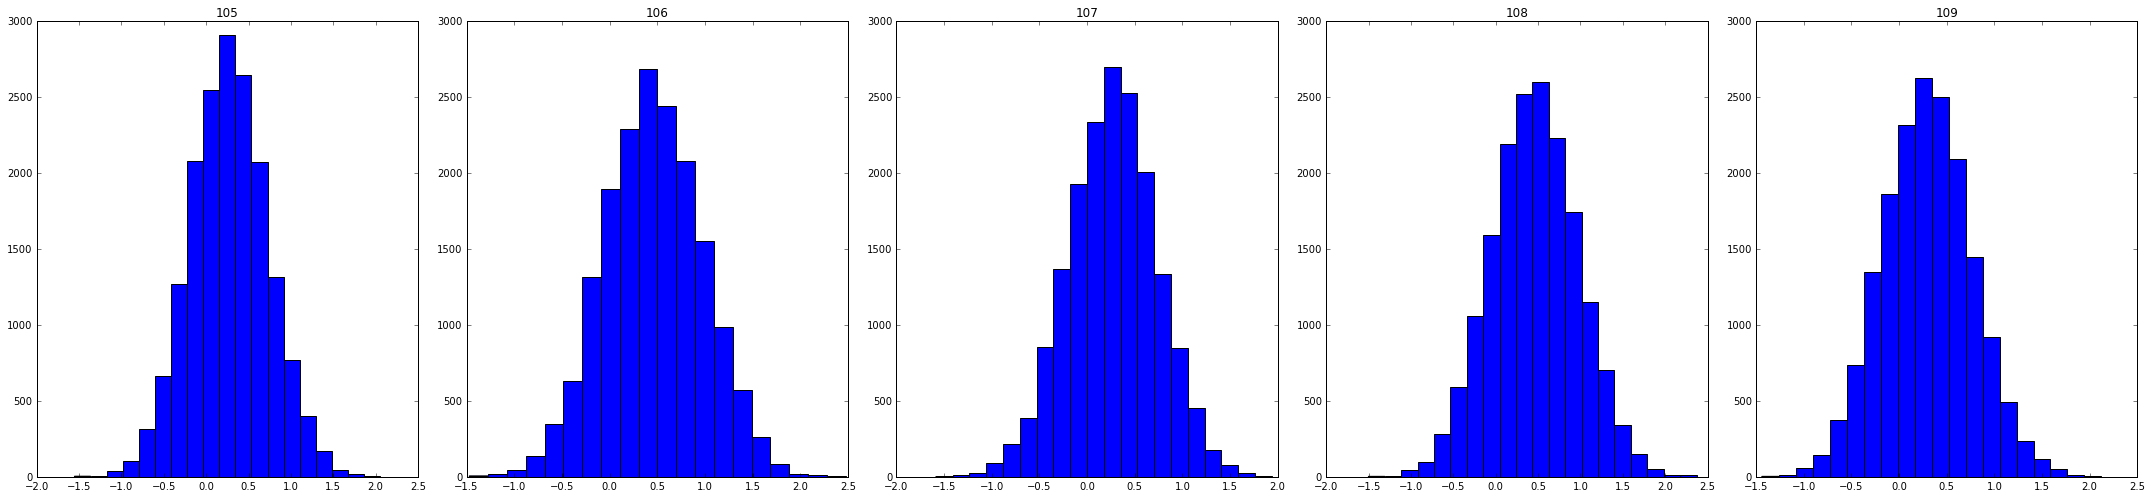

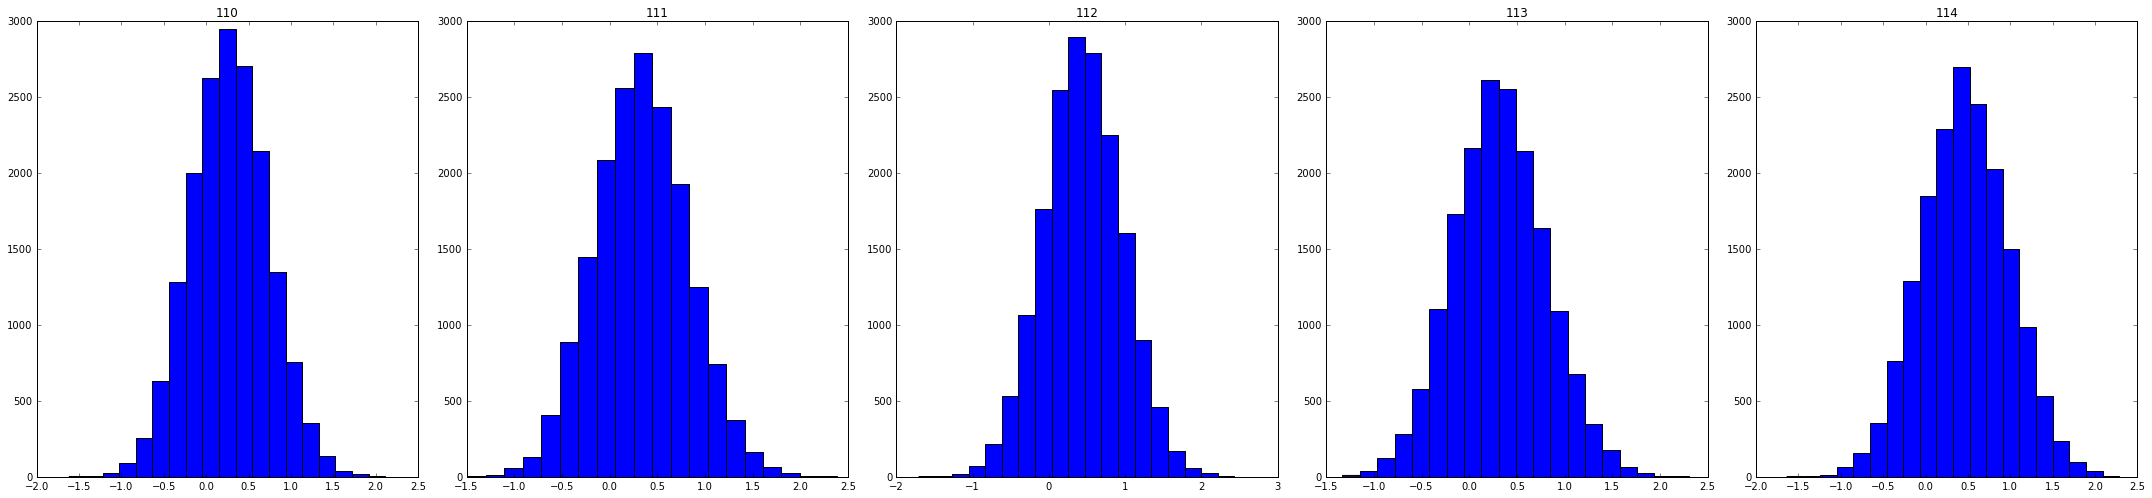

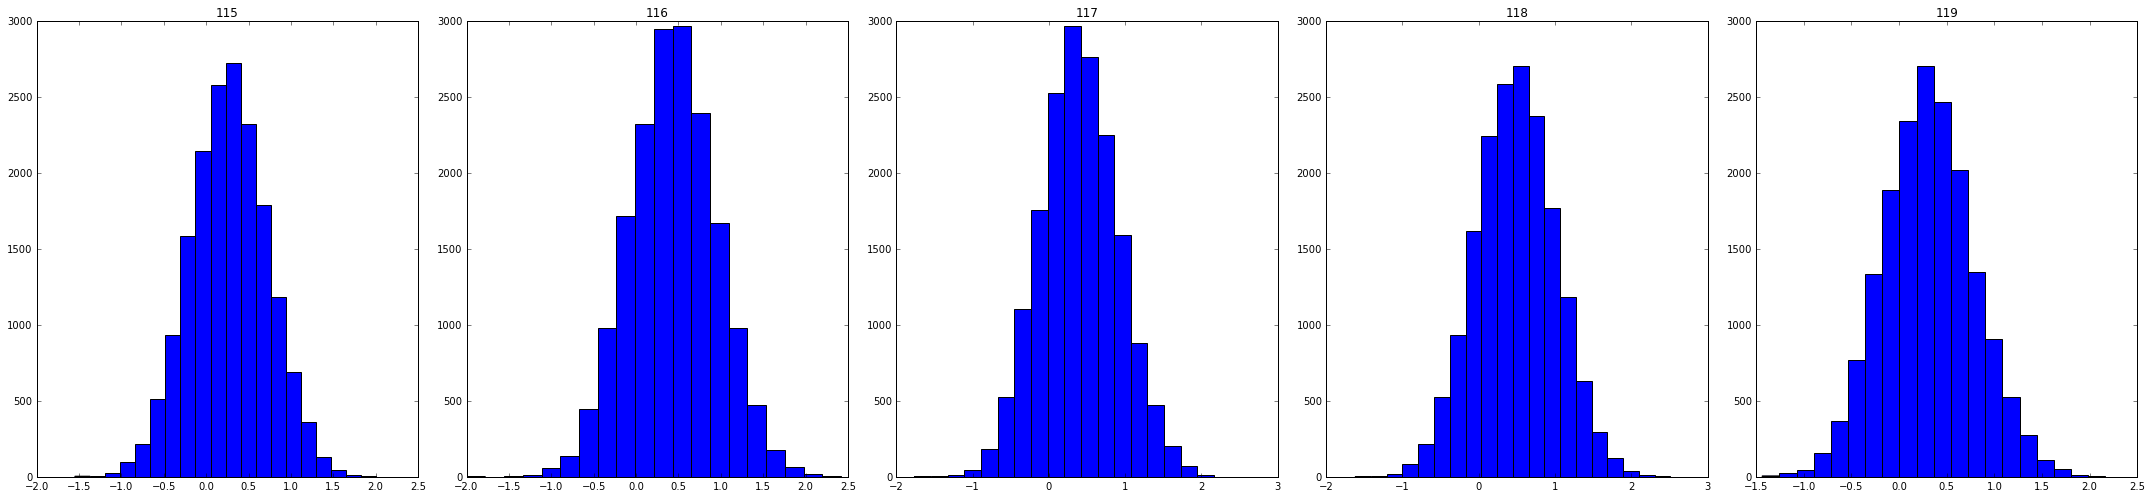

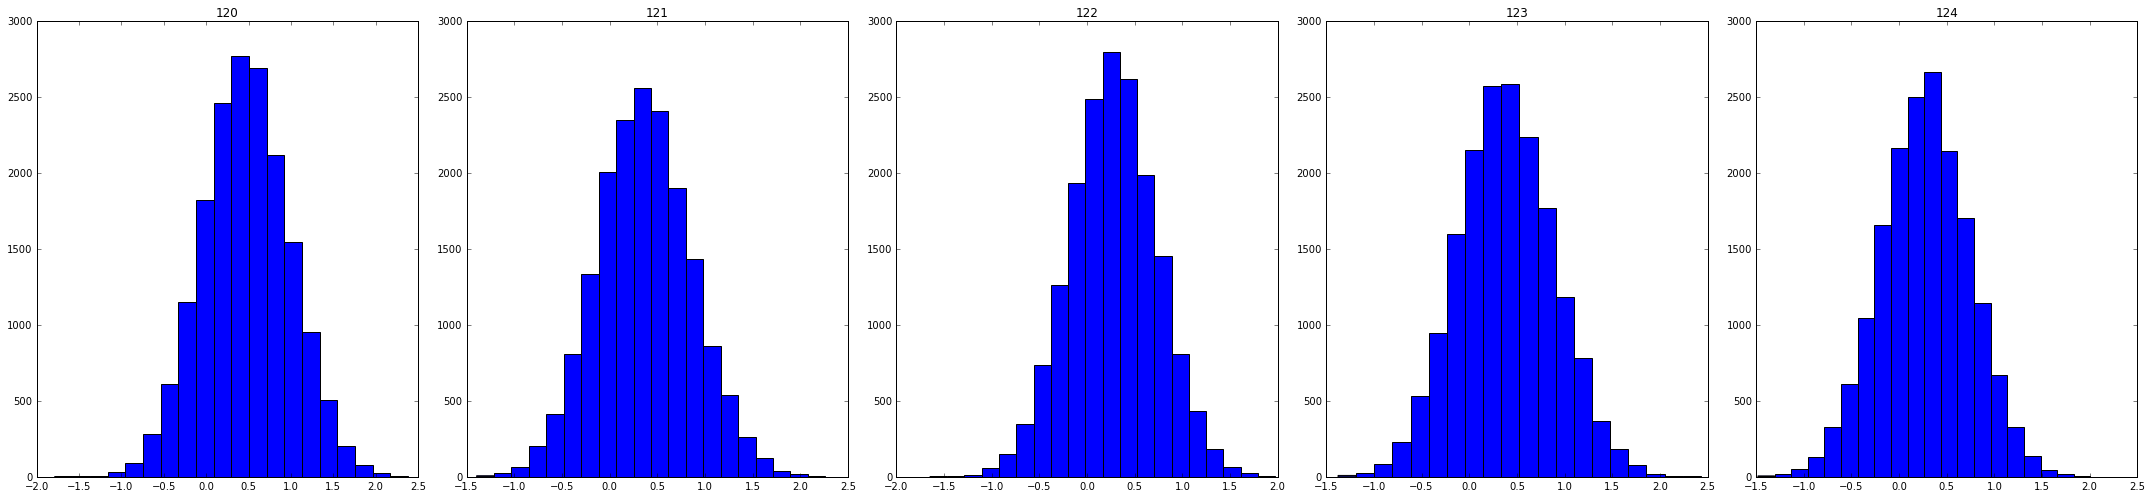

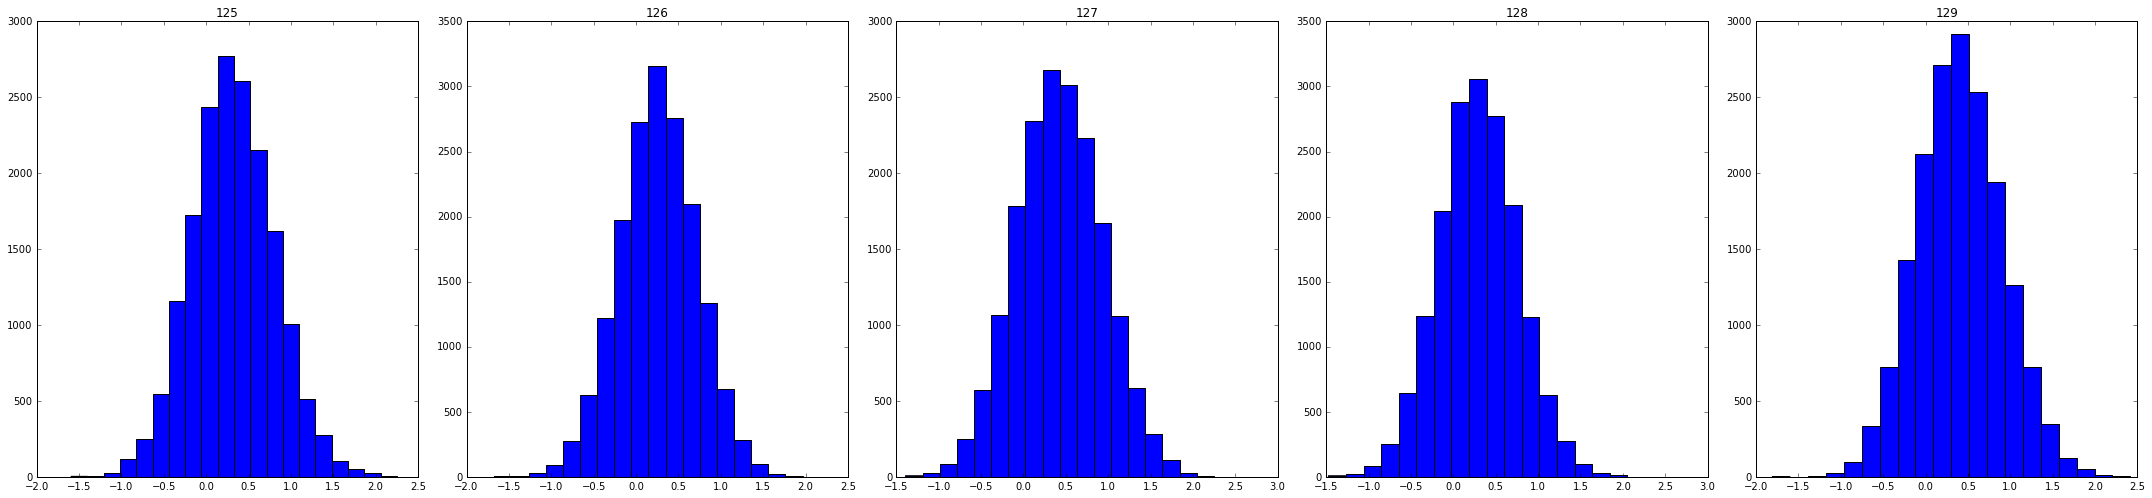

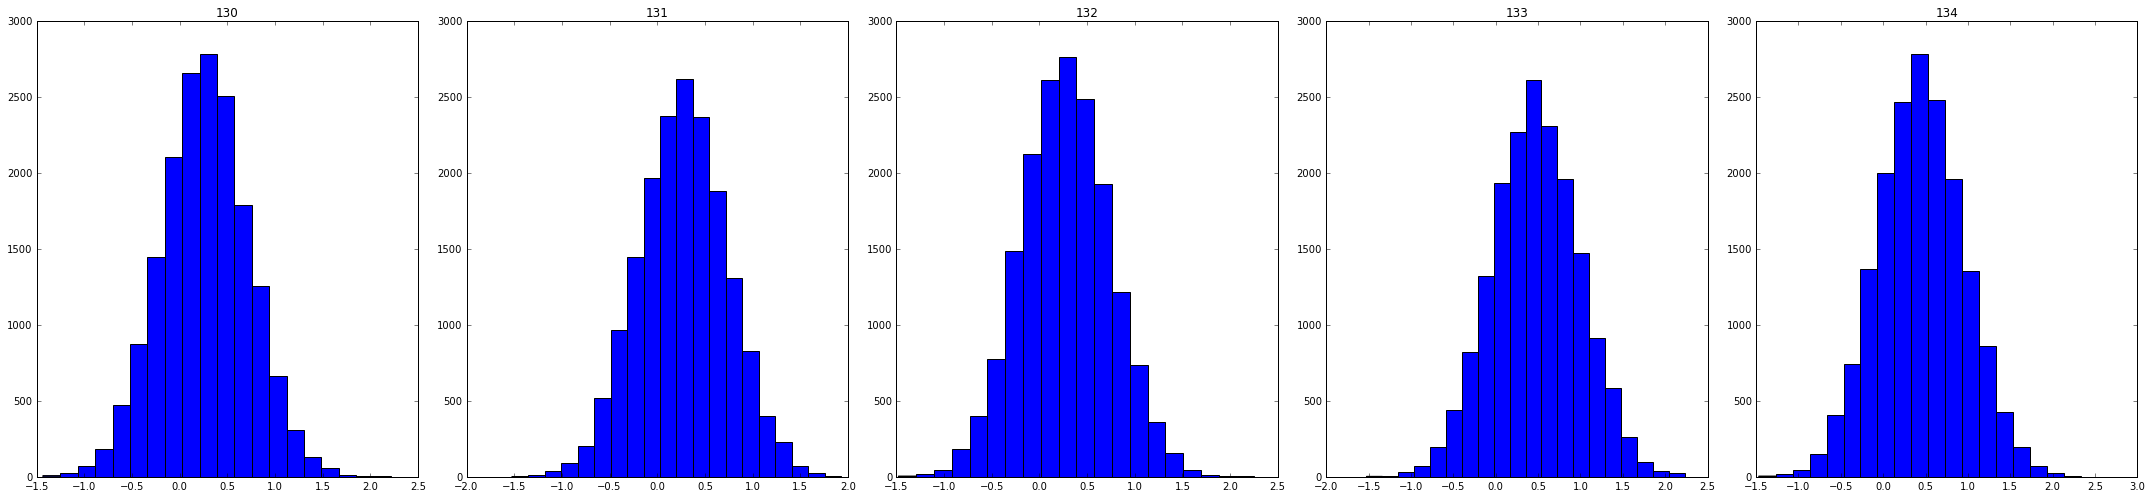

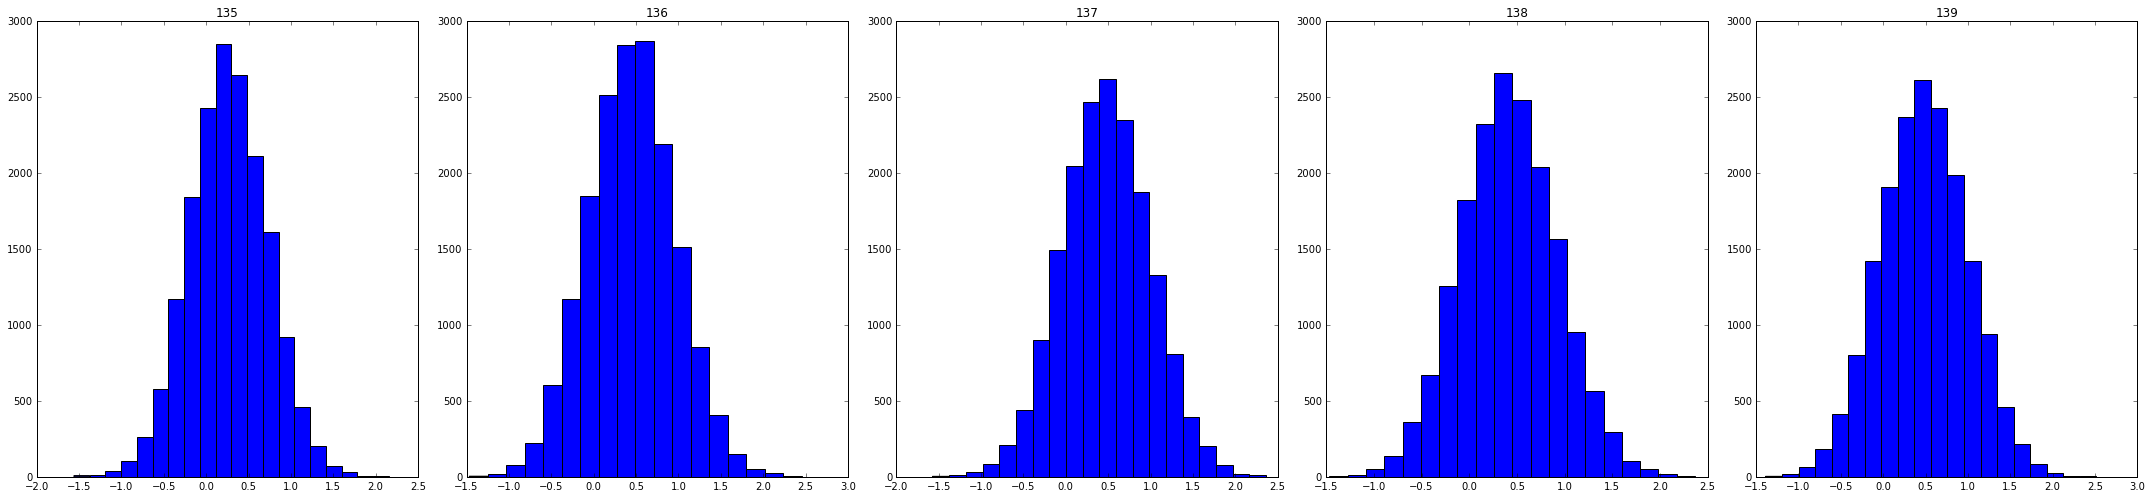

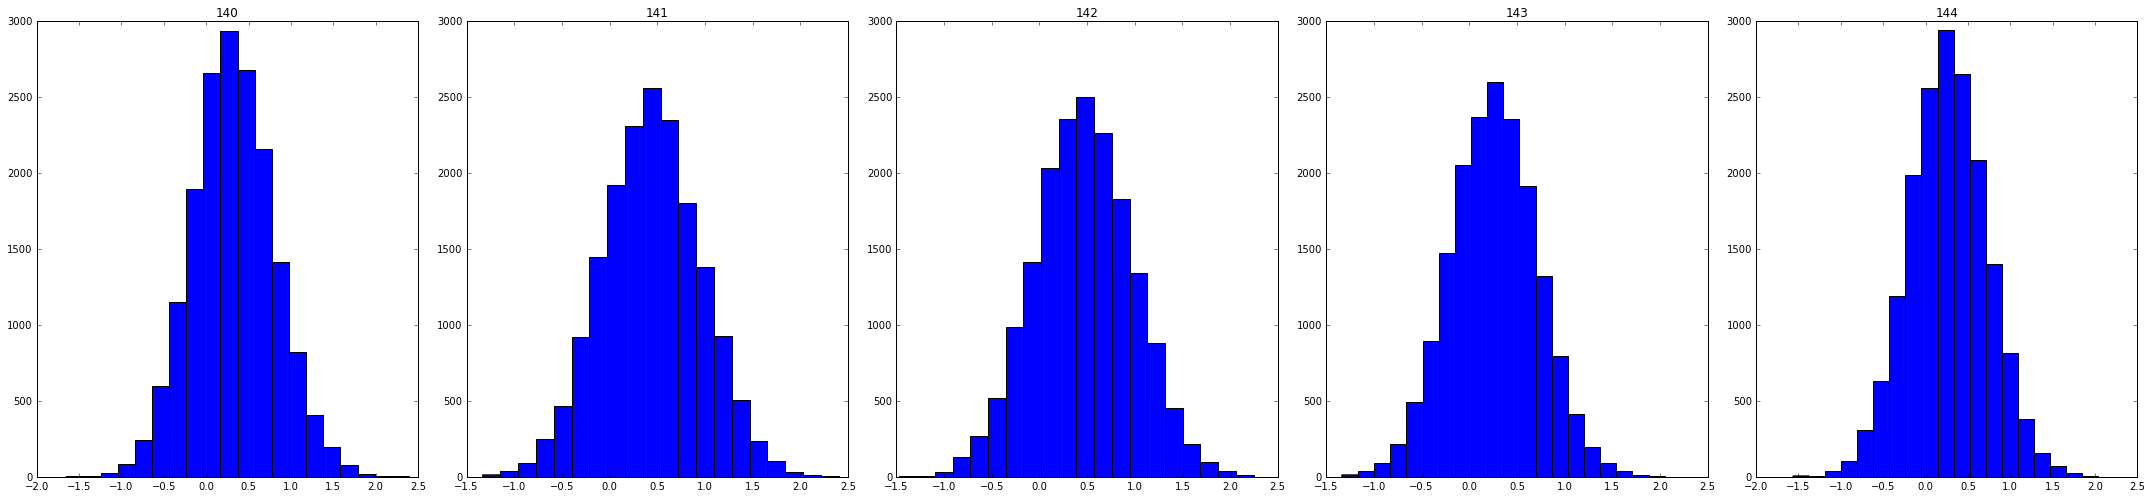

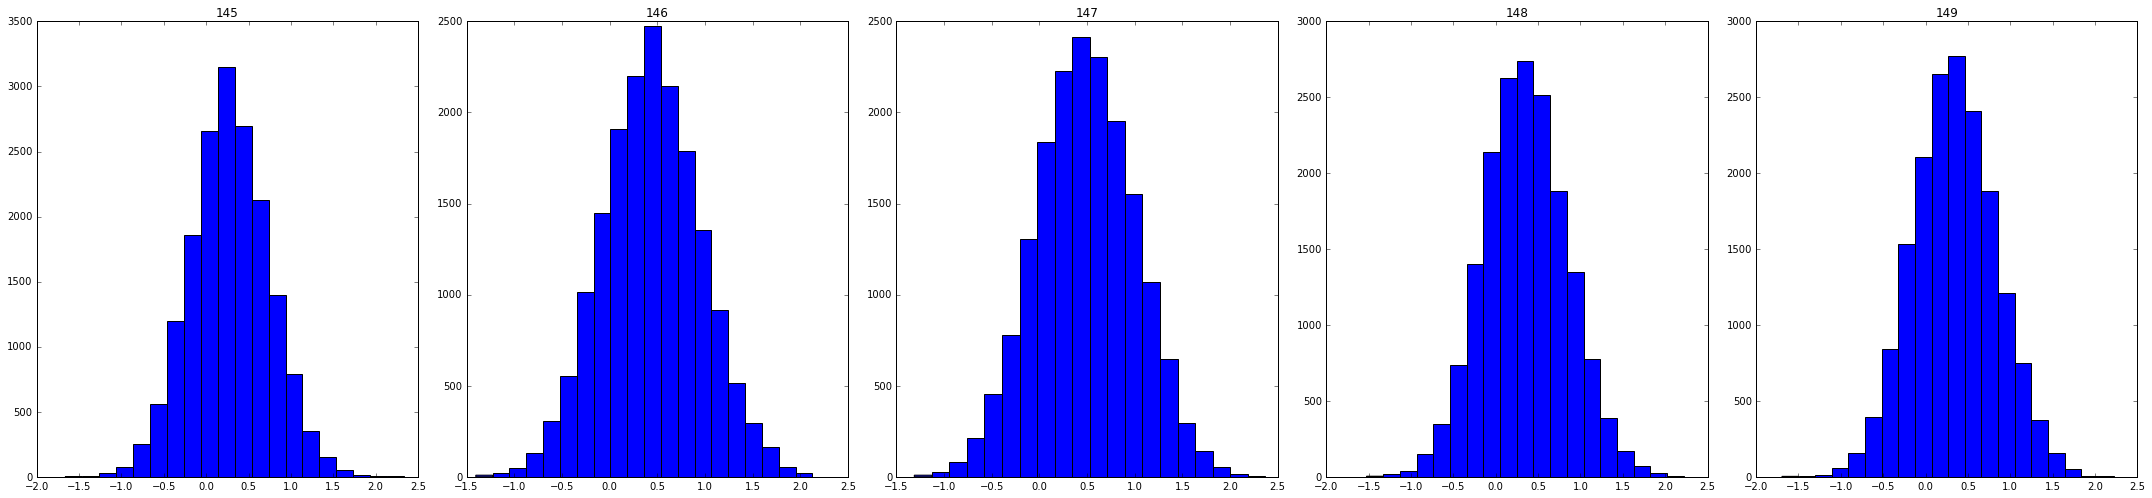

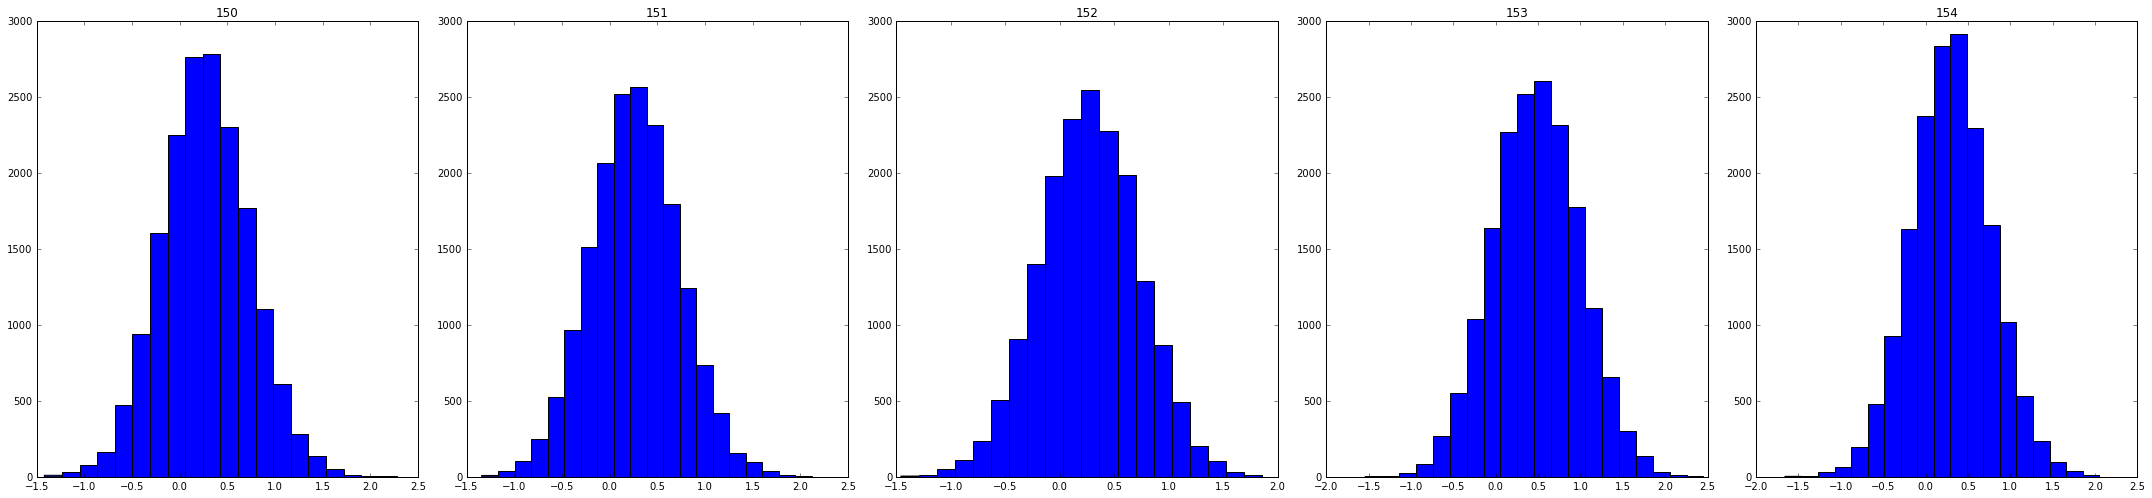

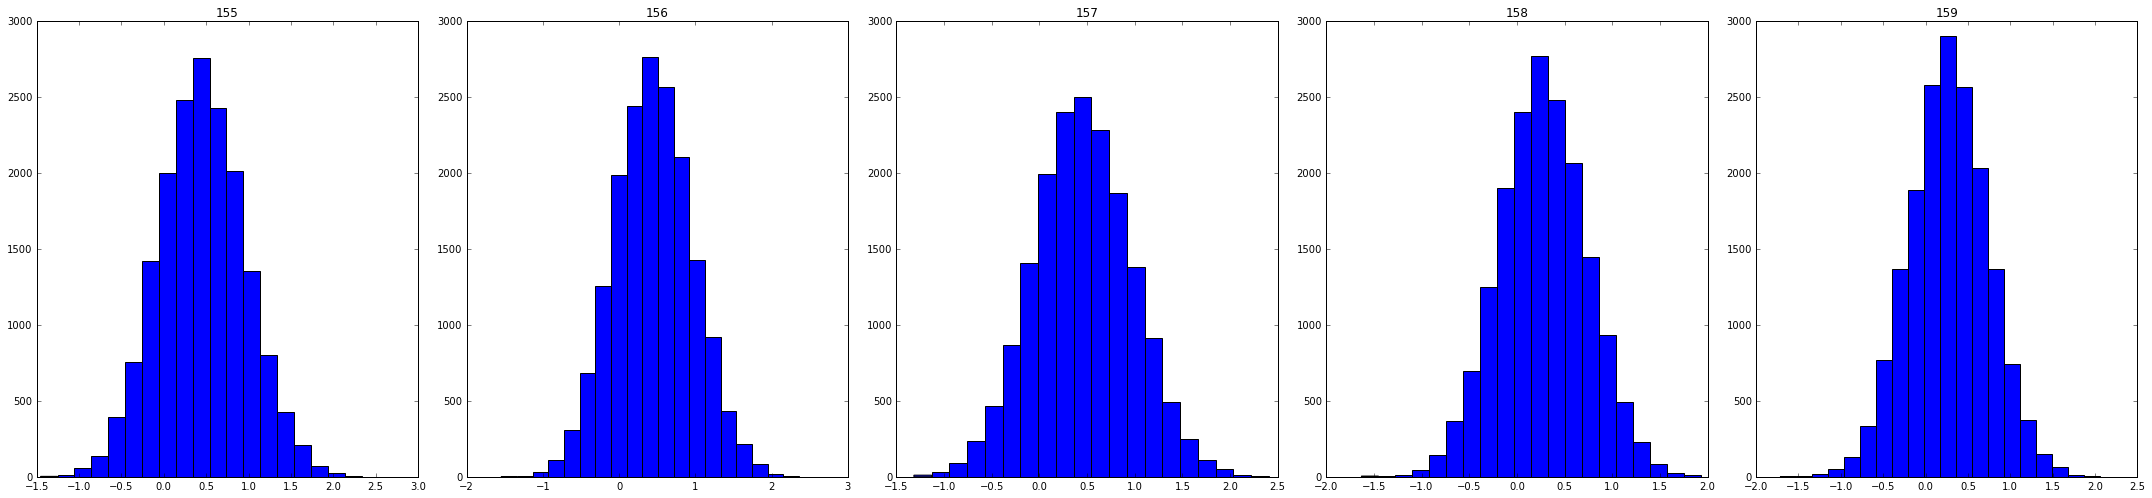

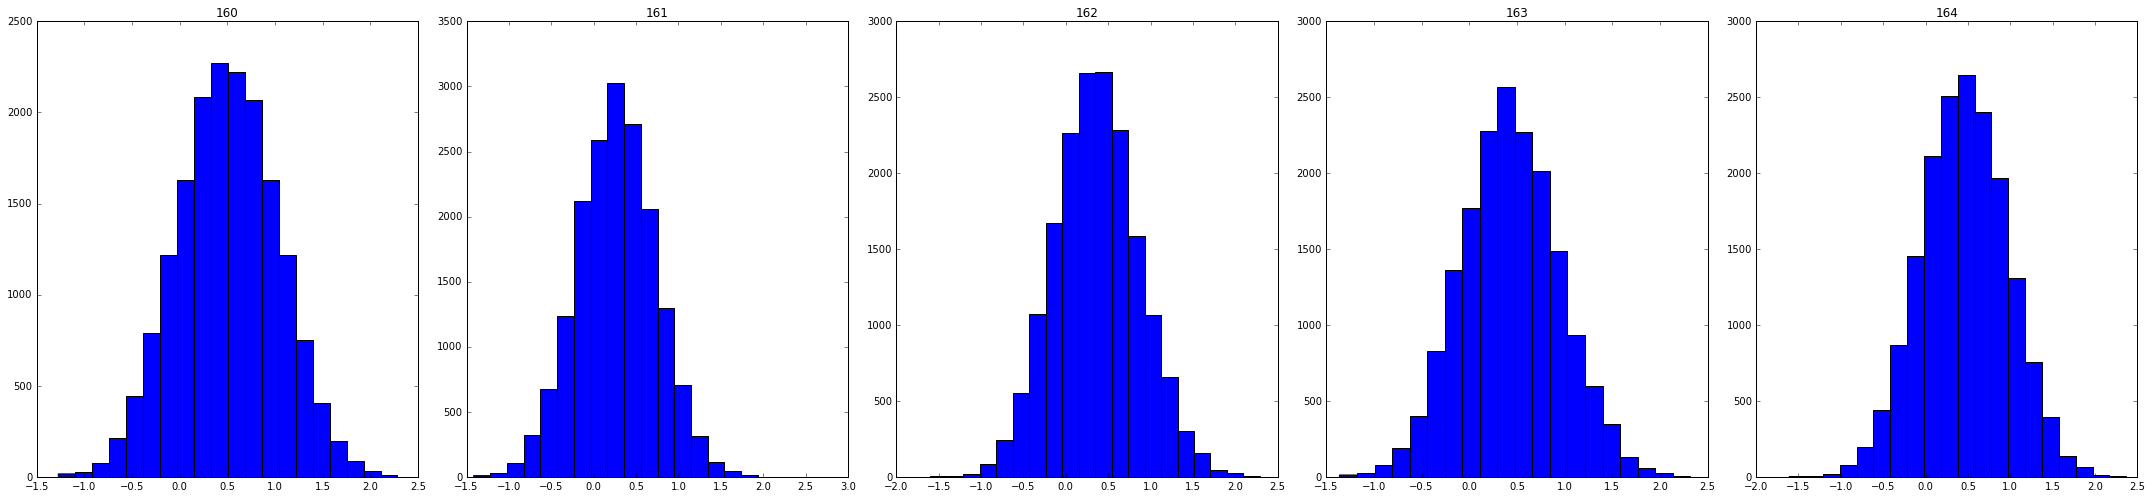

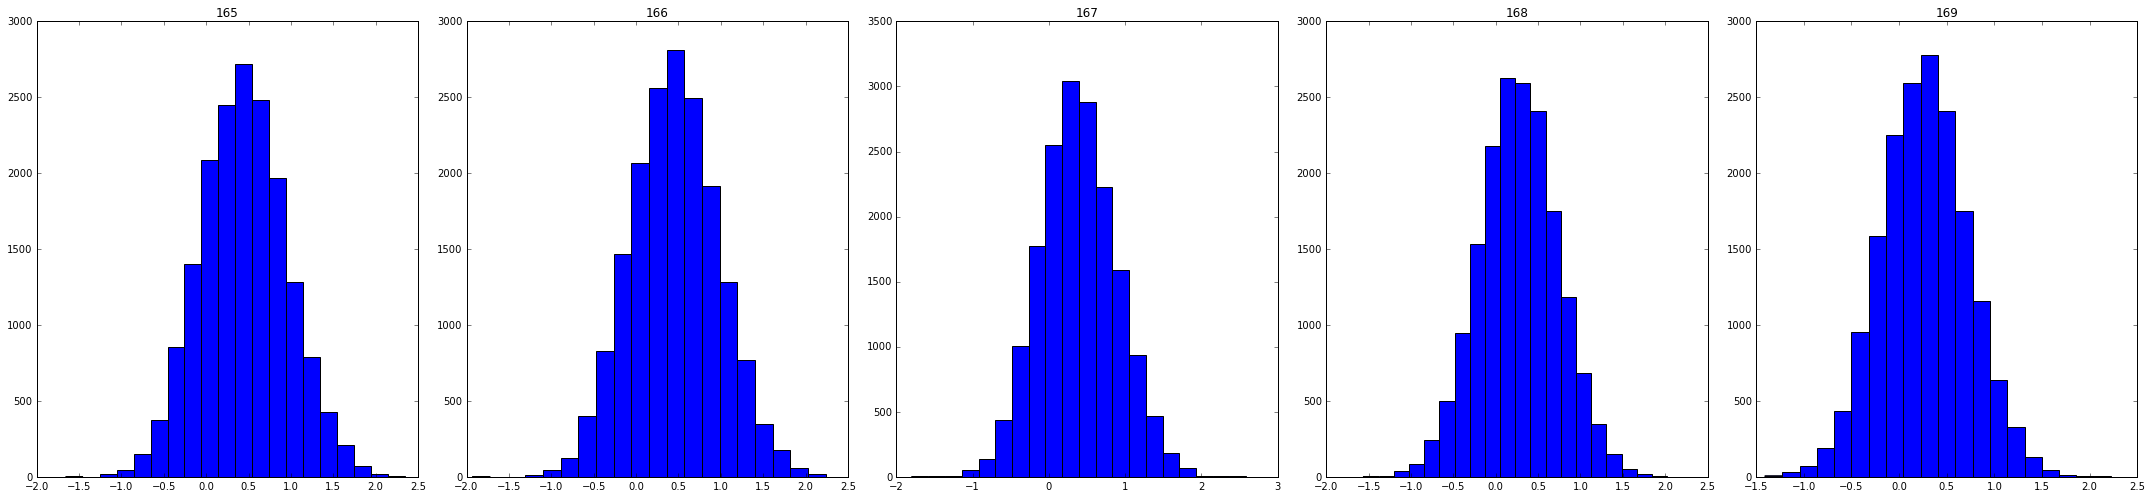

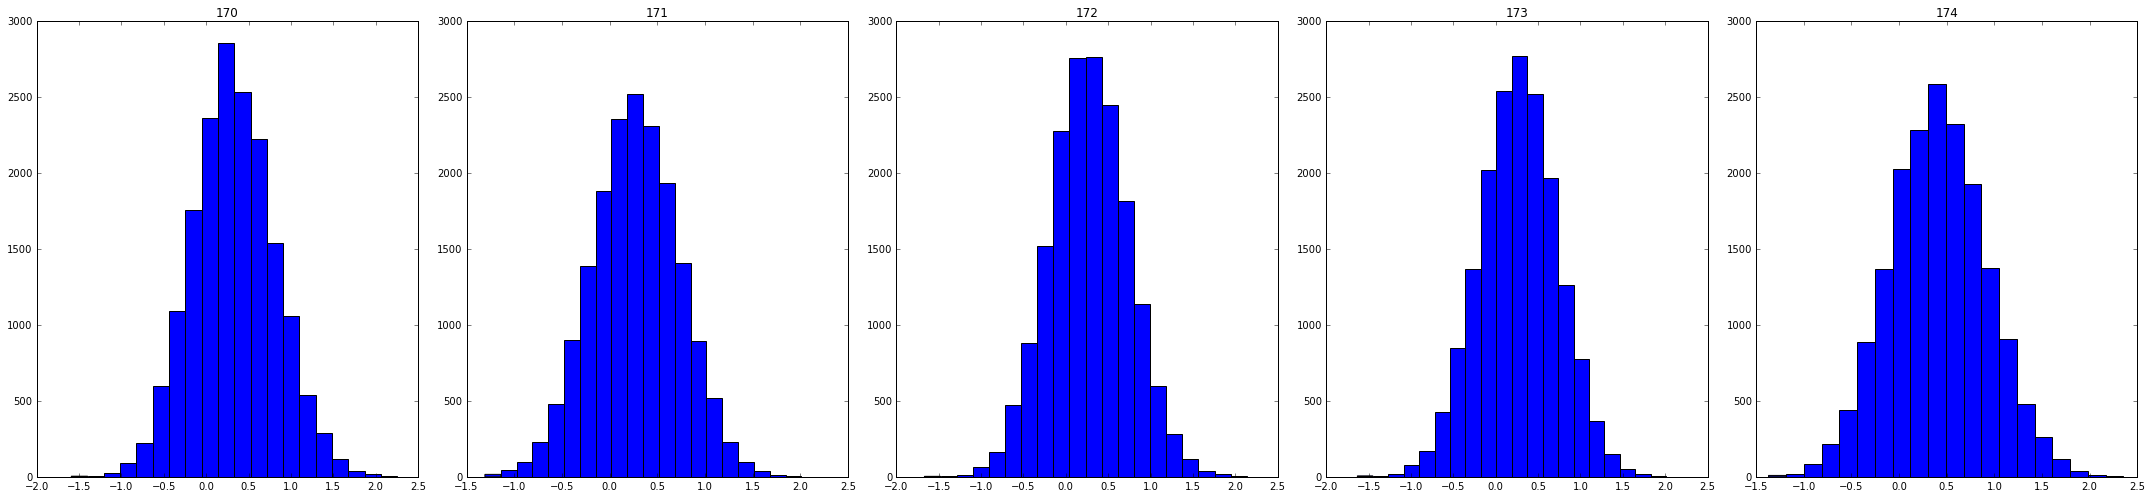

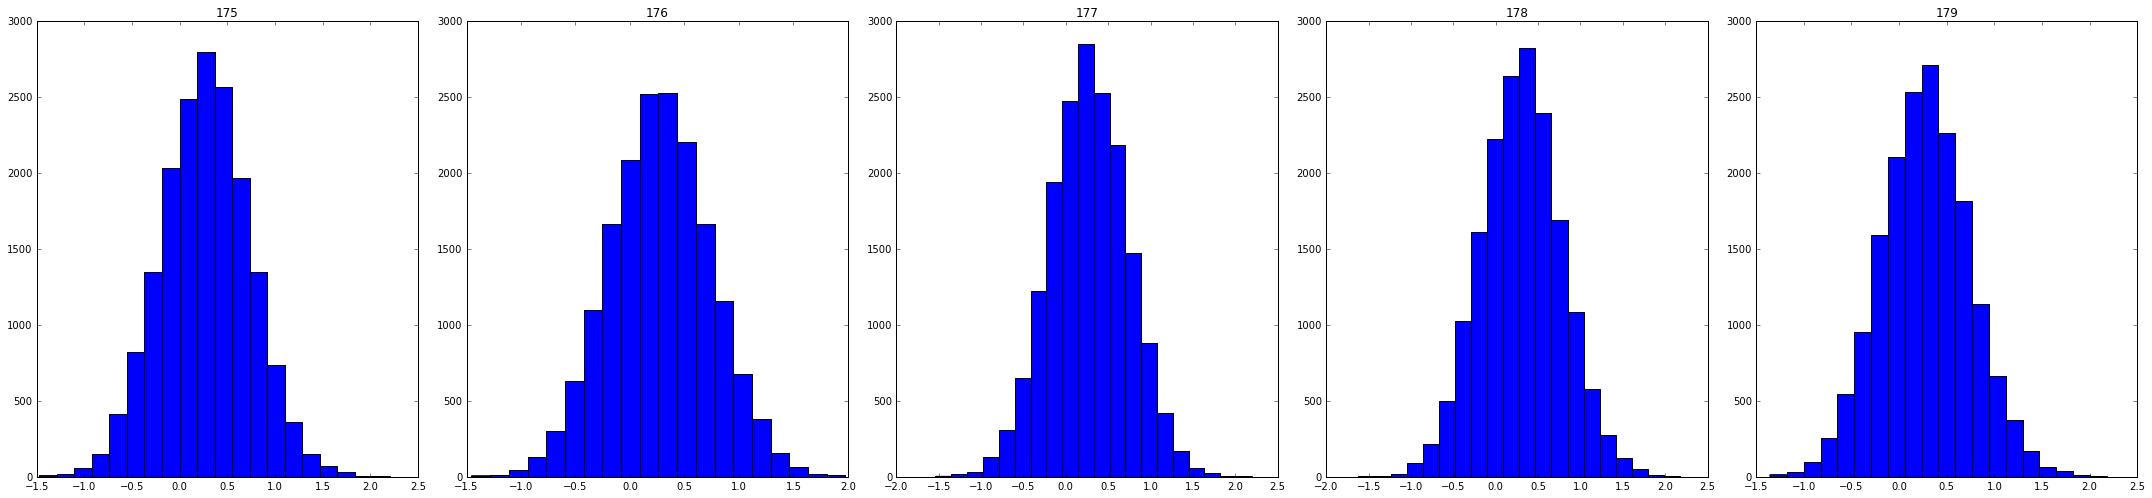

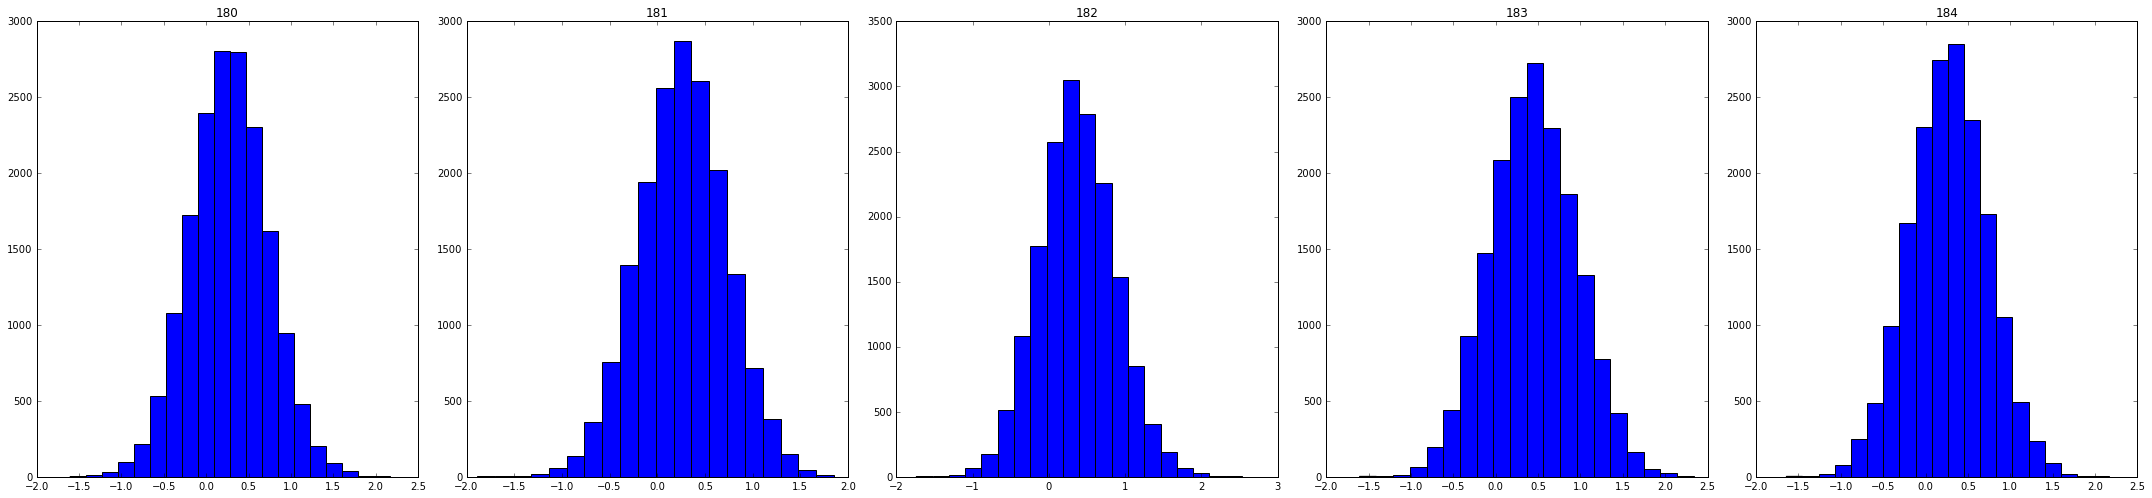

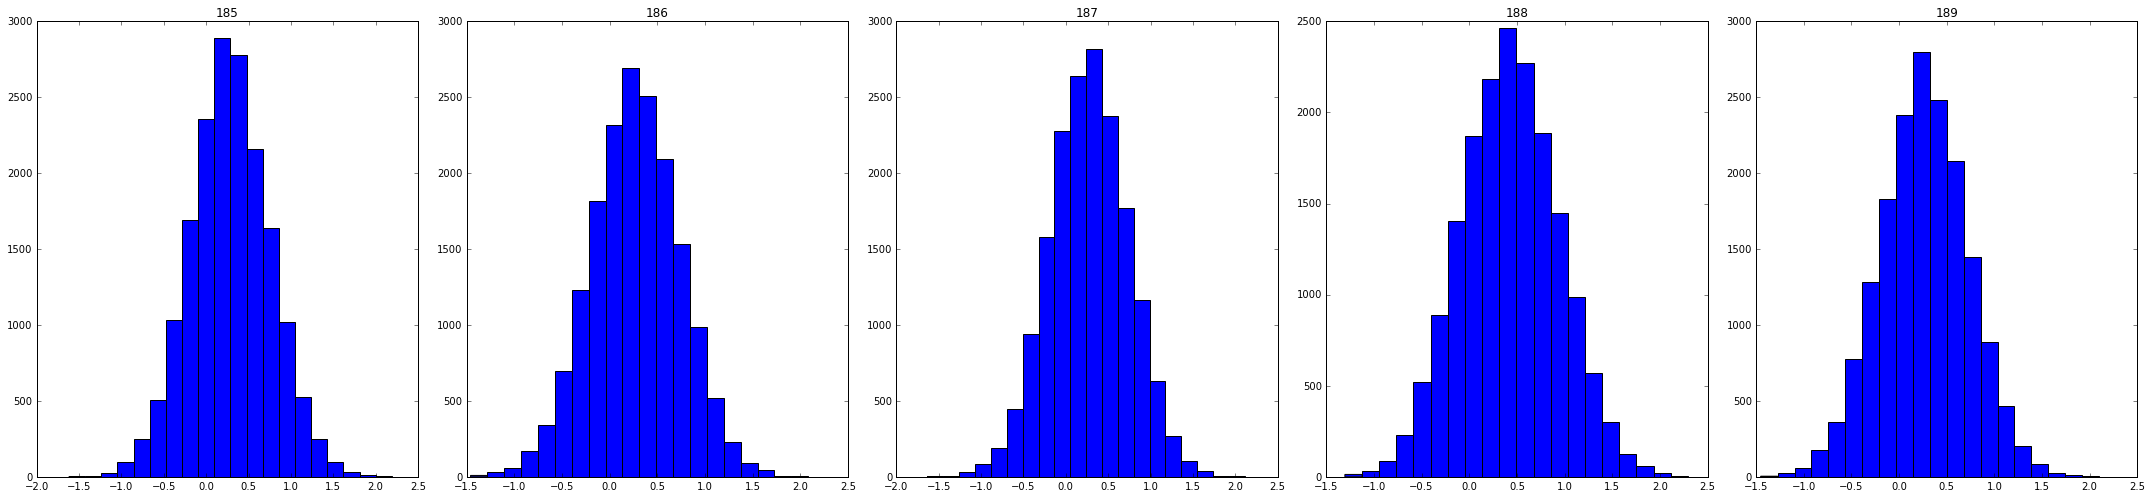

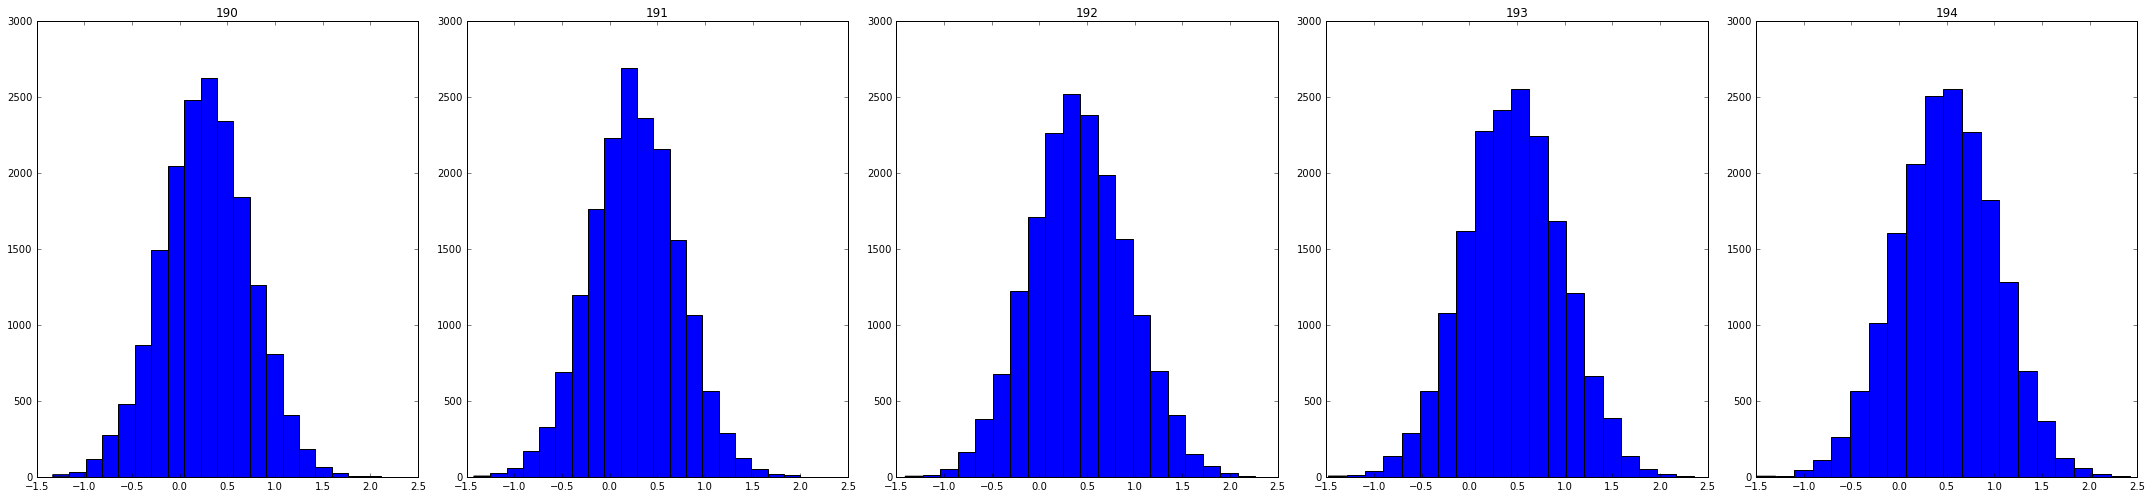

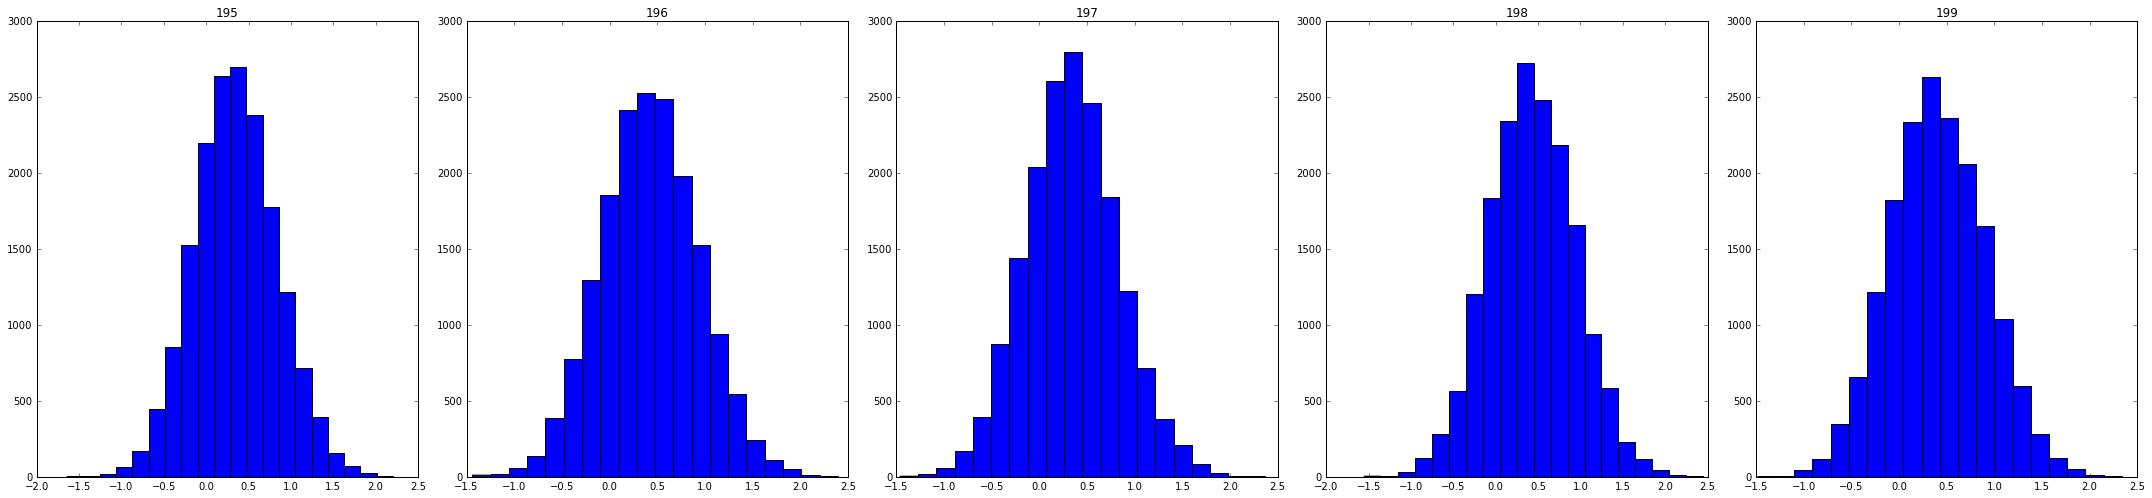

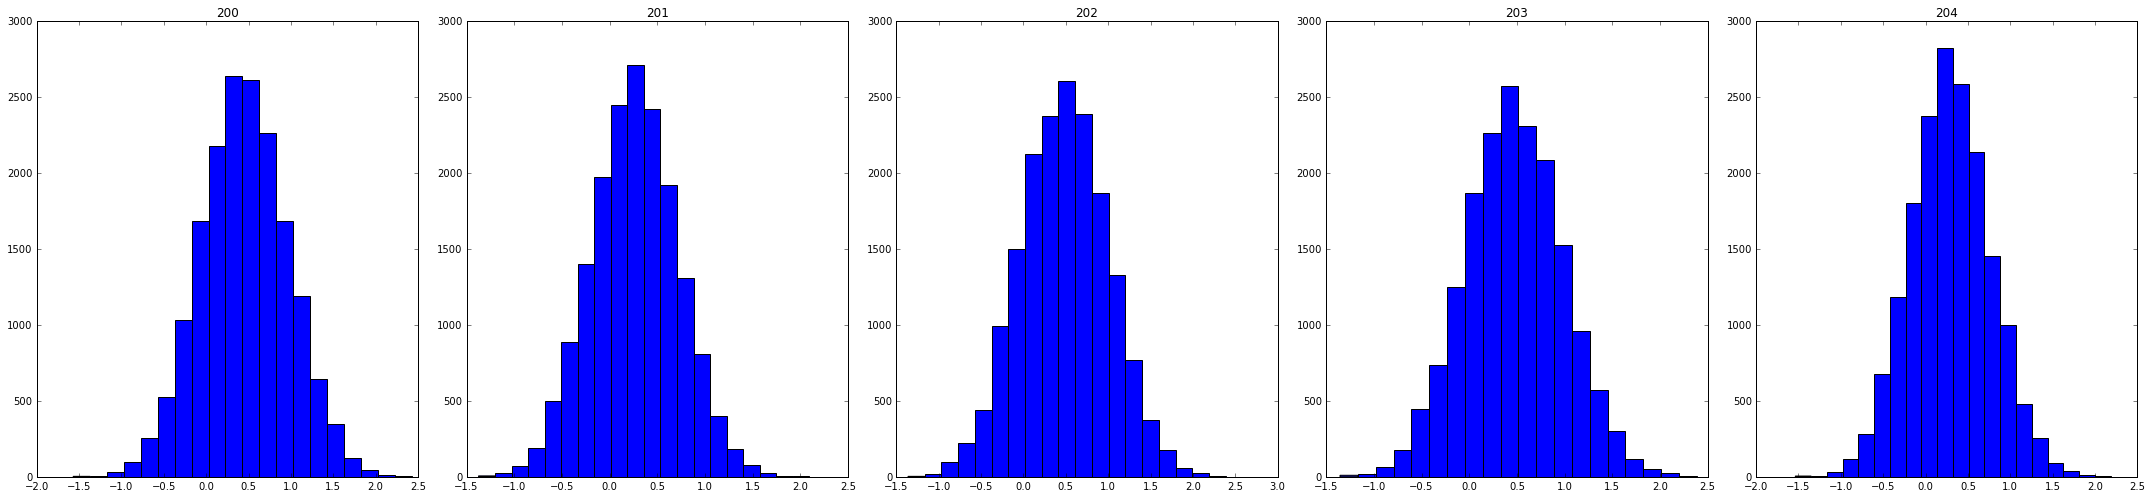

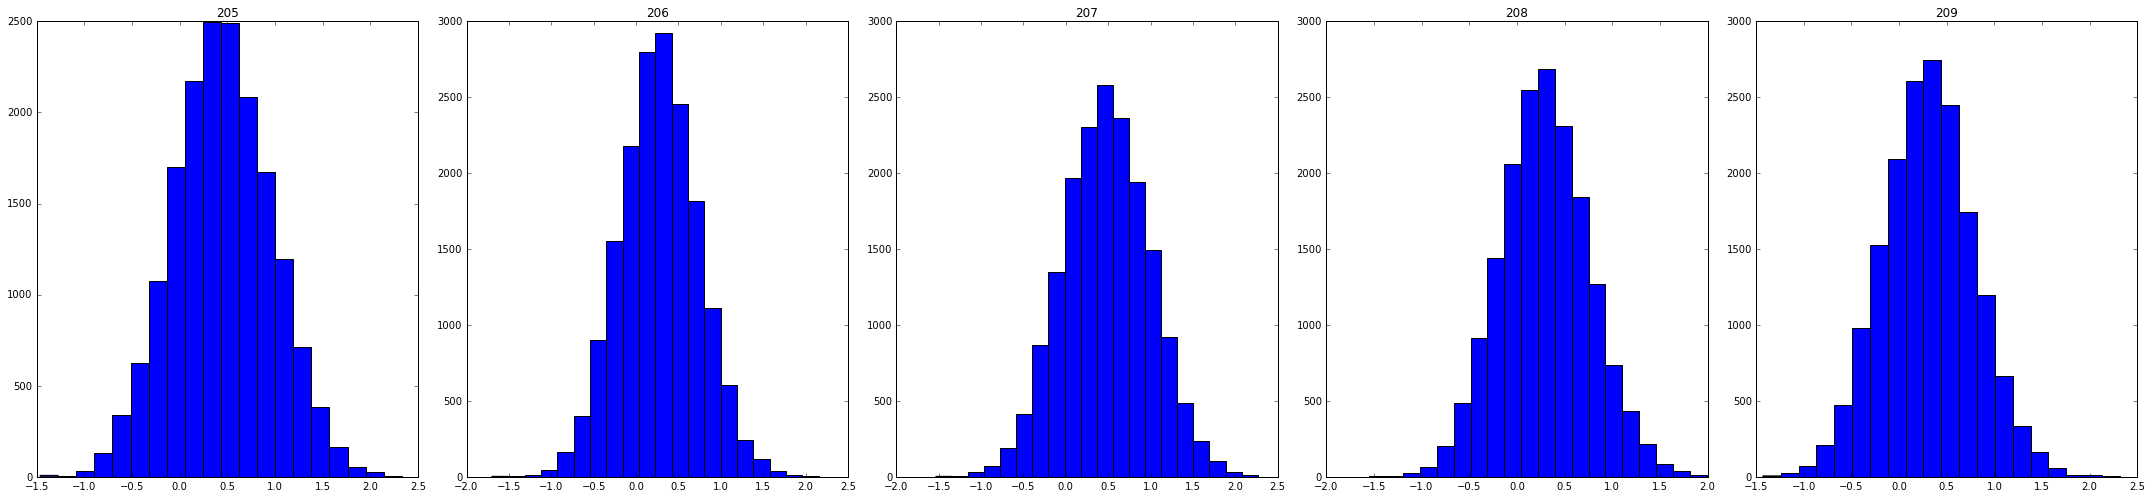

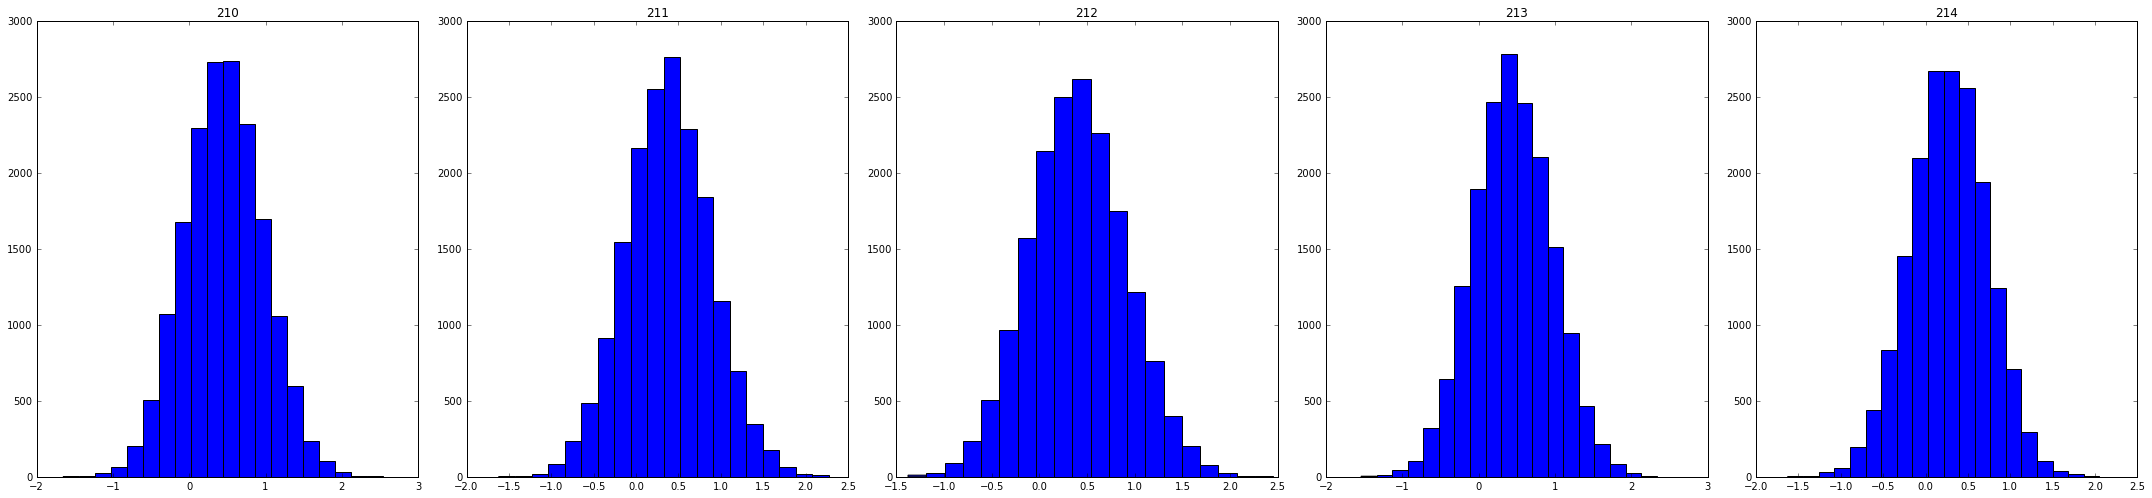

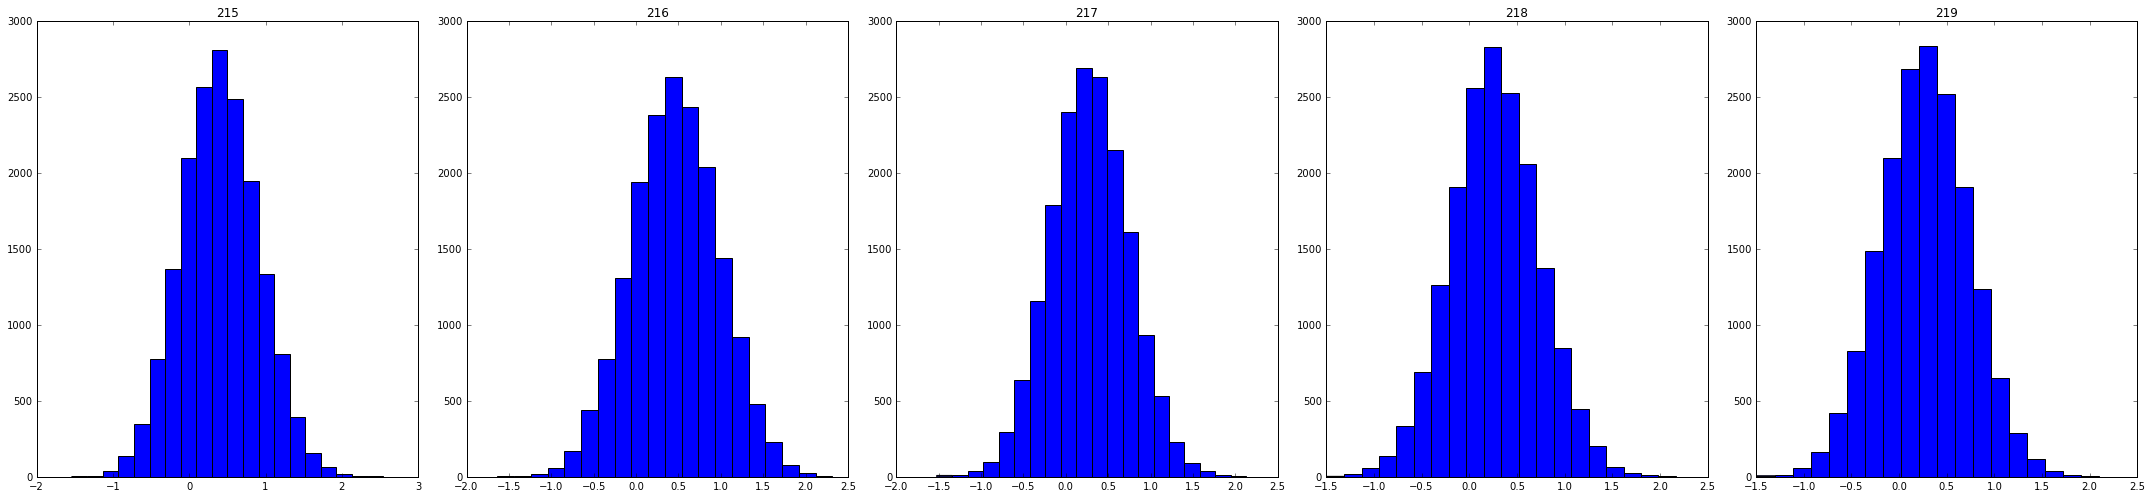

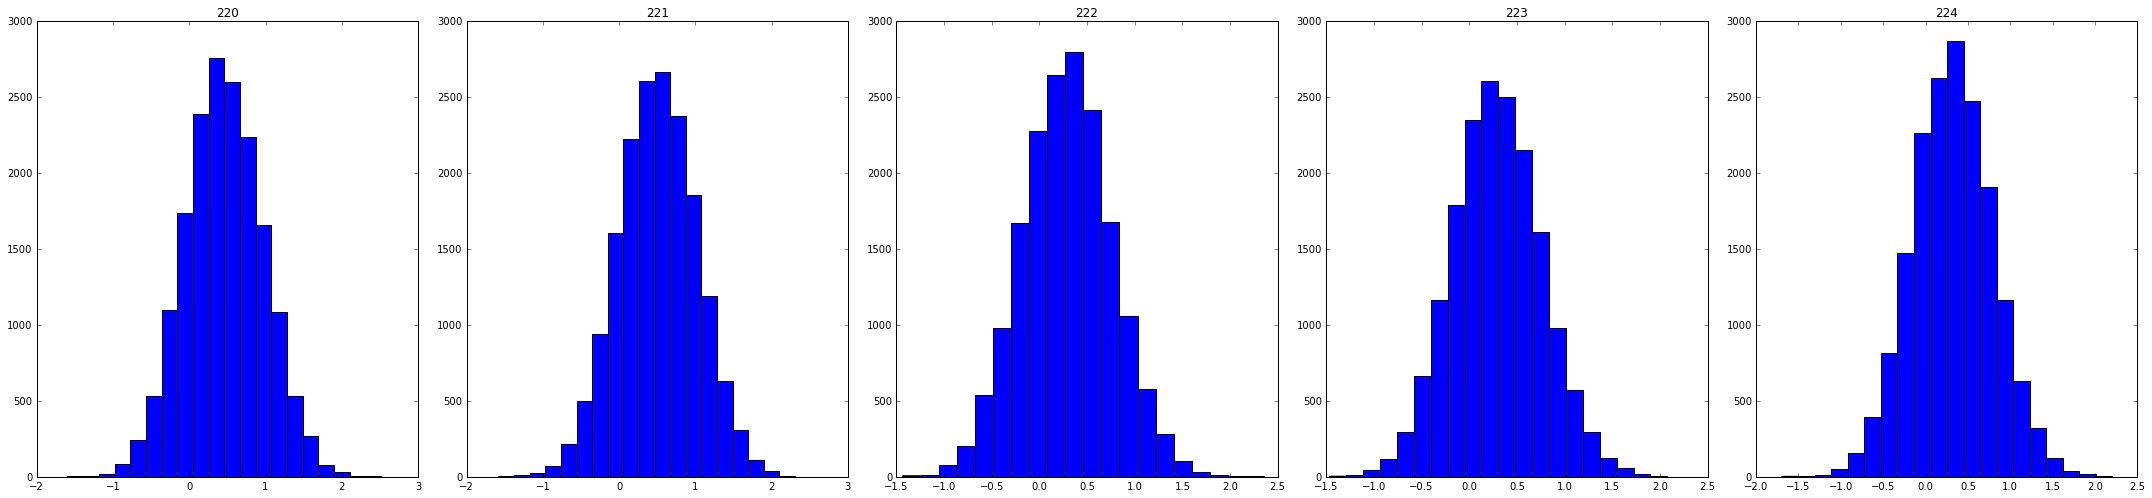

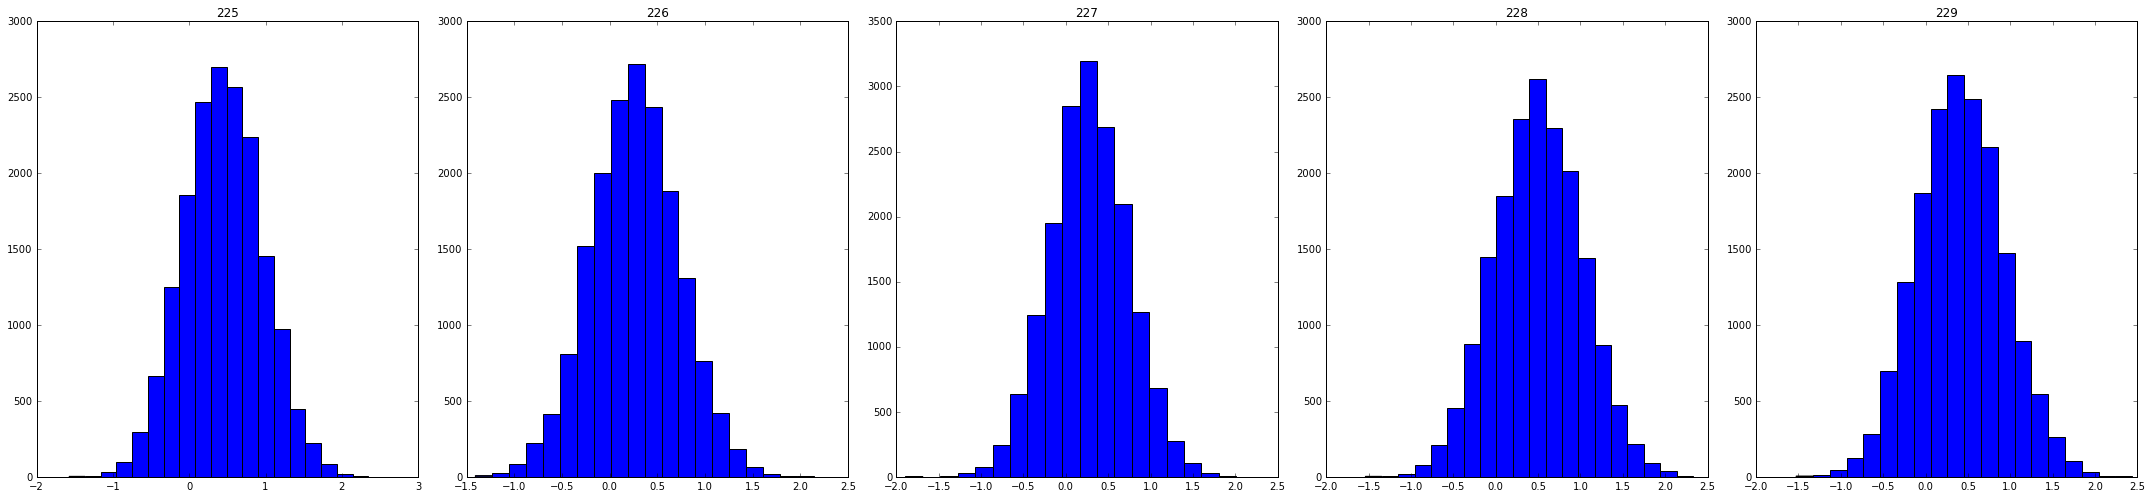

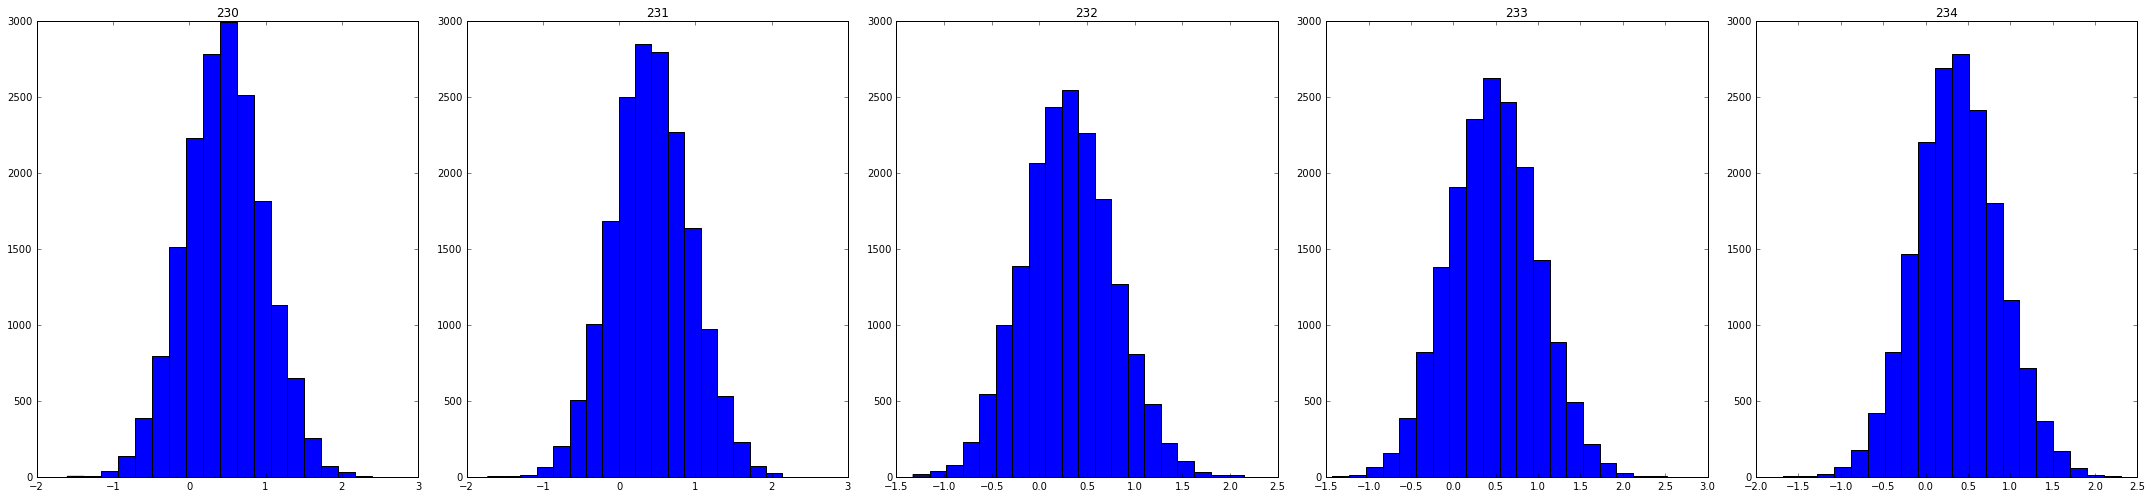

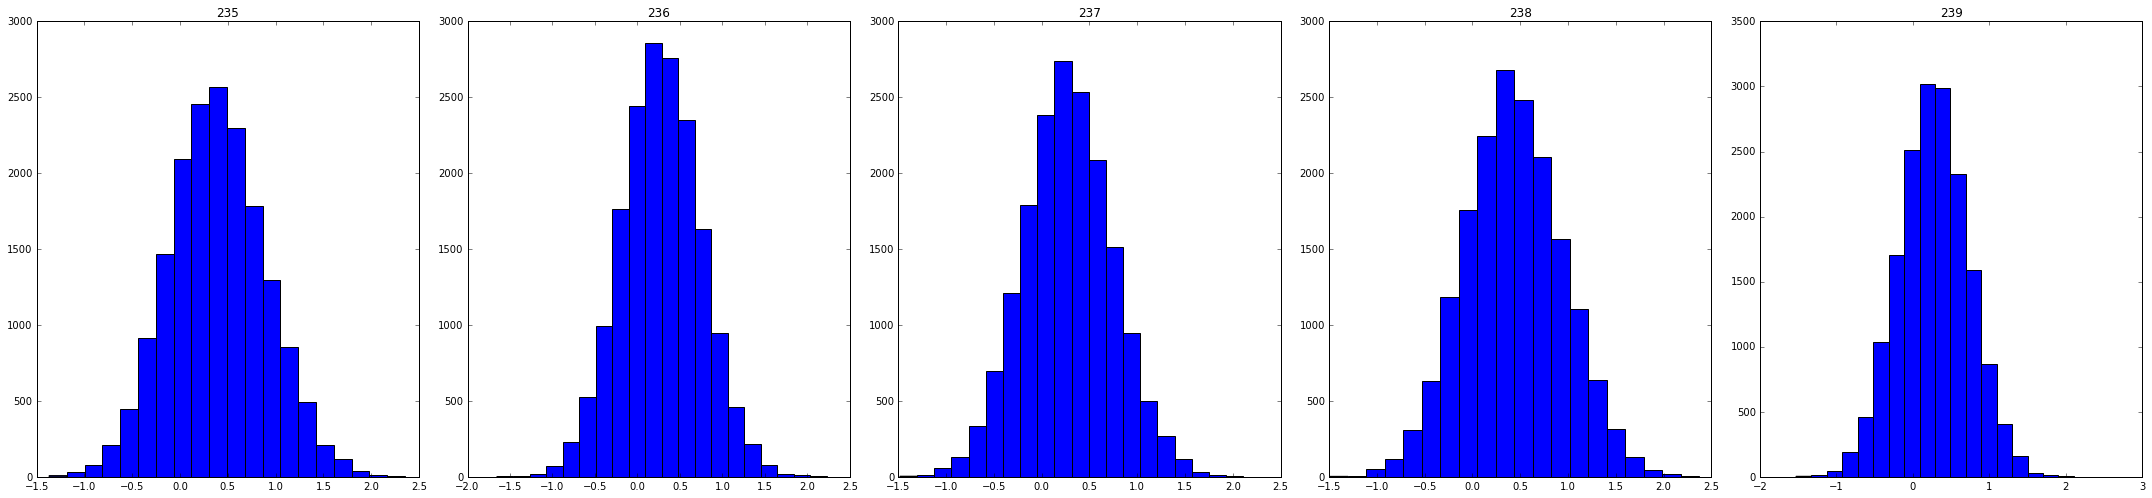

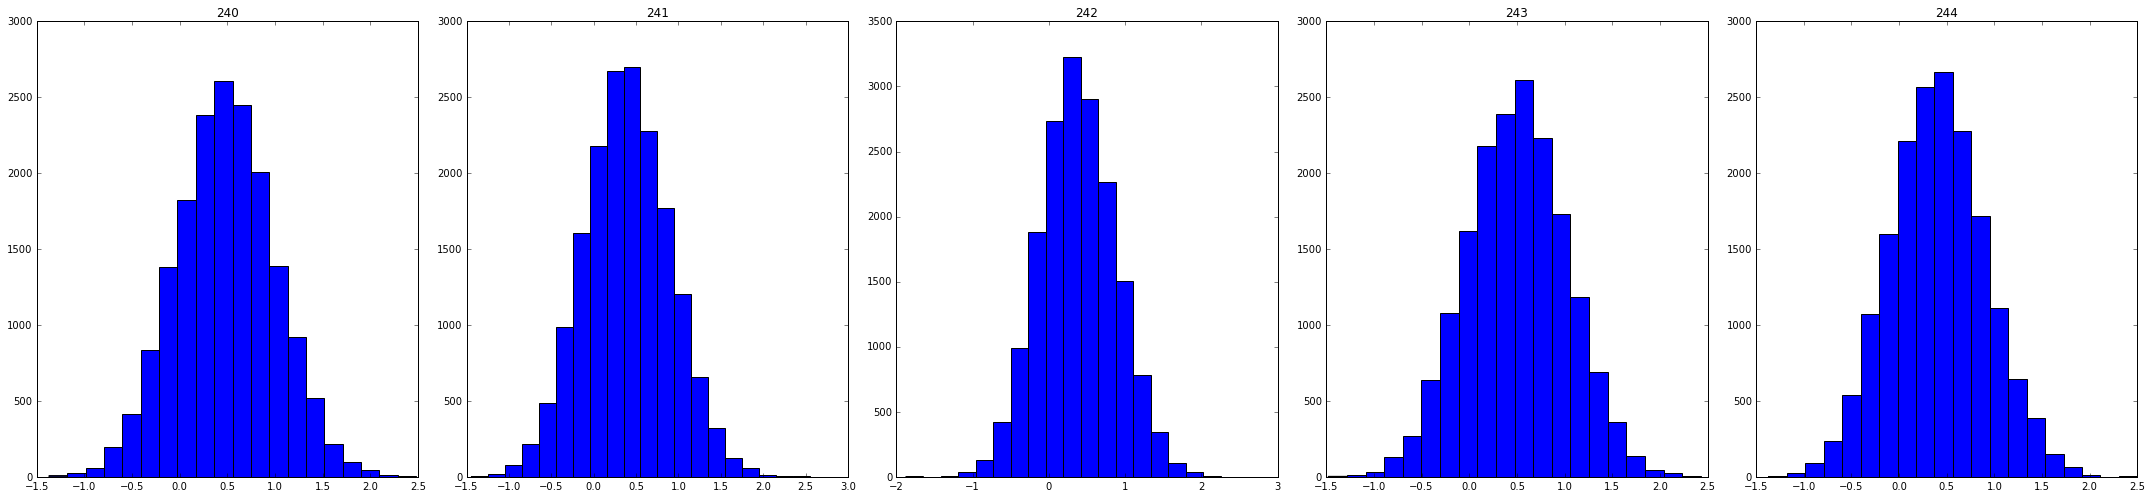

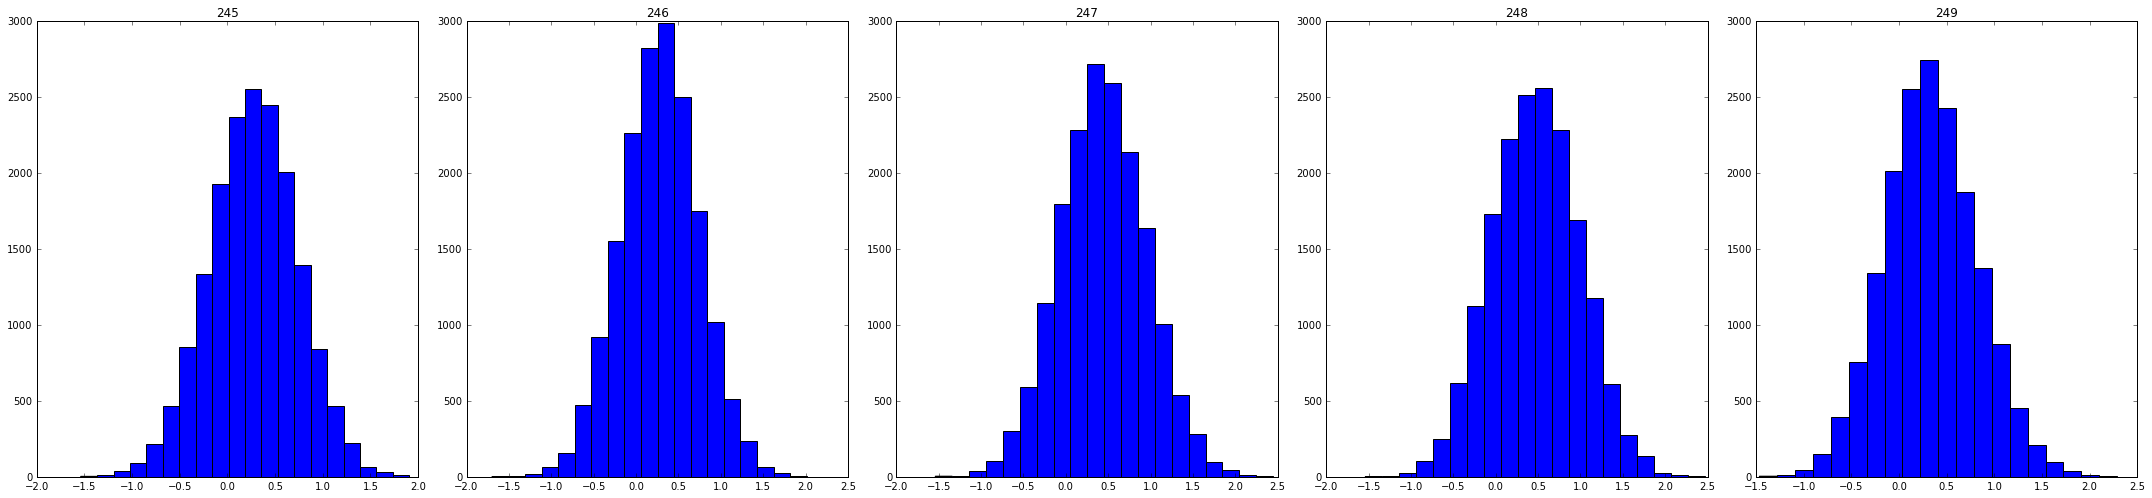

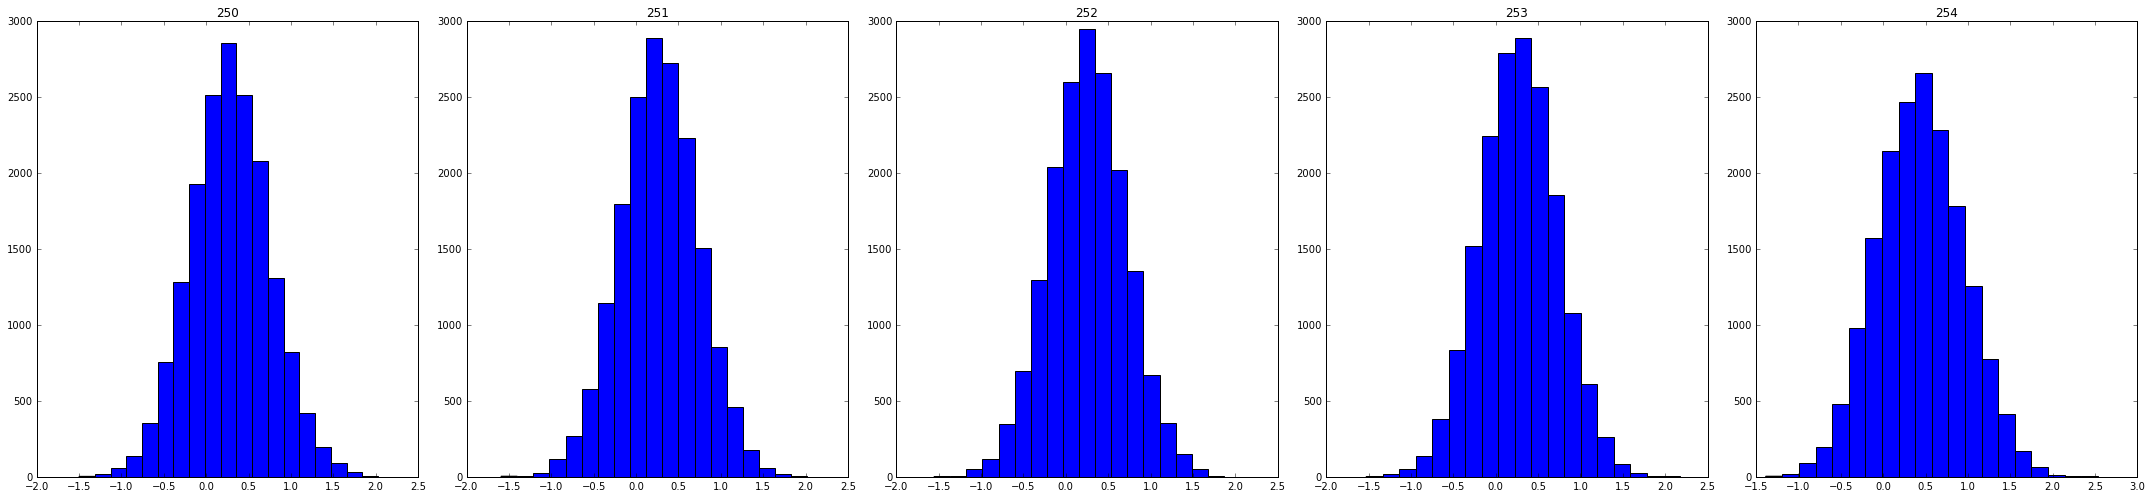

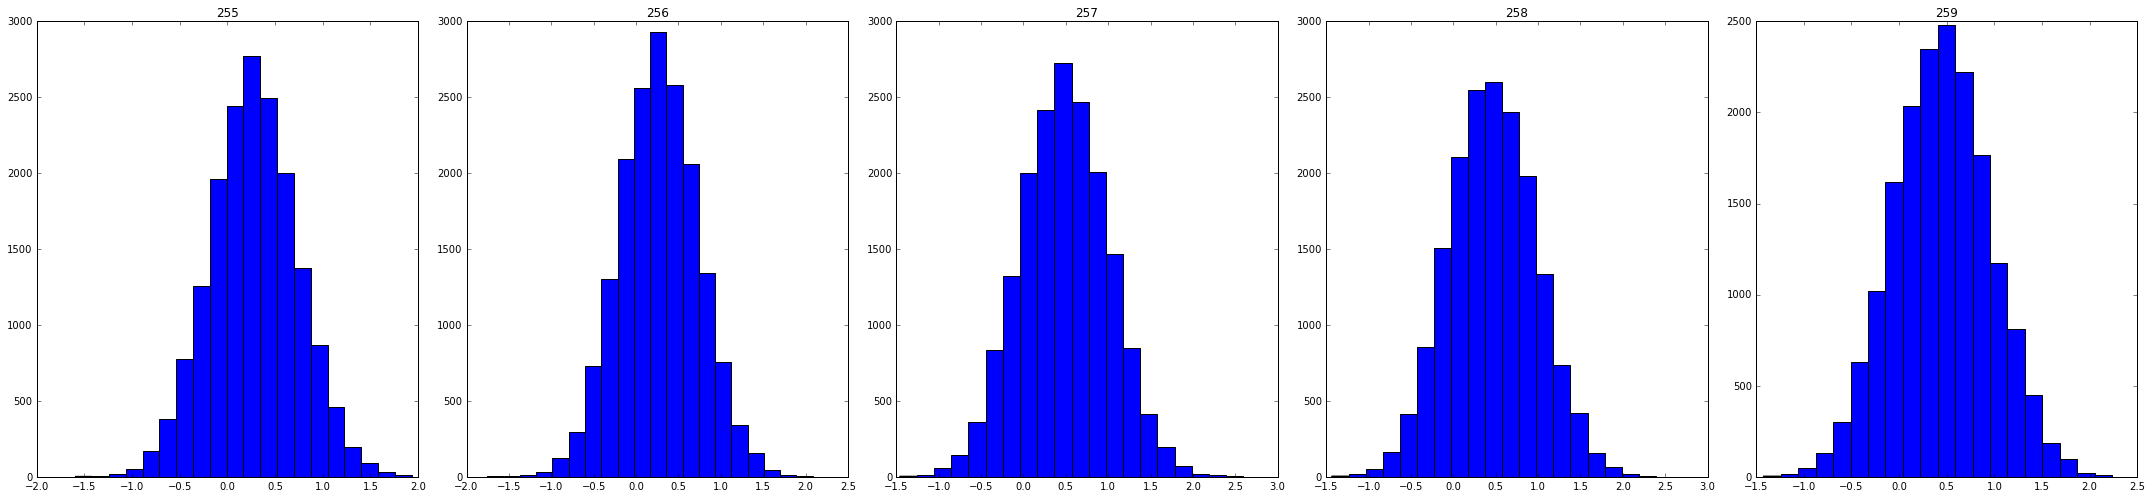

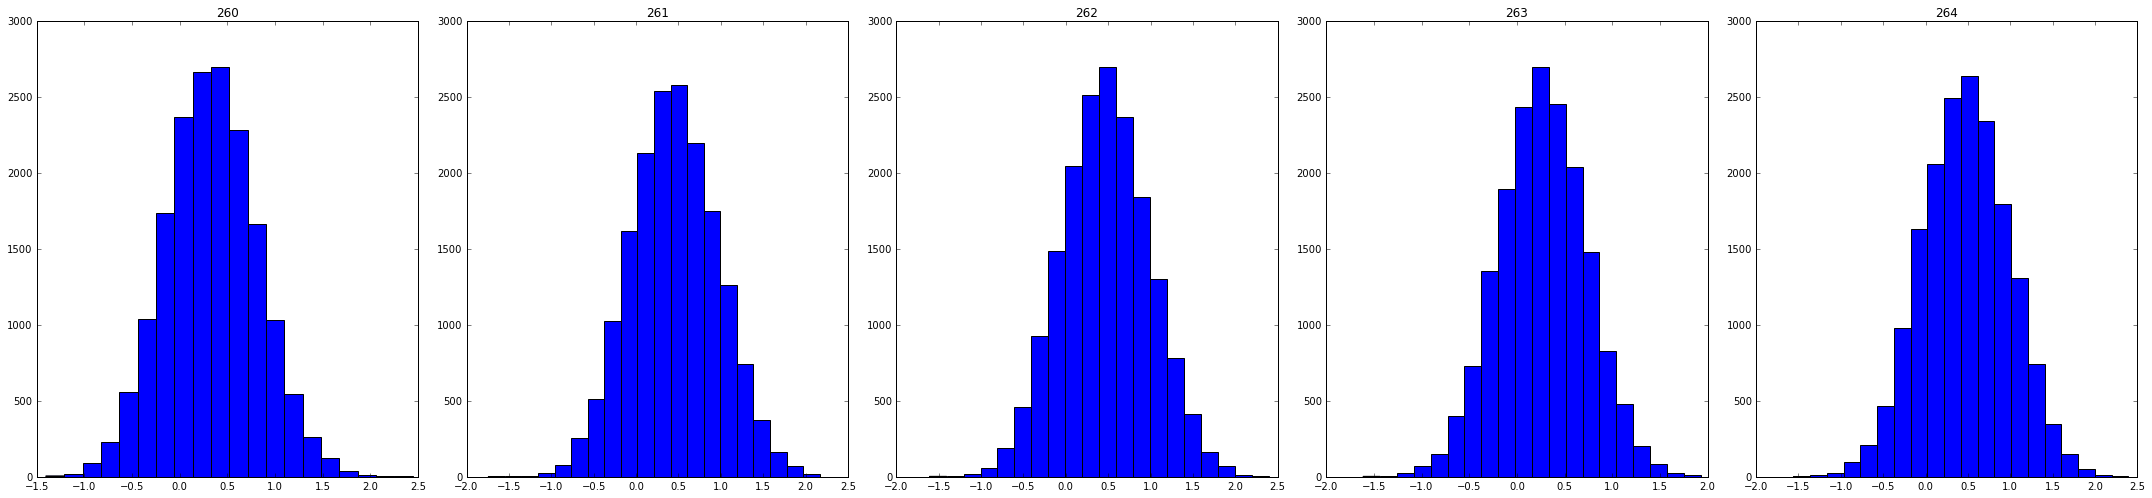

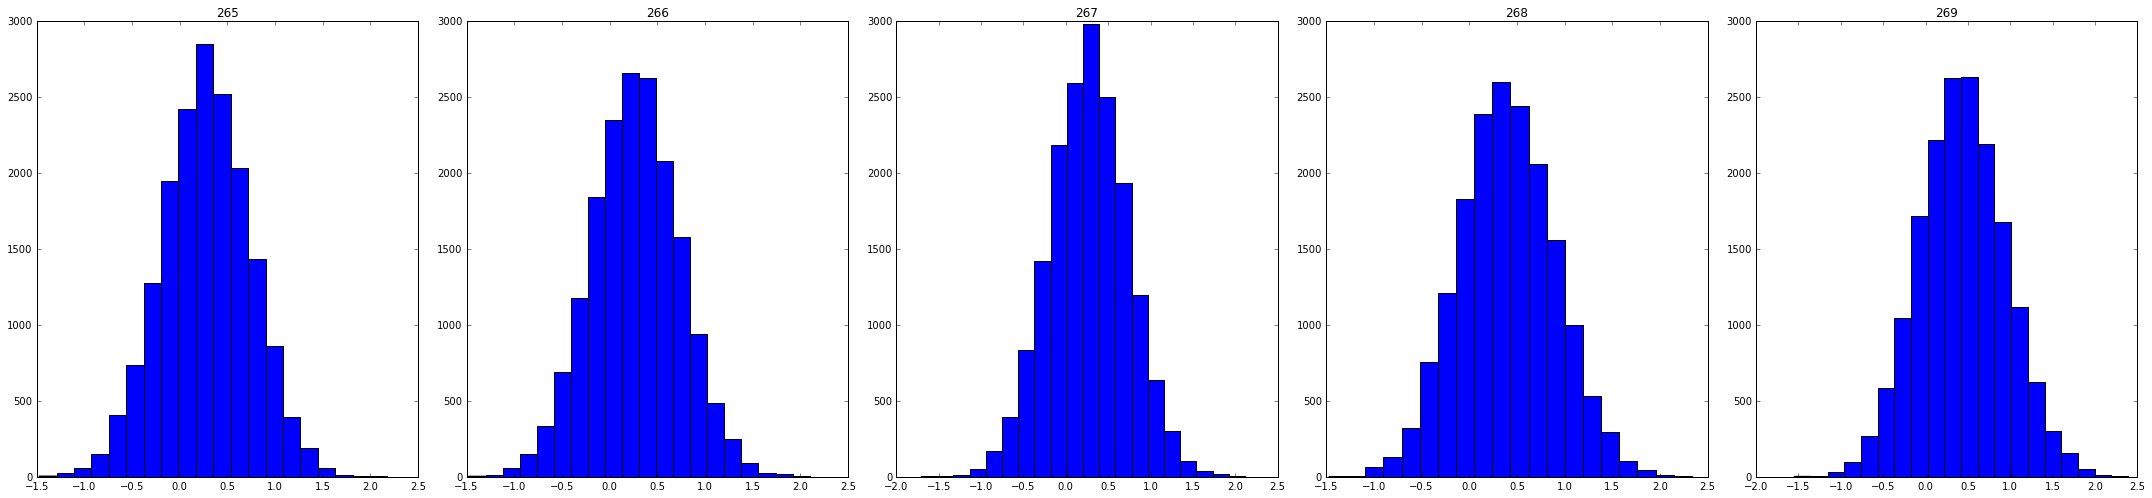

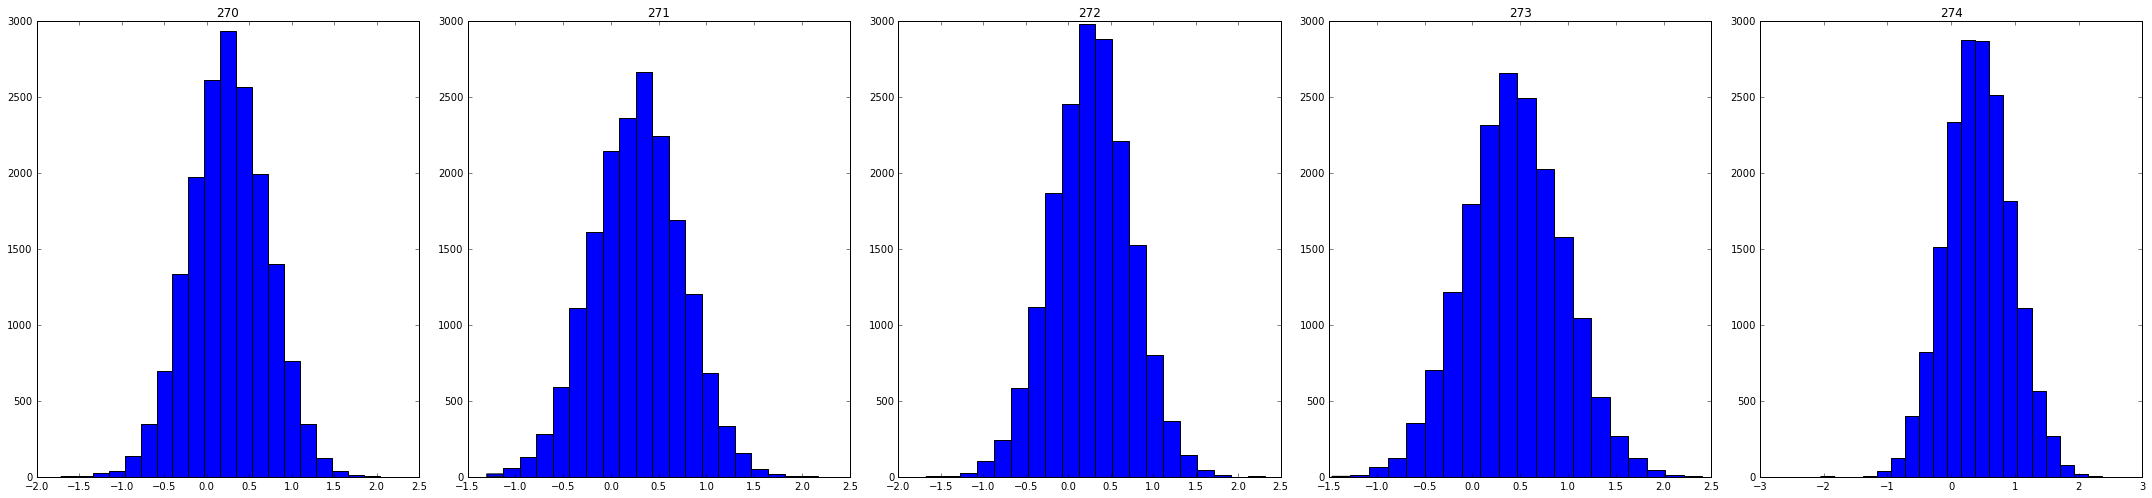

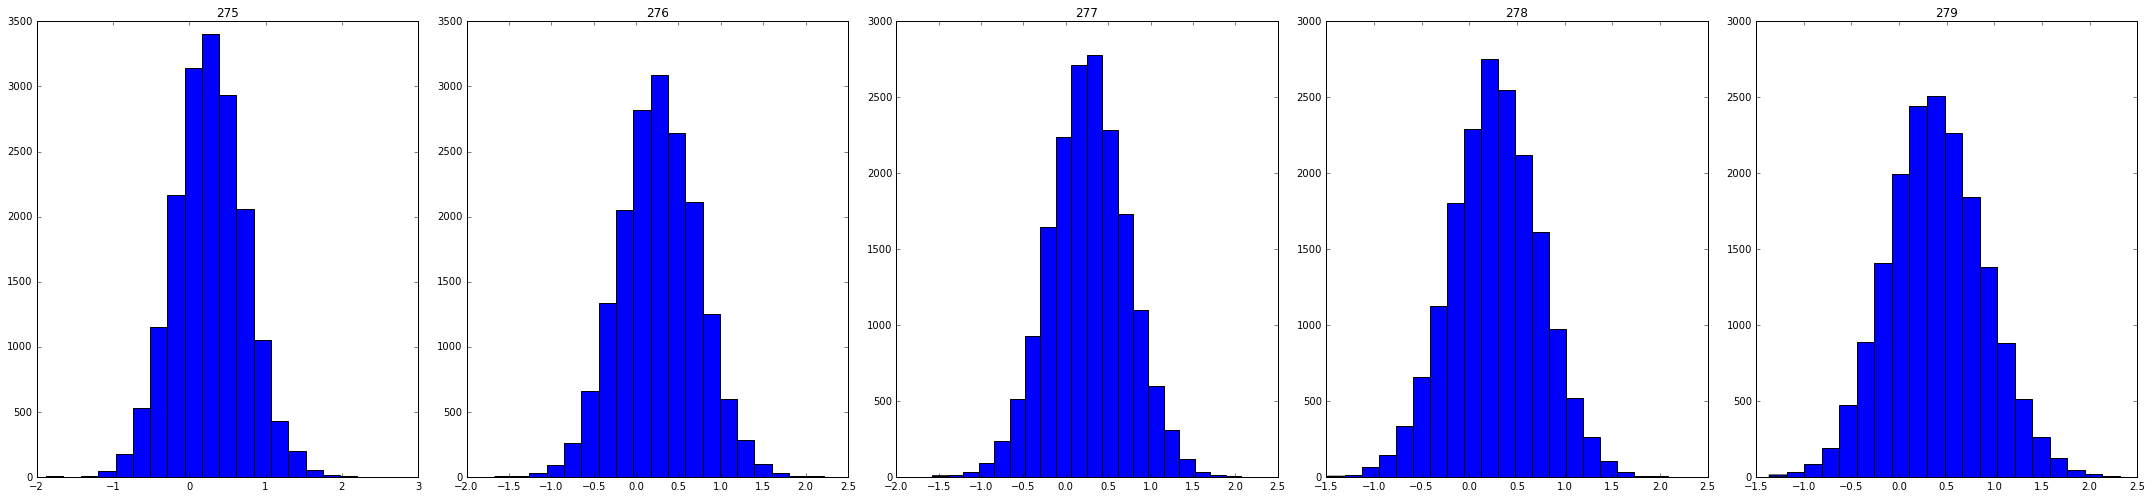

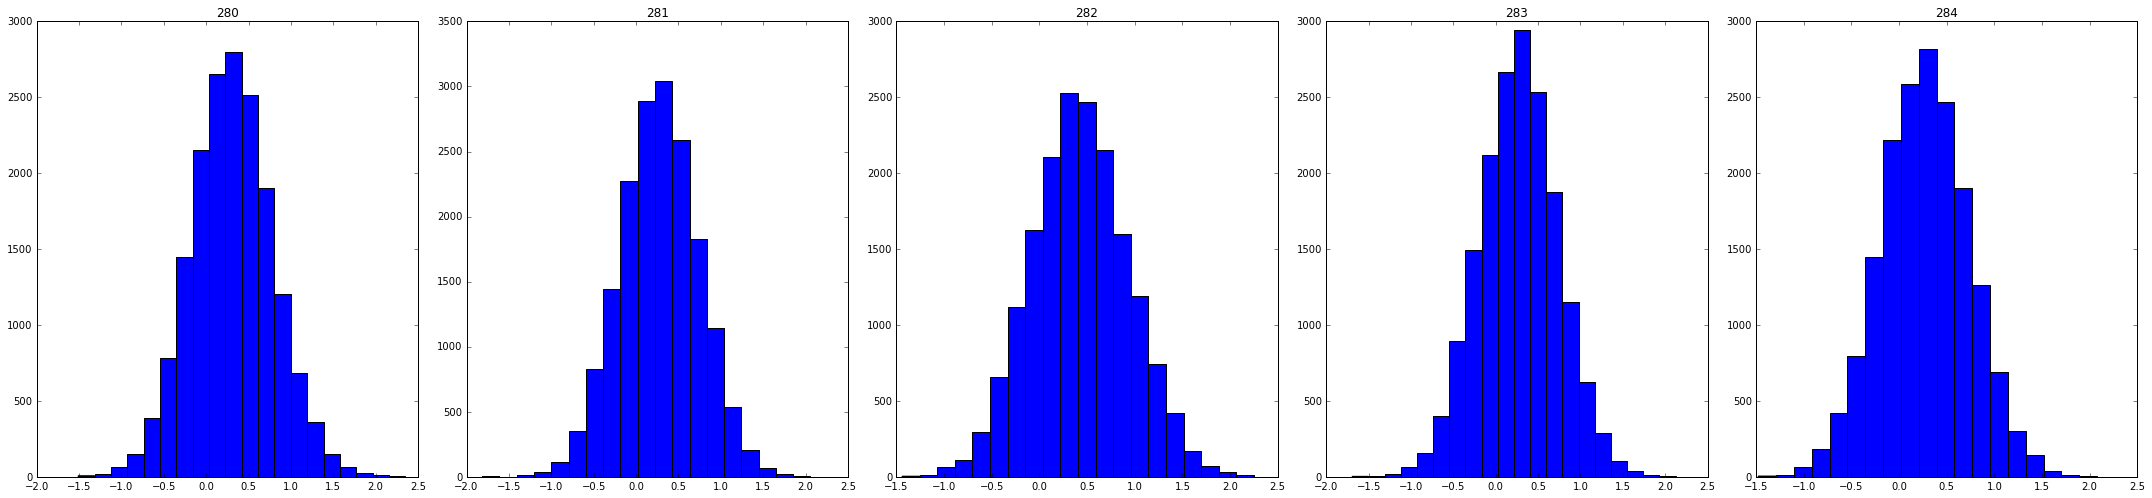

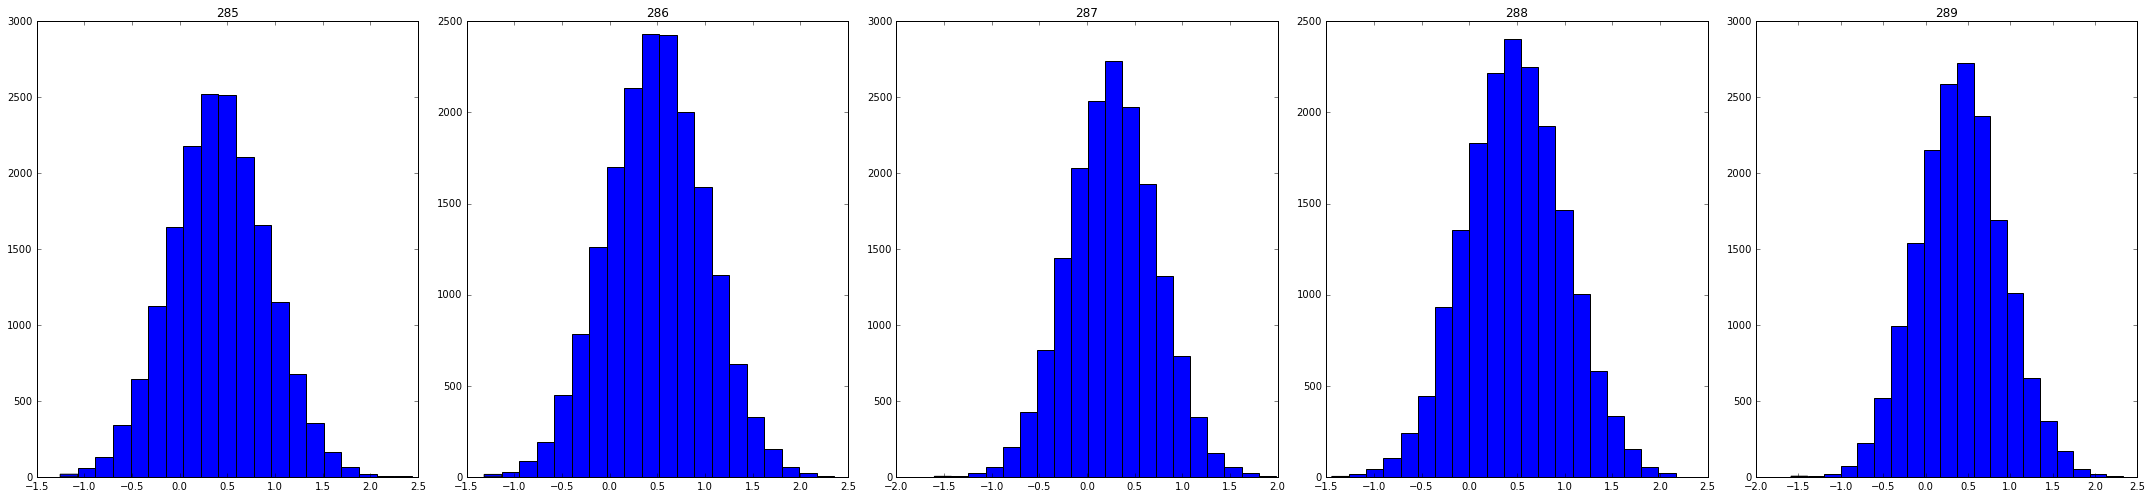

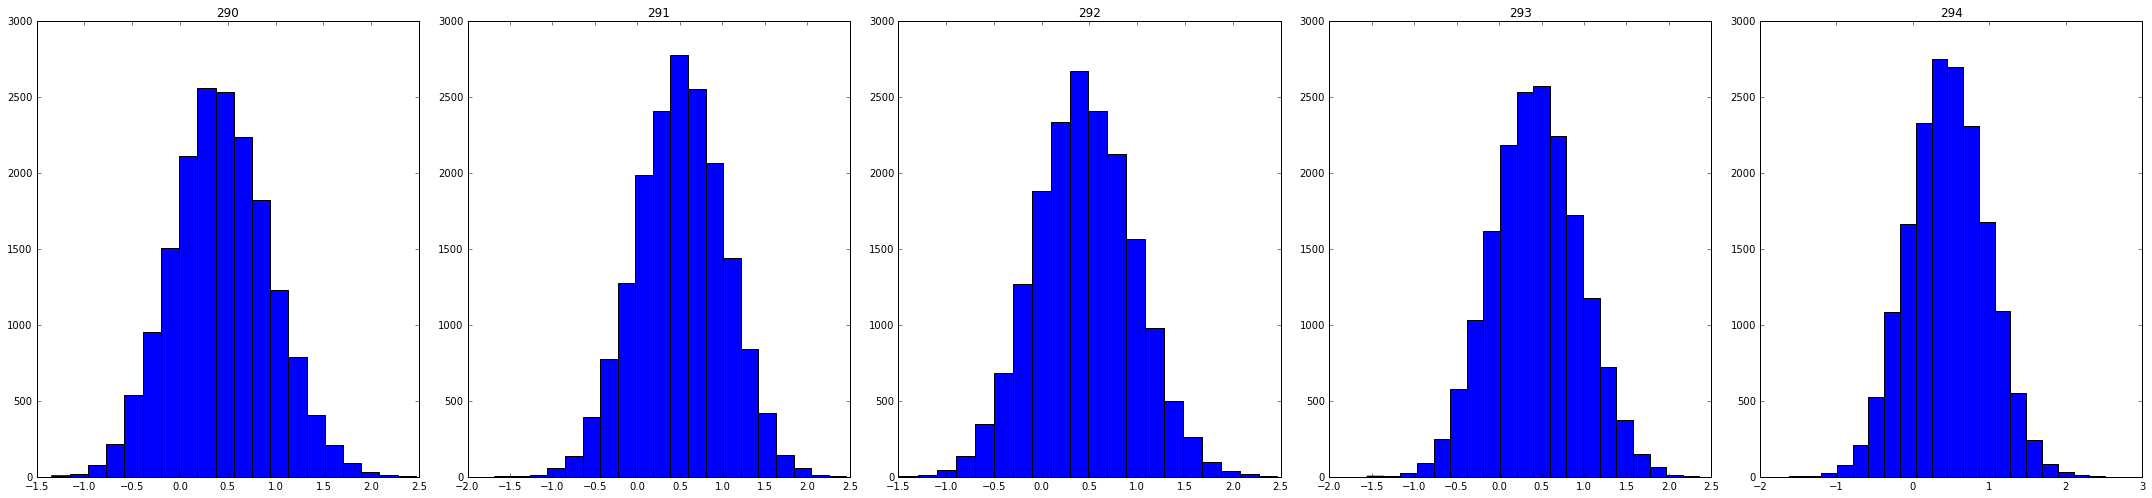

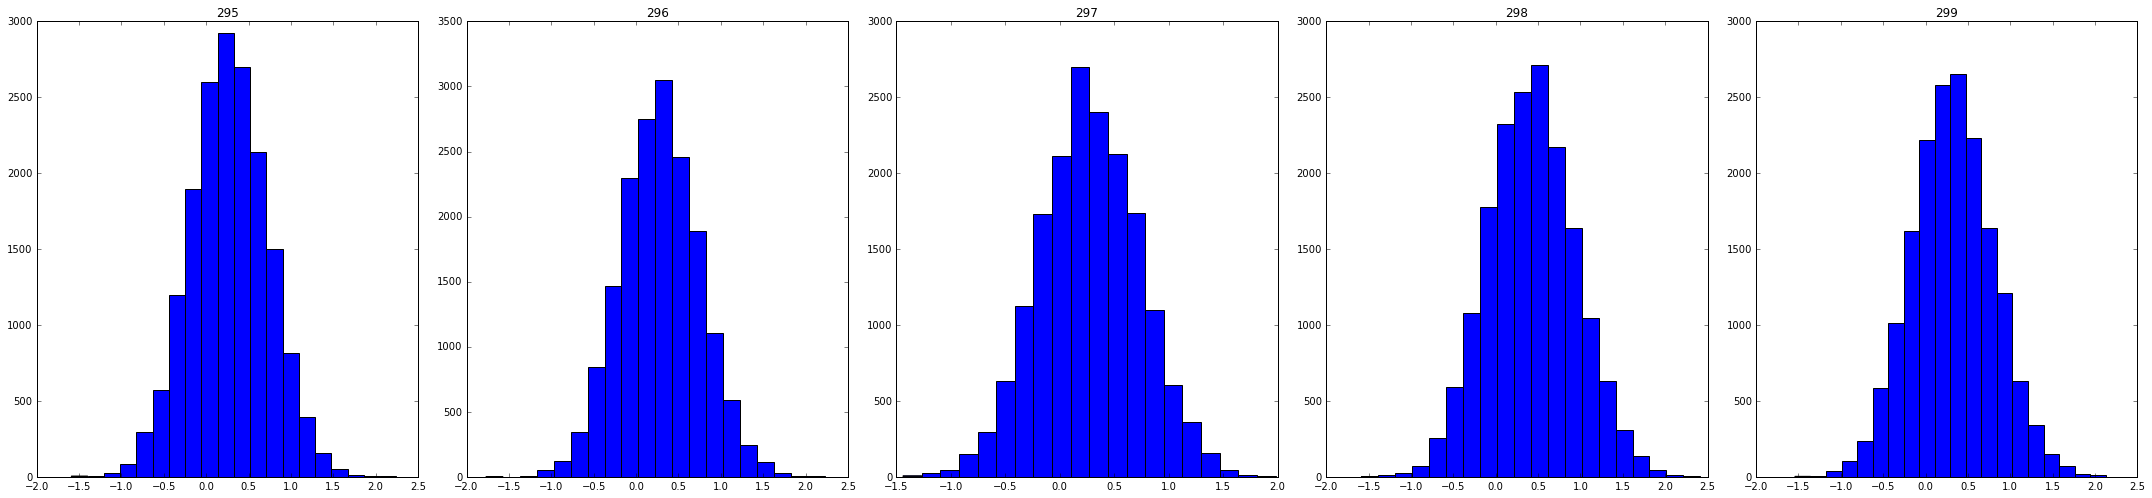

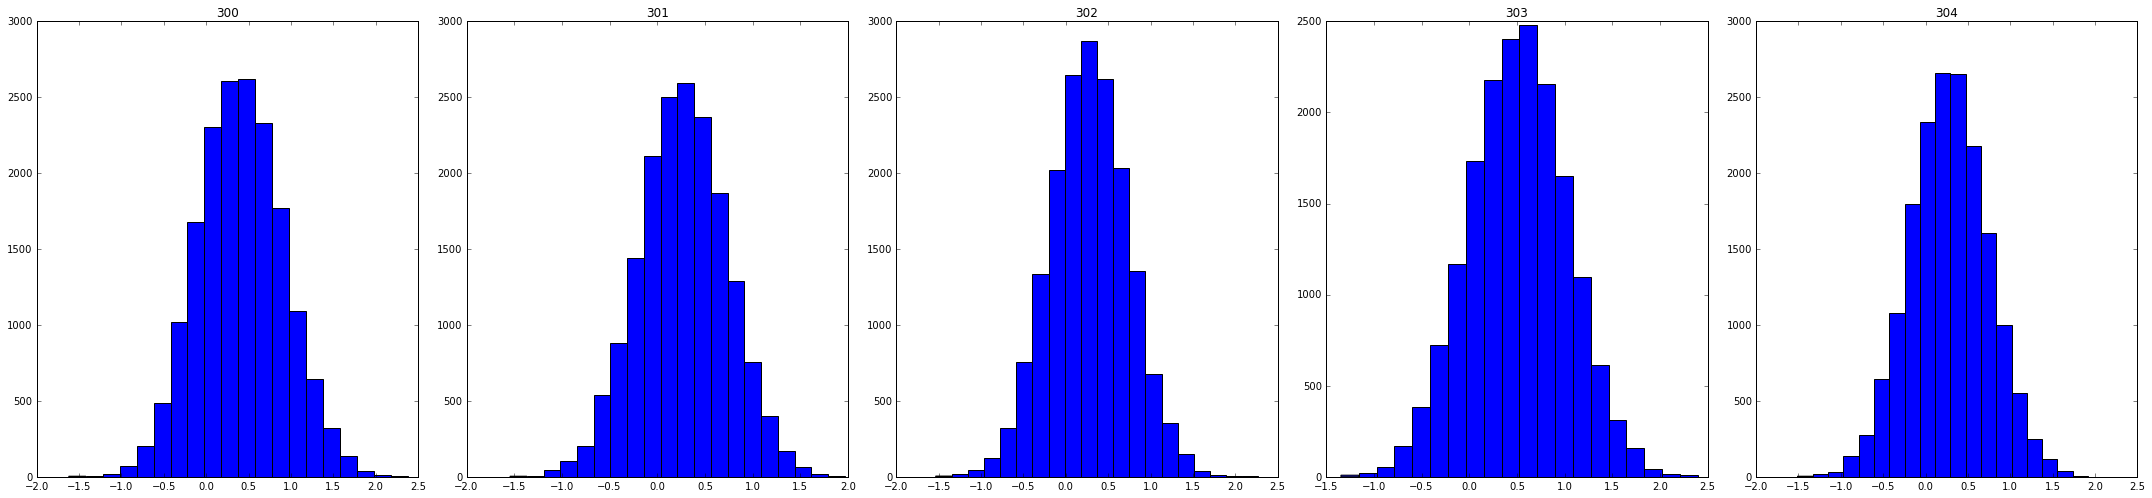

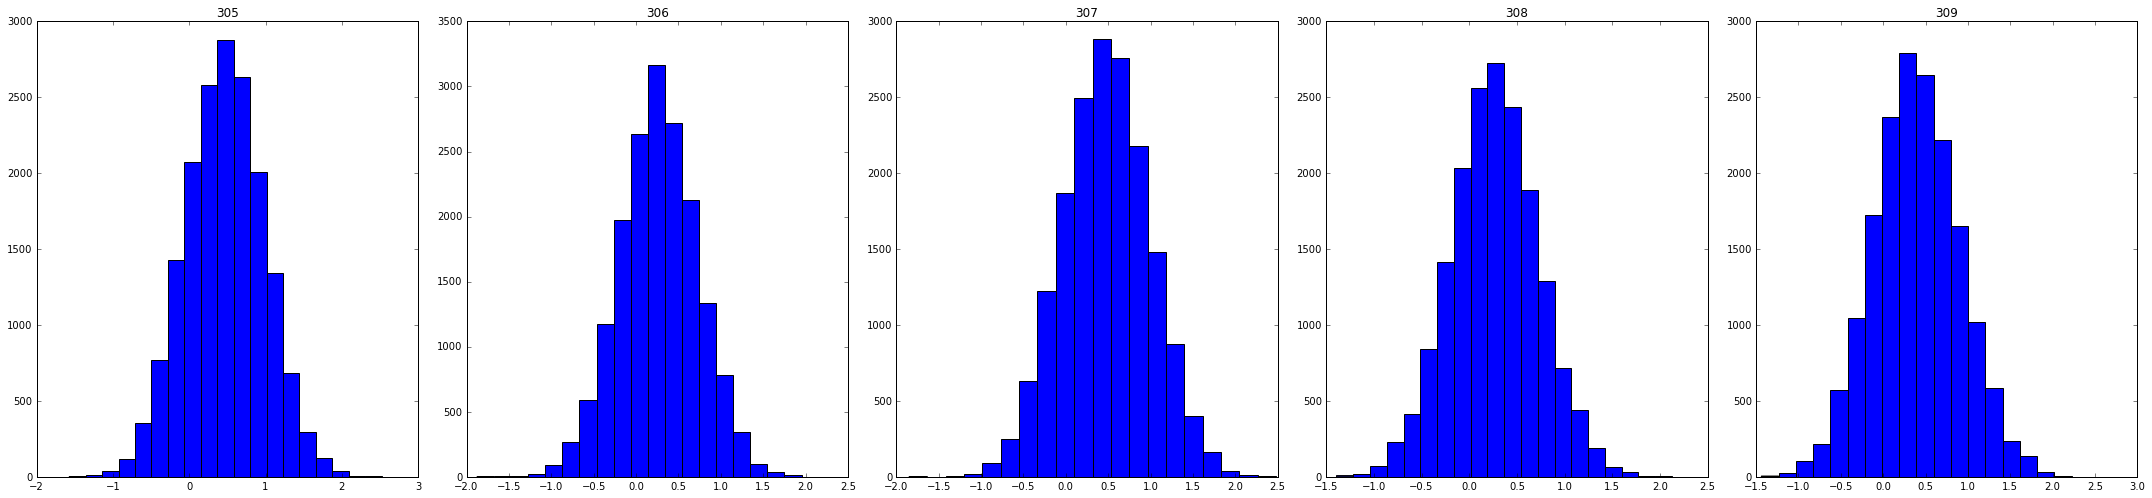

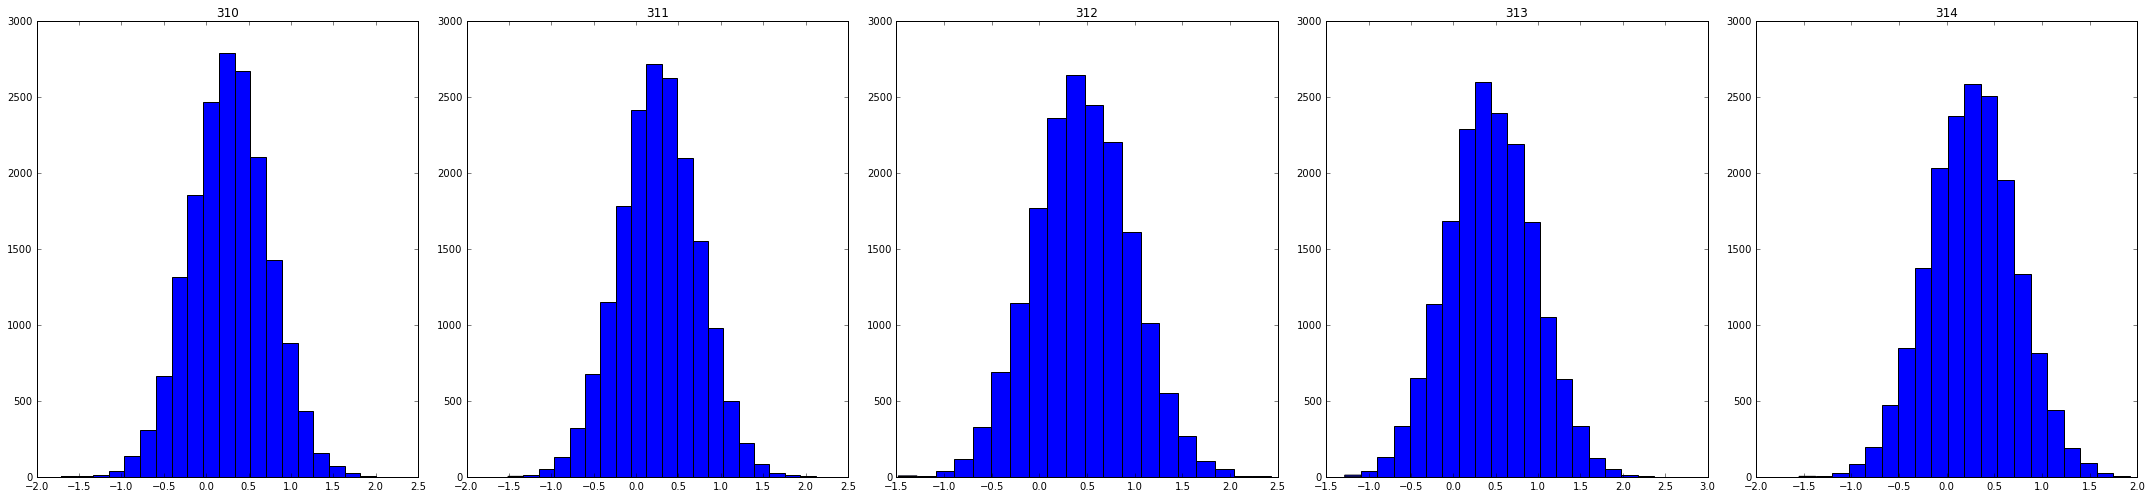

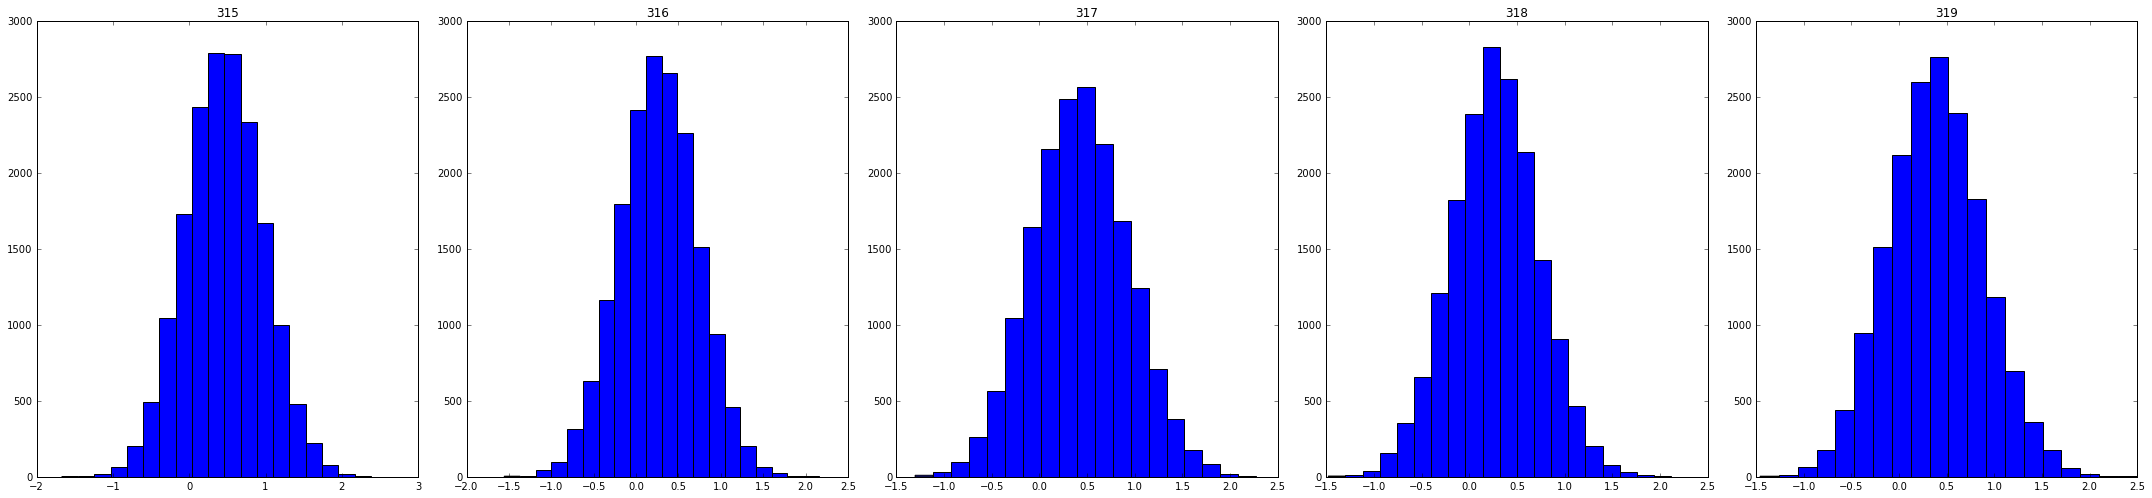

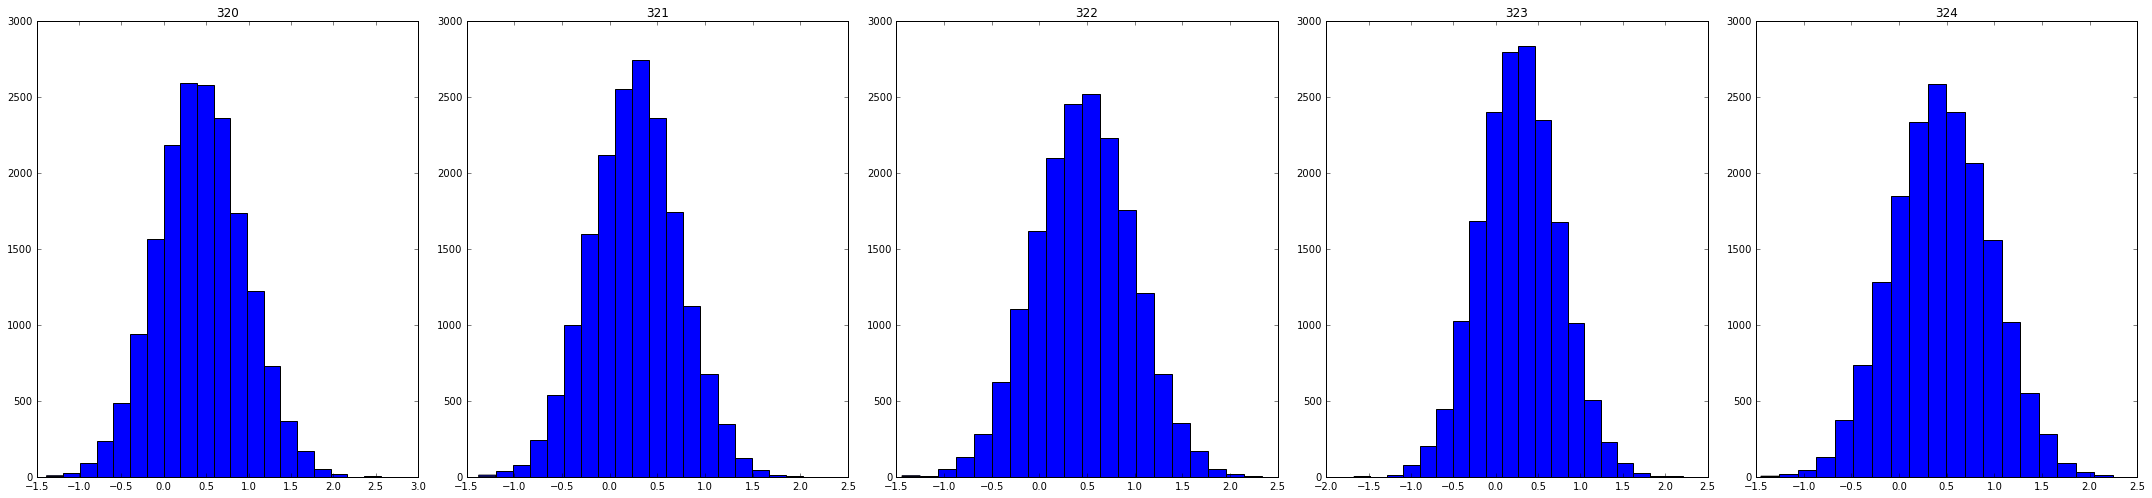

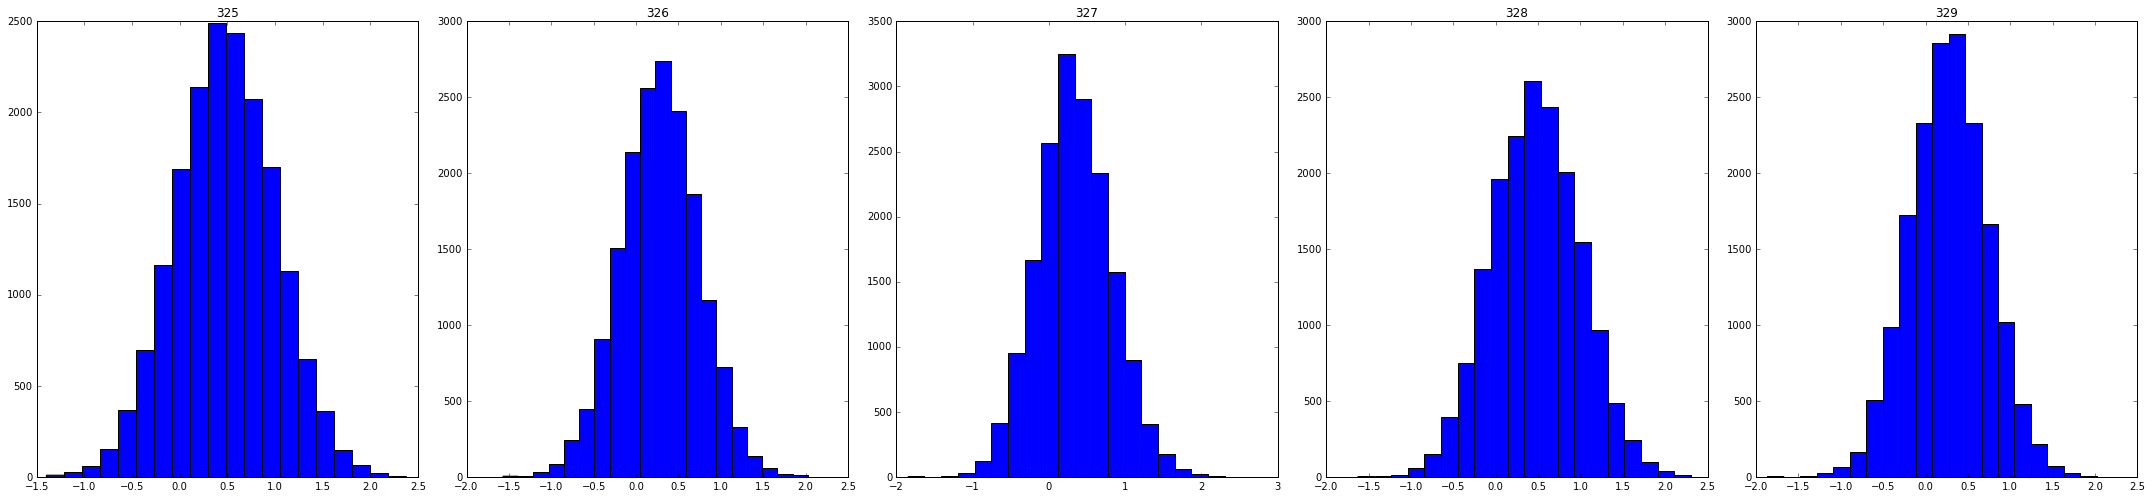

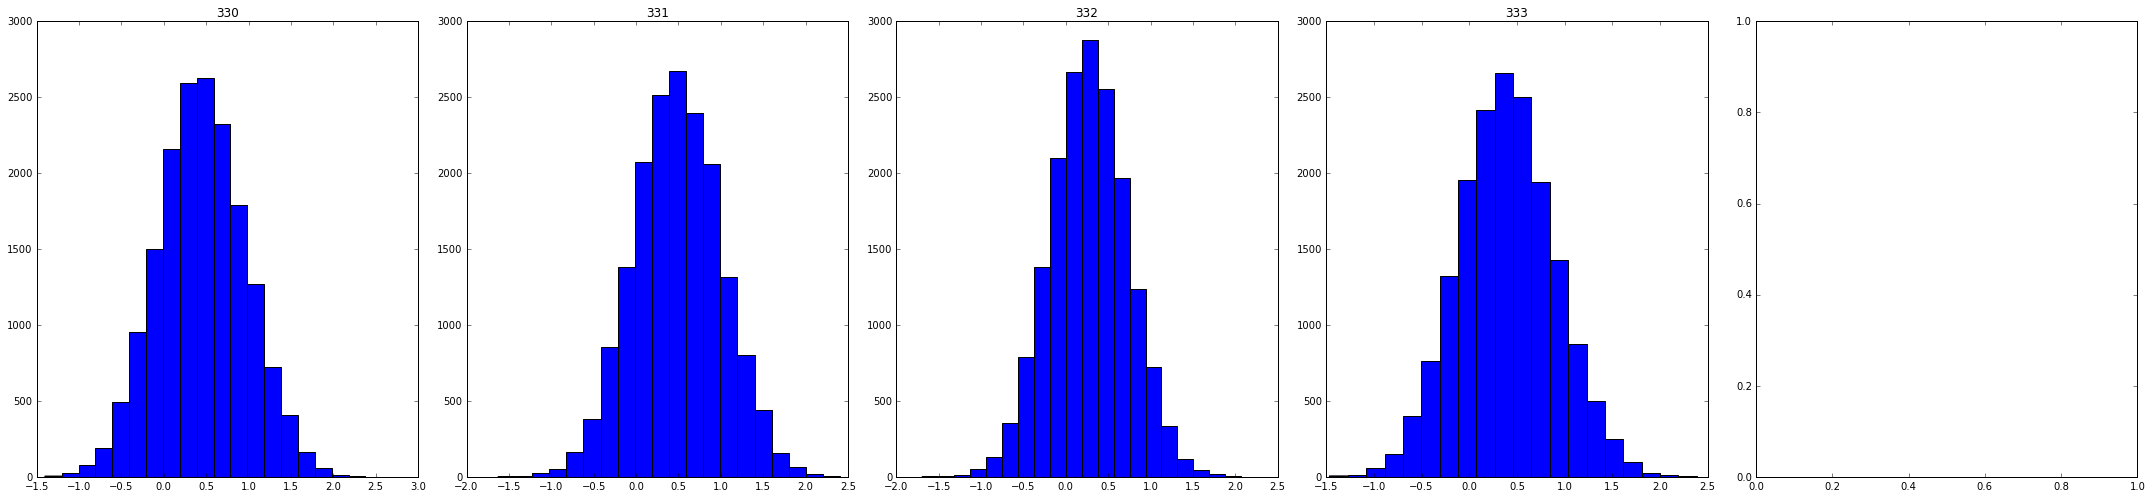

In [4]:
nCols = 5

# Calculate the number of rows of plots
nRows = (X.columns.size // nCols) + 1

numberFeatures = X.columns.size
featureNumber = 0

# We're going to display a plot of five columns for the first five
# features, and then continue to create more plots until we run out of features.
# This gives better performance than trying to plot all features in the same plot.
for row in range(nRows):
    fig, axes=plt.subplots(figsize=(30,7), nrows=1, ncols=nCols)

    for col in range(nCols):
        featureNumber = (row*nCols)+col
        
        if featureNumber < numberFeatures:
            axes[col].hist(X[featureNumber],bins=20,label='')
            axes[col].set_title(featureNumber)

    plt.tight_layout()
    plt.show()

## Distribution of Truth Values

We looked at the distribution of the output variable:

In [5]:
itemFrequencies = stats.itemfreq(YOrig)

total = YOrig.shape[0]
for freq, count in itemFrequencies:
    print('Frequencies:  ', freq, ': ', (count/total).round(4), '%')

Frequencies:   1 :  0.3261 %
Frequencies:   2 :  0.224 %
Frequencies:   3 :  0.3002 %
Frequencies:   4 :  0.1497 %


The occurences of 2 and 4 in the output is lower than 1 and 3. The fact that 4 is under-represented in the data is a concern, however, cross-validation techniques should assist us produce results where the proportion of 4s doesn't get too low that we produce bad results.

## Learning Curves

We examined initial learning curves to determine if we have a bias/variance issue and whether we have sufficient data avialable to us.


In [6]:
from IPython.display import Image

runLearningCurve = False

if runLearningCurve:
    # To run fast, make this 2. To make more accurate plots, make this 50 (will take a few hours to run though)
    nSplits=50

    #Split into training and test set - where the latter is a third of the total 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=10) 

    # Create the model
    model = RandomForestClassifier(
            n_estimators=50, 
            max_depth=32, 
            min_samples_split=4, 
            min_samples_leaf=4,
            random_state=24,   
            oob_score=True)

    # Cross validation, each time with 20% data randomly selected as a validation set.
    # The more splits the smoother the mean test and train score curves
    cv = ShuffleSplit(nSplits, test_size=0.2, random_state=0)

    for i in range(4):
        print("Analysing {}".format(i+1))
        plot_learning_curve(model, 'Learning Curve ({})'.format(i+1), 
                            X_train, 
                            Y_train[:,i], 
                            ylim=(0.7, 1.01), cv=cv, n_jobs=4)



        plt.savefig('learning_curve_{}.png'.format(i+1))
        
    plt.show()
    
else:
    display(Image(filename='learning_curve_1.png') )
    display(Image(filename='learning_curve_2.png') )
    display(Image(filename='learning_curve_3.png') )
    display(Image(filename='learning_curve_4.png') )


NameError: name 'display' is not defined

More data wasn't helping our model; we needed to look further into the features and model selection in order to produce better performing models.

## Feature Selection

Recursive feature elimination (RFE) allows us to determine the importance of each feature in our data set. By utilising the RFECV() function in scikit-learn we can perform feature elimination with cross validation.

Our first attempt is to perform feature elimination on a Random Forest Classifier for each of the four classes. We first ran a Grid Search to determine some suitable parameters.

In [ ]:
runGS = False

if runGS:
    model_to_set = OneVsRestClassifier(RandomForestClassifier())

    param_test1 = {'estimator__n_estimators':[10,20,30,40,50], 'estimator__max_depth':[3,6,8,12,24,32], 
               'estimator__min_samples_split':[2,4,6],'estimator__min_samples_leaf':[1,2,4]}
    
        
    gsearch1 = GridSearchCV(estimator = model_to_set, 
                        param_grid = param_test1,n_jobs=8,iid=False, cv=5,verbose=2)
    gsearch1.fit(X,Y)

    Y_predict = gsearch1.predict_proba(X)
    
    print('Best Params: ', gsearch1.best_params_)
    print( 'Best Score: ', gsearch1.best_score_)
    
else:
    print('[Parallel(n_jobs=8)]: Done 1350 out of 1350 | elapsed: 228.6min finished')
    print("Best Params:  {'estimator__min_samples_leaf': 4, 'estimator__n_estimators': 10, 'estimator__max_depth': 32, 'estimator__min_samples_split': 4}")
    print('Best Score:  0.27776433674694306')

Then, for each of the classes, we ran RFECV() and scored each run with an ROC area under the curve (roc_auc) score. RFECV() runs a grid search for all possible features and will give us the ranking of how important each feature is, the number of features that produces the highest score and the actual scores for each iteration. We saved the ranking and scores for later use.

In [ ]:
# Plotting code taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
%run 'plot_learning_curve.py'

from sklearn.feature_selection import RFECV

def plotFeatureRankings(classifier, grid_scores):
    """ Plot number of features VS. cross-validation scores
    """
    plt.figure()
    plt.title('Classifier {}'.format(classifier))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(grid_scores) + 1), grid_scores)
    plt.show()
        
def createRFEScores(model, modelName, X_train, Y_train, X_test, Y_test):
    # Calculate the best features for each of the classifiers seperately
    for i in range(4):
        rfecv = RFECV(model, scoring='roc_auc', verbose=2, n_jobs=-1)
        rfecv.fit(X_train, Y_train[:,i])
        rfecv.score(X_test, Y_test[:,i])
        print('Model {} Number Features {}'.format(i, rfecv.n_features_))
        print('Model {} Number Estimators {}'.format(i, rfecv.ranking_))
        print('Model {} Scores {}'.format(i, rfecv.grid_scores_))
        print('Model {} Support {}'.format(i, rfecv.support_))

        np.save('{}_class{}_ranking.npy'.format(modelName, i+1), rfecv.ranking_)
        np.save('{}_class{}_scores.npy'.format(modelName, i+1), rfecv.grid_scores_)

# Set to True to run the RFE (time consuming)
# Set to false to display pre-calculated results
runRFE = False

if runRFE:
    rf_model = RandomForestClassifier(
                        n_estimators=50, 
                        max_depth=32, 
                        min_samples_split=4, 
                        min_samples_leaf=4,
                        random_state=24,   
                        oob_score=True)
    
    svc_model = SVC(C = 10, gamma=0.01, kernel='linear', probability=True, n_jobs=-1)
    
    createRFEScores(rf_model, 'rf', X_train, Y_train, X_test, Y_test)
    #createRFEScores(svc_model, 'svc', X_train, Y_train, X_test, Y_test)

else:
    for i in range(4):
        classifier = i+1
        ranking = np.load('rf_class{}_ranking.npy'.format(classifier))
        grid_scores = np.load('rf_class{}_scores.npy'.format(classifier))
        
        plotFeatureRankings(classifier, grid_scores)
        
        print('Class 1: Best score: ', 158)
        print('Class 2: Best score: ', 147)
        print('Class 3: Best score: ', 153)
        print('Class 4: Best score: ', 64)
    

From the plots, above, we can we can see that there classes one and three are similar in that the benefits tail off after around 100 features (the best scores occurring around 150 features). Four becoming significantly worse after 100 features, with only 64 features needed to produce it's best score.

We extracted the relevant features and ran some comparisons.

In [ ]:
def extractFeatures( X, nFeatures, ranking ):
    importance = pd.DataFrame({'feature': X.columns, 'rank': ranking})
    importance.sort_values(['rank', 'feature'], ascending=[1, 1], inplace=True)
    
    deleteCols = importance.feature[nFeatures:]
    
    return X.drop(X.columns[deleteCols],axis=1)
    
    
def featureSelection( X ):

    clfName = 'rf'
    X_features = []

    class1_nFeatures = 158
    class1_ranking = np.load('{}_class1_ranking.npy'.format(clfName))

    class2_nFeatures = 147
    class2_ranking = np.load('{}_class2_ranking.npy'.format(clfName))
    
    class3_nFeatures = 153
    class3_ranking = np.load('{}_class3_ranking.npy'.format(clfName))
    
    class4_nFeatures = 64
    class4_ranking = np.load('{}_class4_ranking.npy'.format(clfName))
 
    X_features.append(extractFeatures( X, class1_nFeatures, class1_ranking ))
    X_features.append(extractFeatures( X, class2_nFeatures, class2_ranking ))
    X_features.append(extractFeatures( X, class3_nFeatures, class3_ranking ))

    X4 = extractFeatures( X, class4_nFeatures, class4_ranking )
    
    X_features.append(X4)
    
    return X_features

X_features = featureSelection( X );


We ran a number of tests to determine whether we could apply these reduced feature sets uniformly across different classifiers.

Without RF feature elimination:

<pre>
AUC with RandomForest  :  0.615432098765
AUC with GaussianNB  :  0.811448324515
AUC with QDA  :  0.701939329806
AUC with KNN  :  0.704791887125
AUC with LogisticRegression  :  0.80424526749
AUC with SVC  :  0.827416108172
</pre>

With RF feature elimination:

<pre>
AUC with RandomForest  :  0.668342857143
AUC with GaussianNB  :  0.7902335097
AUC with QDA  :  0.755114873604
AUC with KNN  :  0.694470664315
AUC with LogisticRegression  :  0.784000235156
AUC with SVC  :  0.762973544974
</pre>

Our results showed a marked improvement for random forest, however, the SVM showed a significant decrease.

Our conclusion was that we would have to run multiple tests to find the ideal number of features for each algorithm and each class. Given the finite amount of time available, and the computing power needed to perform these calculations, we decided to concentrate on using this technique for random forest only.

Next we discuss [The Model](HW3b.ipynb)